# Analysis code for "Ticket to Walk: How Jaywalking Enforcement Impacts Washingtonians"

Author: Ethan C. Campbell

This Python code notebook shows the analyses used to generate the statistics and charts in Transportation Choices Coalition's 2024 report "Ticket to Walk: How Jaywalking Enforcement Impacts Washingtonians." The code is freely available for reuse with attribution, pursuant to the MIT License in the GitHub repository. Please contact me at ethanchenbell@gmail.com with any questions.

## Preamble

In [ ]:
# Authorize access to Google Drive
from google.colab import drive, auth
drive.mount('/content/drive',force_remount=True)

Mounted at /content/drive


In [ ]:
# Import packages
import numpy as np
from scipy.interpolate import interp1d
import pandas as pd
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import matplotlib.gridspec as gridspec
from matplotlib.patches import Patch
import os
import sys

# Install miscellaneous packages to Google Drive (one-time)
# nb_path = '/content/notebooks'
# os.symlink('/content/drive/My Drive/Colab Notebooks',nb_path)
# sys.path.insert(0,nb_path)
# !pip install --target=$nb_path adjustText
# !pip install --target=$nb_path censusdis

sys.path.append('/content/drive/My Drive/Colab Notebooks')
from adjustText import adjust_text
import censusdis.data as ced

In [ ]:
# Install Cartopy
!pip install -q cartopy

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.8/11.8 MB 75.4 MB/s eta 0:00:00


In [ ]:
# Import newly installed packages
import cartopy.crs as ccrs
import cartopy.feature as cf
from cartopy.io.img_tiles import OSM
from cartopy.feature import ShapelyFeature
import geopandas

In [ ]:
# Filepaths
root = '/content/drive/MyDrive/TCC (Transportation Choices Coalition)/'
data_dir = root + 'Data/'
current_results_dir = root + 'Figures/'

meta_filepath = data_dir + '2024-01-18 - jaywalking public records - metadata.xlsx'
contacts_filepath = data_dir + '2024-01-18 - jaywalking public records - individual contacts.xlsx'

seattle_dir = data_dir + '2021-04-09 - Seattle Municipal Court ped violations (obtained by Abrahan Hernandez)/'
seattle_citations_filepath = seattle_dir + 'Ped Violations Since 2000_040921.xlsx'
seattle_updated_dir = data_dir + '2023-05-23 - Seattle Municipal Court ped violations (obtained by Hester Serebrin)/'
seattle_updated_citations_filepath = seattle_updated_dir + 'SMC Data - 11.40, 11.50.xlsx'

aoc_citations_filepath = data_dir + '2023-03-21 - WA State Administrative Office of the Courts data/FD 8996 rerun.xlsx'
aoc_seattle_merged_cleaned_filepath = data_dir + '2023-11-12 - analysis output files/AOC merged with SMC and cleaned.xlsx'

wa_ofm_pop_data_filepath = data_dir + '2022-07-14 - WA Office of Financial Management - April 1, 2022 population estimates.xlsx'
census_data_filepath = data_dir + '2023-11-12 - analysis output files/ACS 2021 5-year census demographics for Washington.xlsx'
county_shapefile_path = data_dir + '2023-02-15 - geographic shapefiles/cb_2018_us_county_500k'
place_shapefile_path = data_dir + '2023-02-15 - geographic shapefiles/cb_2018_53_place_500k'

In [206]:
# Load data
meta = pd.read_excel(meta_filepath,header=0,skiprows=[1],dtype={'Installment ID':str})
contacts = pd.read_excel(contacts_filepath,sheet_name='Contacts',header=0,skiprows=[1],
                         parse_dates=[['Contact date','Contact time']])
contacts = contacts.rename(columns={'Contact date_Contact time':'Contact datetime'})
seattle_citations = pd.read_excel(seattle_citations_filepath,header=0) # Note: haven't loaded defendant name sheet here
seattle_updated_citations = pd.read_excel(seattle_updated_citations_filepath,header=0)
aoc_citations = pd.read_excel(aoc_citations_filepath,sheet_name='Main',header=3,
                              parse_dates=['Case File Date','Violation Date','Birth Date'],
                              na_values='NULL') # Note: haven't loaded Accounting sheet here
wa_ofm_data = pd.read_excel(wa_ofm_pop_data_filepath,header=4)

# Filters for police stop records
mask_stop = contacts['Jaywalking stop']
mask_prot = contacts['Protest-related contact']

# Function to create masks based on "Sufficient for analysis..." columns in meta sheet
def sufficient_mask(label):
  sources = meta[meta[label] == True]
  source_masks = pd.DataFrame()
  for index, row in sources.iterrows():
    source_masks[row['Source'] + ' ' + row['Installment ID'] + ' in S#1'] = \
      (contacts['Source #1'] == row['Source']) & \
      contacts['Installment ID from source #1'].astype(str).isin(row['Installment ID'].split(', '))
    source_masks[row['Source'] + ' ' + row['Installment ID'] + ' in S#2'] = \
      (contacts['Source #2'] == row['Source']) & \
      contacts['Installment ID from source #2'].astype(str).isin(row['Installment ID'].split(', '))
  return (source_masks.sum(axis=1) >= 1)

# Plot formatting function
def drop_spines():
  plt.gca().spines['left'].set_position(('outward',5))
  plt.gca().spines['bottom'].set_position(('outward',5))
  plt.gca().spines['top'].set_visible(False)
  plt.gca().spines['right'].set_visible(False)

## Process Seattle Municipal Court records

In [207]:
# Clean two Seattle data sets

### Seattle Municipal Court data (original records)
# Standardize column names
seattle_citations = seattle_citations.rename(columns={'chdoc_lbl':'Citation Number',
                                                      'chrg_nr':'Case Number',
                                                      'viol_cd_fmtd':'Code',
                                                      'viol_desc':'Charge Description',
                                                      'viol_date':'Violation Date',
                                                      'viol_time':'Violation Time',
                                                      'viol_loc_desc':'Violation Location',
                                                      'df_nr':'Defendant Number (Seattle)',
                                                      'df_race_cd':'Race Code',
                                                      'df_sex_cd':'Gender Code',
                                                      'df_brth_date':'Birth Date',
                                                      'offcr_nr':'Officer Badge',
                                                      'offcr_frst_nme':'Officer First Name',
                                                      'offcr_last_nme':'Officer Last Name'})
# Reformat values
seattle_citations['Code'] = seattle_citations['Code'].str.removeprefix('SMC')
# Remove citations for SMC 11.40.040 (Right-of-way in crosswalk), which applies to vehicle operators only
seattle_citations = seattle_citations[seattle_citations['Code'] != '11.40.040']
# Remove citations for SMC 11.40.130 (Prohibited crossing of median barrier)
seattle_citations = seattle_citations[seattle_citations['Code'] != '11.40.130']
# Remove citations for SMC 11.40.260 (Soliciting business prohibited)
seattle_citations = seattle_citations[seattle_citations['Code'] != '11.40.260']
# Remove citations for SMC 11.40.340 (Pedestrians on bridges)
seattle_citations = seattle_citations[seattle_citations['Code'] != '11.40.340']
# Remove citations for SMC 11.40.360 (Pedestrians at railroad grade crossings)
seattle_citations = seattle_citations[seattle_citations['Code'] != '11.40.360']
# Remove citations for SMC 11.40.430 (Prohibited entry to no-admittance area)
seattle_citations = seattle_citations[seattle_citations['Code'] != '11.40.430']

### Seattle Municipal Court data (updated/extended records)
#   - From April 2021 to present only: any sections under Seattle Municipal Code Ch. 11.40
#   - From January 2013 to present: Seattle Municipal Code 11.50.120, 11.50.160, 11.50.280, 11.50.300, 11.50.380
# Standardize column names
seattle_updated_citations = seattle_updated_citations.rename(columns={'Violation Code':'Code',
                                                                      'Violation Description':'Charge Description',
                                                                      'Defendant Race':'Race Code',
                                                                      'Defendant Gender':'Gender Code',
                                                                      'Defendant DOB':'Birth Date',
                                                                      'City':'Defendant Home Address City',
                                                                      'State':'Defendant Home Address State',
                                                                      'Zip Code':'Defendant Home Address Zip Code'})
# Remove citations for SMC 11.40.040 (Right-of-way in crosswalk), which applies to vehicle operators only
seattle_updated_citations = seattle_updated_citations[seattle_updated_citations['Code'] != '11.40.040']
# Remove citations for SMC 11.40.180 (Wheelchair/white cane laws), which applies to vehicle operators only
seattle_updated_citations = seattle_updated_citations[seattle_updated_citations['Code'] != '11.40.180']
# Remove citations for SMC 11.50.120 (Yellow signals), which may apply to peds OR vehicle operators
#    NOTE: n = 1 from 2013-2023 for this ambiguous code
seattle_updated_citations = seattle_updated_citations[seattle_updated_citations['Code'] != '11.50.120']
# Remove citations for SMC 11.50.280 (Don't walk signal), which may apply to peds OR vehicle operators
#    NOTE: n = 856 from 2013-2023 for this ambiguous code
seattle_updated_citations = seattle_updated_citations[seattle_updated_citations['Code'] != '11.50.280']
# Remove citations for SMC 11.50.380 (Traffic control devices), which [presumably] applies to vehicle operators only
seattle_updated_citations = seattle_updated_citations[seattle_updated_citations['Code'] != '11.50.380']

In [208]:
### Merge original and updated Seattle data (exclude 4 duplicate citations in original data)
seattle_citations = pd.concat([seattle_citations[seattle_citations['Violation Date'] < datetime(2021,4,1)],
                               seattle_updated_citations],join='outer',ignore_index=True)

### Group citations by category
seattle_citations['Violation Category'] = ''
seattle_citations.loc[np.logical_or.reduce((seattle_citations['Code'] == '11.40.020',
                                            seattle_citations['Code'] == '11.40.150',
                                            seattle_citations['Code'] == '11.50.160',
                                            seattle_citations['Code'] == '11.50.300')),
                      'Violation Category'] = 'Crossing against signal'
seattle_citations.loc[np.logical_or.reduce((seattle_citations['Code'] == '11.40.060',
                                            seattle_citations['Code'] == '11.40.090')),
                      'Violation Category'] = 'Suddenly entering roadway'
seattle_citations.loc[np.logical_or.reduce((seattle_citations['Code'] == '11.40.100',
                                            seattle_citations['Code'] == '11.40.140',
                                            seattle_citations['Code'] == '11.40.160')),
                      'Violation Category'] = 'Crossing outside of crosswalk'
seattle_citations.loc[np.logical_or.reduce((seattle_citations['Code'] == '11.40.220',
                                            seattle_citations['Code'] == '11.40.250')),
                      'Violation Category'] = 'Walking on roadway'  # includes 11.40.250, "Playing in street"
seattle_citations.loc[seattle_citations['Code'] == '11.40.240',
                      'Violation Category'] = 'Walking on roadway not facing traffic'

### Add columns to correspond with AOC data set
seattle_citations['Data Source'] = 'Seattle Municipal Court'
seattle_citations['Court Code'] = 'SMC'
seattle_citations['Court Name'] = 'SEATTLE MUNICIPAL COURT'
seattle_citations['Case Type Code'] = 'IN'
seattle_citations['Case Type Desc'] = 'Infraction'
seattle_citations['Penalty Type'] = 'Civil'
seattle_citations['LEA'] = 'SEATTLE POLICE DEPARTMENT'
seattle_citations['LEA Initials'] = 'SPD'
seattle_citations['Case Disposition'] = 'NULL'
seattle_citations['Authority'] = 'Seattle Municipal Code' # temporary label
seattle_citations['Ethnicity Code'] = 'U'
seattle_citations['Jaywalking (roadway violations only)'] = True

## Process AOC statewide records

In [209]:
# Charges to keep (both jaywalking and pedestrian interference with traffic)
# Note on charges excluded from analysis and why:
#     King County Code (listed as KCD) 28.96.010.A11 - "Jaywalking on transit property" [21 records]
#        (includes people walking across tracks in downtown transit tunnel)
to_keep = [['*SW',['46.61.055.3B','46.61.055.3D'],
            'RCW','46.61.055(3)','Civil',
            'Crossing against signal'],
            ['*SW',['46.61.060'],
            'RCW','46.61.060(2)','Civil',
            'Crossing against signal'],
            ['*SW',['46.61.230'],
            'RCW','46.61.230','Civil',
            'Crossing against signal'],
            ['*SW',['46.61.235.2','46.61.235.2B','46.61.235.5-2P','46.61.235.5-2B'],
            'RCW','46.61.235(2)','Civil',
            'Suddenly entering roadway'],
            ['*SW',['46.61.240'],
            'RCW','46.61.240','Civil',
            'Crossing outside of crosswalk'],
            ['*SW',['46.61.250','46.61.250.1'],
            'RCW','46.61.250(1)','Civil',
            'Walking on roadway'],
            ['*SW',['46.61.250.2'],
            'RCW','46.61.250(2)','Civil',
            'Walking on roadway not facing traffic'],
            ['RCW',['46.61.055.3B'],
            'RCW','46.61.055(3)','Civil',
            'Crossing against signal'],
            ['RCW',['46.61.060'],
            'RCW','46.61.060(2)','Civil',
            'Crossing against signal'],
            ['RCW',['46.61.230'],
            'RCW','46.61.230','Civil',
            'Crossing against signal'],
            ['RCW',['46.61.235.2','46.61.235.2B','46.61.235.5-2B'],
            'RCW','46.61.235(2)','Civil',
            'Suddenly entering roadway'],
            ['RCW',['46.61.240'],
            'RCW','46.61.240','Civil',
            'Crossing outside of crosswalk'],
            ['RCW',['46.61.250','46.61.250.1'],
            'RCW','46.61.250(1)','Civil',
            'Walking on roadway'],
            ['RCW',['46.61.250.2'],
            'RCW','46.61.250(2)','Civil',
            'Walking on roadway not facing traffic'],
            ['BTM',['BMC10.20.070'],
            'Bothell Municipal Code','10.20.070','Civil',
            'Crossing outside of crosswalk'],
            ['REDM',['RE10.44.020'],
            'Redmond Municipal Code','10.44.020','Civil',
            'Crossing outside of crosswalk'],
            ['SPM',['M16.61.055.1'],
            'Spokane Municipal Code','16.61.055(1) [since repealed]','Unknown',
            'Crossing against signal'],
            ['SPM',['M16.61.055.3B'],
            'Spokane Municipal Code','16.61.055(3) [since repealed]','Unknown',
            'Crossing against signal'],
            ['SPM',['M16.61.060'],
            'Spokane Municipal Code','16.61.060(2) [since repealed]','Unknown',
            'Crossing against signal'],
            ['SPM',['M16.61.240'],
            'Spokane Municipal Code','16.61.240 [since repealed]','Unknown',
            'Crossing outside of crosswalk'],
            ['STM',['9.05.070','STM 9.05.070'],
            'SeaTac Municipal Code','9.05.070','Misdemeanor',
            'Pedestrian obstruction of traffic'],
            ['TKM',['46.61.240'],  # incorrectly listed under Tukwila Municipal Code
            'RCW','46.61.240','Civil',
            'Crossing outside of crosswalk'],
            ['TKM',['46.61.250'],
            'RCW','46.61.250(1)','Civil',
            'Walking on roadway'],
            ['CNM',['CMC 10.38.050.B'],
            'Centralia Municipal Code','10.38','Civil',
            'Walking on roadway'],
            ['CNM',['CMC 10.38.050.C'],
            'Centralia Municipal Code','10.38','Misdemeanor',
            'Walking on roadway'],
            ['LKM',['LKM10.16.050','LKM10.16.050.B'],
            'Lakewood Municipal Code','10.16.050','Misdemeanor',
            'Pedestrian obstruction of traffic'],
            ['PAC',['P.10.36.010'],
            'Pacific Municipal Code','10.36.010 [since repealed]','Unknown',
            'Crossing against signal'],
            ['PACIFIC',['P.10.36.010'],
            'Pacific Municipal Code','10.36.010 [since repealed]','Unknown',
            'Crossing against signal']]

# Pedestrian interference-type charges with ambiguity over circumstances
# (i.e., pedestrian interfering with sidewalk traffic vs. roadway traffic)
# Note on charges excluded from analysis due to inclusion of vehicle operators:
#     Burien Municipal Code 10.15.070 (BURI / BU10.15.070; 504 records)
ped_interference = [['BCC',['10.08.120'],
                     'Kennewick City Code','10.08.020(1c)','Misdemeanor',
                     'Disorderly conduct (obstruction of traffic)'],
                    ['BLM',['BMC 10.24.010.C'],
                     'Bellingham Municipal Code','10.24.010','Misdemeanor',
                     'Disorderly conduct (obstruction of traffic)'],
                    ['BNM',['BNM9.18.020'],
                     'Blaine Municipal Code','9.18','Misdemeanor',
                     'Pedestrian interference (incl. begging)'],  # called "Pedestrian influence"
                    ['CHD',['CW 6A.12.010(5)'],
                     'Wenatchee City Code','6A.12.010(5)','Misdemeanor',
                     'Disorderly conduct (obstruction of traffic)'],
                    ['CLD',['V7.04.020'],
                     'Vancouver Municipal Code','7.04','Misdemeanor',
                     'Pedestrian interference (incl. begging)'],
                    ['EVM',['9.60.010'],
                     'Everett Municipal Code','9.60.010','Misdemeanor',
                     'Disorderly conduct (obstruction of traffic)'],
                    ['FWM',['FWRC 6.35.030'],
                     'Federal Way Revised Code','6.35.030','Misdemeanor',
                     'Pedestrian interference'],
                    ['LYM',['LMC 10.020140'],
                     'Lynnwood Municipal Code','10.02.140','Misdemeanor',
                     'Pedestrian interference (incl. begging)'],
                    ['MIM',['MIM9.36.050A3'],
                     'Milton Municipal Code','9.36.050(A3)','Misdemeanor',
                     'Disorderly conduct (obstruction of traffic)'],
                    ['MRM',['AMC9.56.030.1'],
                     'Arlington Municipal Code','9.56.030(1)','Misdemeanor',
                     'Pedestrian interference'],
                    ['MVM',['MVM9.21.045'],
                     'Mount Vernon Municipal Code','9.21.045','Misdemeanor',
                     'Pedestrian interference (on specific roadways; incl. begging)'],
                    ['NPD',['9.24.010.E'],
                     'Raymond Municipal Code','9.24.010(E)','Misdemeanor',
                     'Disorderly conduct (obstruction of traffic)'],
                    ['RAM',['9.24.010.E'],
                     'Raymond Municipal Code','9.24.010(E)','Misdemeanor',
                     'Disorderly conduct (obstruction of traffic)'],
                    ['OLM',['9.16.180','OMC9.16.180.A','OMC9.16.180.B2A','OMC9.16.180.B3A'],
                     'Olympia Municipal Code','9.16.180(A)','Misdemeanor',
                     'Pedestrian interference (incl. begging)'],
                    ['OLM',['9.16.180.A.1','9.16.180.A1','OMC9.16.180.A1'],
                     'Olympia Municipal Code','9.16.180(A)','Misdemeanor',
                     'Pedestrian interference'],
                    ['ORM',['5-1-3B8'],
                     'Orting City Code','5-1-3(B8)','Misdemeanor',
                     'Pedestrian obstruction of traffic'],
                    ['PUM',['9.20.215CN','9.20.215IN'],
                     'Puyallup Municipal Code','9.20.215','Civil',
                     'Pedestrian interference (incl. begging)'],
                    ['REM',['R6-25-2'],
                     'Renton Municipal Code','6-25','Misdemeanor',
                     'Pedestrian interference (incl. begging)'],
                    ['SAMM',['SA22.05.110'],
                     'Sammamish Municipal Code','22.05.110','Misdemeanor',
                     'Pedestrian interference (incl. begging)'],
                    ['SEM',['SEM6.04.010.3'],
                     'Selah Municipal Code','6.04.010(3)','Misdemeanor',
                     'Disorderly conduct (obstruction of traffic)'],
                    ['SHM',['9.16.030.SMC'],
                     'Shelton Municipal Code','9.16','Misdemeanor',
                     'Pedestrian interference (incl. begging)'],
                    ['SMC',['12A120150'],
                     'Seattle Municipal Code','12A.12.015','Misdemeanor',
                     'Pedestrian interference (incl. begging)'],
                    ['SPD',['9A.84.030(1)(C)'],
                     'RCW','9A.84.030(1c)','Misdemeanor',
                     'Disorderly conduct (obstruction of traffic)'],
                    ['SPM',['10.10.025','10.10.025.C','10.60.010'],
                     'Spokane Municipal Code','10.60.010 (or 10.10.025, now repealed)','Misdemeanor',
                     'Pedestrian interference (incl. begging)'],
                    ['THD',['9.08.100TUM'],
                     'Tumwater Municipal Code','9.08.100','Misdemeanor',
                     'Pedestrian interference'],
                    ['TMC',['08.13.010','08.13.030(0B1)','8.13.030.B',
                            'TMC8.13.030.B'],
                     'Tacoma Municipal Code','8.13','Misdemeanor',
                     'Pedestrian interference'],
                    ['TOP',['TOP09.20.020.00','TOP09.25.020'],
                     'Toppenish Municipal Code','9.25.020','Misdemeanor',
                     'Pedestrian interference'],
                    ['WAM',['9.46.030'],
                     'Wapato Municipal Code','9.46','Misdemeanor',
                     'Pedestrian interference (incl. begging)'],
                    ['YDC',['YCC.8.48.020'],
                     'Yakima County Code','8.48','Misdemeanor',
                     'Pedestrian interference (incl. begging)'],
                    ['YKM',['YKM6.75.020'],
                     'Yakima Municipal Code','6.75.020','Misdemeanor',
                     'Pedestrian interference (incl. begging)']]

In [210]:
# Remove non-pedestrian-related violations
to_extract_mask = np.tile(False,len(aoc_citations))
for element in to_keep:
  for code in element[1]:
    this_mask = np.logical_and(aoc_citations['Law Authority Code'] == element[0],
                               aoc_citations['Primary Law Number'] == code)
    to_extract_mask = np.logical_or(to_extract_mask,this_mask)
for element in ped_interference:
  for code in element[1]:
    this_mask = np.logical_and(aoc_citations['Law Authority Code'] == element[0],
                               aoc_citations['Primary Law Number'] == code)
    to_extract_mask = np.logical_or(to_extract_mask,this_mask)
aoc_extracted = aoc_citations[to_extract_mask].copy()

# Add/substitute cleaned-up details from above
aoc_extracted['Jaywalking (roadway violations only)'] = False
aoc_extracted['Authority'] = ''
aoc_extracted['Code'] = ''
aoc_extracted['Violation Category'] = ''
aoc_extracted['Penalty Type'] = ''
for element in to_keep:
  for code in element[1]:
    this_mask = np.logical_and(aoc_extracted['Law Authority Code'] == element[0],
                               aoc_extracted['Primary Law Number'] == code)
    aoc_extracted.loc[this_mask,'Jaywalking (roadway violations only)'] = True
    aoc_extracted.loc[this_mask,'Authority'] = element[2]
    aoc_extracted.loc[this_mask,'Code'] = element[3]
    aoc_extracted.loc[this_mask,'Violation Category'] = element[5]
    aoc_extracted.loc[this_mask,'Penalty Type'] = element[4]
for element in ped_interference:
  for code in element[1]:
    this_mask = np.logical_and(aoc_extracted['Law Authority Code'] == element[0],
                               aoc_extracted['Primary Law Number'] == code)
    aoc_extracted.loc[this_mask,'Authority'] = element[2]
    aoc_extracted.loc[this_mask,'Code'] = element[3]
    aoc_extracted.loc[this_mask,'Violation Category'] = element[5]
    aoc_extracted.loc[this_mask,'Penalty Type'] = element[4]
aoc_extracted.drop(labels=['Law Authority Code','Primary Law Number'],axis=1,inplace=True)

In [211]:
# Clean up race coding

# Race incorrectly coded as 'M' – situation specific to AOC data, not Seattle data (so must be done first)
# Reference ethnicity (if 'H', then use race 'W'; otherwise use 'U')
aoc_extracted.loc[np.logical_and(aoc_extracted['Race Code'] == 'M',
                                 aoc_extracted['Ethnicity Code'] == 'H'),
                  'Race Code'] = 'W'
aoc_extracted.loc[np.logical_and(aoc_extracted['Race Code'] == 'M',
                                 aoc_extracted['Ethnicity Code'] != 'H'),
                  'Race Code'] = 'U'

## Merge Seattle Municipal Court and AOC statewide records

In [212]:
# Standardize column names
aoc_extracted = aoc_extracted.rename(columns={'Case Number':'Citation Number'})
aoc_extracted = aoc_extracted.rename(columns={'Case Key':'Case Number',
                                              'Citation Amount':'Amount Assessed'})

# Remove two anomalous Seattle citations from AOC data that could contaminate SMC data set
aoc_extracted = aoc_extracted[aoc_extracted['Case Number'] != '1542226']
aoc_extracted = aoc_extracted[aoc_extracted['Case Number'] != '1120913']

# Merge Seattle Municipal Court data into AOC data
aoc_extracted = pd.concat([aoc_extracted,seattle_citations],join='outer',ignore_index=True)

# Flip transposed gender and race codes in Seattle data
mask_race_gender_flipped = np.logical_or(aoc_extracted['Race Code'] == 'M',
                                         aoc_extracted['Race Code'] == 'F')
flipped_race = aoc_extracted[mask_race_gender_flipped]['Race Code']
flipped_gender = aoc_extracted[mask_race_gender_flipped]['Gender Code']
aoc_extracted.loc[mask_race_gender_flipped,'Race Code'] = flipped_gender.values
aoc_extracted.loc[mask_race_gender_flipped,'Gender Code'] = flipped_race.values

# Fill missing race, ethnicity, and gender codes
aoc_extracted.loc[aoc_extracted['Race Code'].isnull(),'Race Code'] = 'U'
aoc_extracted.loc[aoc_extracted['Ethnicity Code'].isnull(),'Ethnicity Code'] = 'U'
aoc_extracted.loc[aoc_extracted['Gender Code'].isnull(),'Gender Code'] = 'U'

## Match LEAs with Census geographies; collate citation demographics

In [213]:
# Extract LEAs and jurisdiction names (counties and towns/cities)
aoc_extracted['LEA'] = aoc_extracted['LEA'].str.title().str.replace('Police Department','PD').copy()
aoc_extracted.replace({'LEA':{'Wa St Patrol':'Washington State Patrol',
                              'King Co PD':'King County Sheriff',
                              'Olympia Prosecuting Attorney':'Thurston County Sheriff',
                              'Shoreline City Of':'Shoreline PD',
                              'Spokane Valley Police':'Spokane Valley PD',
                              'Kenmore City Of':'Kenmore PD',
                              'Mt Vernon PD':'Mount Vernon PD',
                              'Pierce Co Sheriff':'Pierce County Sheriff',
                              'Western Washington University Police':'Western Washington University PD',
                              'Seatac PD':'SeaTac PD',
                              'University Of Washington Police':'University of Washington PD',
                              'Lake Forest Park Police Dept':'Lake Forest Park PD',
                              'Wa St Dept Of Fish And Wildlife':'Washington State Department of Fish & Wildlife PD',
                              'Port Of Seattle PD':'Port of Seattle PD',
                              'Vancouver Prosecuting Attorney':'Vancouver PD',
                              'Burlington Northern Santa Fe Police':'Burlington Northern and Santa Fe PD',
                              'Mountlake Terrace Police Dept':'Mountlake Terrace PD',
                              'Skagit County Prosecuting Attorney':'Skagit County Sheriff',
                              'Eastern Washington University Police':'Eastern Washington University PD',
                              'Federal Way Prosecuting Attorney':'Federal Way PD',
                              'Kelso Prosecuting Attorney':'Kelso PD',
                              'Tulalip Tribal Police':'Tulalip Tribal PD',
                              'Auburn Prosecuting Attorney':'Auburn PD',
                              'Wenatchee City Attorney':'Wenatchee PD',
                              'Metro Rapid Ride':'King County Metro Transit PD',
                              'Evergreen State College':'Evergreen State College PD',
                              'Clark County Prosecuting Attorney':'Clark County Sheriff',
                              'Puyallup Tribal Police':'Puyallup Tribal PD',
                              'Kalispel Tribe PD':'Kalispel Tribal PD',
                              'Klickitat County Prosecuting Attorney':'Klickitat County Sheriff',
                              'Whatcom County Prosecuting Attorney':'Whatcom County Sheriff'}},
                      inplace=True)

# Fill four records with unknown LEA
aoc_extracted.loc[aoc_extracted['LEA'].isnull(),'LEA'] = 'Unknown'

In [214]:
# Infer jurisdiction based on LEA
aoc_extracted['Jurisdiction'] = ''
lea_mask_pd = aoc_extracted['LEA'].str.endswith(' PD')
aoc_extracted.loc[lea_mask_pd,'Jurisdiction'] = \
  aoc_extracted.loc[lea_mask_pd,'LEA'].str.removesuffix(' PD')
lea_mask_sheriff = aoc_extracted['LEA'].str.endswith(' Sheriff')
aoc_extracted.loc[lea_mask_sheriff,'Jurisdiction'] = \
  aoc_extracted.loc[lea_mask_sheriff,'LEA'].str.removesuffix(' Sheriff')

# Manually assign jurisdictions based on LEA
lea_juris_table = {'Western Washington University PD':'Bellingham',
                   'University of Washington PD':'Seattle',
                   'Eastern Washington University PD':'Cheney',
                   'Evergreen State College PD':'Olympia',
                   'Port of Seattle PD':'Seattle',
                   'King County Metro Transit PD':'King County',
                   'Unknown':'Unknown',
                   'Kalispel Tribal PD':'Unknown', # unknown due to Census data geography limitations
                   'Puyallup Tribal PD':'Unknown', # unknown due to Census data geography limitations
                   'Tulalip Tribal PD':'Unknown'}  # unknown due to Census data geography limitations
for lea_name in lea_juris_table.keys():
  aoc_extracted.loc[aoc_extracted['LEA'] == lea_name,
                    'Jurisdiction'] = lea_juris_table[lea_name]

# Infer jurisdiction based on LEA and court
lea_mask_court_needed = \
  np.logical_or.reduce((aoc_extracted['LEA'] == 'Washington State Patrol',
                        aoc_extracted['LEA'] == 'Washington State Department of Fish & Wildlife PD',
                        aoc_extracted['LEA'] == 'Burlington Northern and Santa Fe PD'))
court_mask_muni = np.logical_and(aoc_extracted['Court Name'].str.contains('MUNICIPAL'),
                                 lea_mask_court_needed)
court_mask_dist = np.logical_and(aoc_extracted['Court Name'].str.contains('DISTRICT'),
                                 lea_mask_court_needed)
aoc_extracted.loc[court_mask_muni,'Jurisdiction'] = \
  aoc_extracted.loc[court_mask_muni,'Court Name'].str.split(' MUNICIPAL ')\
  .str[0].str.title().values
aoc_extracted.loc[court_mask_dist,'Jurisdiction'] = \
  (aoc_extracted.loc[court_mask_dist,'Court Name'].str.split(' DISTRICT ')\
  .str[0].str.title().str.removeprefix('Upper ').str.removeprefix('Lower ')\
  .str.removeprefix('West ').str.removesuffix(' District').str.rstrip(' ')\
  .str.replace('Ritzville','Adams') + ' County').values   # Ritzville District Court mislabeled

**Notes on census demographic data**

Using US Census Bureau 2017-2021 ACS 5-year estimates, accessed via Python package [censusdis](https://censusdis.readthedocs.io/en/latest/index.html). For an example of a DP05 table for Seattle, see [here](https://data.census.gov/cedsci/table?q=Seattle%20city,%20Washington&g=1600000US5363000&hidePreview=true&tid=ACSDP5Y2019.DP05).

Note that the grouping of multiracial categories applied below represents a best guess as to how police officers most likely perceive and categorize multiracial subjects:

* 'Black' includes those listed in 'Two or more races' as 'Black and White' and 'Black and Native American'
* 'Asian or Pacific Islander' includes those listed in 'Two or more races' as 'Asian and White'
* 'Native American or Alaskan Native' includes those listed in 'Two or more races' as 'Native American and White'

In [215]:
# Download all DP05 data fields by county and place in Washington
df_places = ced.download('acs/acs5/profile',group='DP05',vintage=2021,download_variables=['NAME'],state='53',place='*')
df_counties = ced.download('acs/acs5/profile',group='DP05',vintage=2021,download_variables=['NAME'],state='53',county='*')
df_wa_state = ced.download('acs/acs5/profile',group='DP05',vintage=2021,download_variables=['NAME'],state='53')

# Process county/place names
df_places['NAME'] = df_places['NAME'].str.replace(', Washington','')
df_counties['NAME'] = df_counties['NAME'].str.replace(', Washington','')

# Join demographic tables
census = pd.concat([df_wa_state,df_counties,df_places],join='outer',ignore_index=True)

# Extract relevant fields
metrics = {'DP05_0033E':'Total population',
           'DP05_0037PE':'Percent/One Race/White',
           'DP05_0038PE':'Percent/One Race/Black',
           'DP05_0039PE':'Percent/One Race/American Indian and Alaska Native',
           'DP05_0044PE':'Percent/One Race/Asian',
           'DP05_0052PE':'Percent/One Race/Native Hawaiian and Other Pacific Islander',
           'DP05_0059PE':'Percent/Two+ Races/White and Black',
           'DP05_0060PE':'Percent/Two+ Races/White and American Indian and Alaska Native',
           'DP05_0061PE':'Percent/Two+ Races/White and Asian',
           'DP05_0062PE':'Percent/Two+ Races/Black and American Indian and Alaska Native',
           'DP05_0071PE':'Percent/Hispanic or Latino (of any race)',
           'DP05_0077PE':'Percent/Not Hispanic or Latino/White alone'}
census = census[['NAME',*metrics.keys()]].set_index('NAME')

# Replace Census metric tokens with descriptive names
census.rename(columns=metrics,inplace=True)

# Aggregate mono-racial and multiracial categories
api_percent = census['Percent/One Race/Asian'] + census['Percent/One Race/Native Hawaiian and Other Pacific Islander'] \
              + census['Percent/Two+ Races/White and Asian']
black_percent = census['Percent/One Race/Black'] + census['Percent/Two+ Races/White and Black'] \
                + census['Percent/Two+ Races/Black and American Indian and Alaska Native']
natam_percent = census['Percent/One Race/American Indian and Alaska Native'] \
                + census['Percent/Two+ Races/White and American Indian and Alaska Native']
white_percent = census['Percent/One Race/White']
lat_all_race_percent = census['Percent/Hispanic or Latino (of any race)']
white_nonlat_percent = census['Percent/Not Hispanic or Latino/White alone']
white_lat_percent = white_percent - census['Percent/Not Hispanic or Latino/White alone']
other_percent = 100.0 - api_percent - black_percent - natam_percent - white_percent

# Note the rare case of Hispanic/Latino % higher than White %
#   (e.g., Adams County, WA is 54% white, 41% other, and 65% Hispanic/Latino)
# Thus, one cannot assume that white non-Hispanic/Latino fraction is White category
#   minus Hispanic/Latino (of all races) category; instead, assume Ethnicity = H
#   automatically means Race = W in police records and focus on White fraction

# Save top-level demographic statistics
census['White'] = white_percent / 100
census['Black'] = black_percent / 100
census['Asian or Pacific Islander'] = api_percent / 100
census['Native American or Alaskan Native'] = natam_percent / 100
census['Other'] = other_percent / 100
census['White (Hispanic/Latino)'] = white_lat_percent / 100
census['White (Non-Hispanic/Latino)'] = white_nonlat_percent / 100
census['Hispanic/Latino - all races'] = lat_all_race_percent / 100

In [216]:
# Match inferred jurisdictions to Census place/county names
aoc_extracted['Census Name'] = ''
aoc_extracted['County'] = ''
aoc_extracted['Total Population'] = np.NaN
census['City/Town Name'] = ''
census['County'] = ''
mask_counties = aoc_extracted['Jurisdiction'].str.endswith('County')
aoc_extracted.loc[mask_counties,'Census Name'] = aoc_extracted.loc[mask_counties,'Jurisdiction']
place_names = aoc_extracted.loc[~mask_counties,'Jurisdiction'].unique()
for juris in place_names:
  census_match = np.logical_and.reduce((census.index.str.startswith(juris),
                                        ~census.index.str.contains('CDP'),
                                        ~census.index.str.contains('County')))
  if census_match.sum() == 0:
    # Setting Census place name to Unknown here, because that's the only
    # situation where this if-statement is triggered for these data. However,
    # if data were to include unincorporated areas, use this clause to compute
    # <census_match> again, except including CDPs...
    aoc_extracted.loc[aoc_extracted['Jurisdiction'] == juris,
                      'Census Name'] = 'Unknown'
  else:
    place_name = census.index[census_match].values[0]
    population = census.loc[census_match,'Total population'].values[0]
    aoc_extracted.loc[aoc_extracted['Jurisdiction'] == juris,
                      'Census Name'] = place_name
    aoc_extracted.loc[aoc_extracted['Jurisdiction'] == juris,
                      'Total Population'] = population
    census.loc[place_name,'City/Town Name'] = juris

  # Match cities/towns to corresponding county (using WA OFM table)
  ofm_match = (wa_ofm_data['Jurisdiction'] == juris)
  if ofm_match.sum() > 0:
    county_name = wa_ofm_data.loc[ofm_match,'County'].values[0]
  else:  # Assign county based on largest share of city/town's population
    if juris == 'Unknown': county_name = 'Unknown'
    elif juris == 'Auburn': county_name = 'King' # also partly in Pierce
    elif juris == 'Bothell': county_name = 'King' # also partly in Snohomish
    elif juris == 'Woodland': county_name = 'Cowlitz' # also partly in Clark
    elif juris == 'Pacific': county_name = 'King' # also partly in Pierce
    elif juris == 'Milton': county_name = 'Pierce' # also partly in King
    elif juris == 'Enumclaw': county_name = 'King' # also partly in Pierce
    elif juris == 'Coulee Dam': county_name = 'Okanogan' # also partly in Douglas, Grant
  aoc_extracted.loc[aoc_extracted['Jurisdiction'] == juris,'County'] = county_name
  census.loc[place_name,'County'] = county_name
aoc_extracted.loc[mask_counties,'County'] = \
  aoc_extracted.loc[mask_counties,'Jurisdiction'].str.removesuffix(' County')

In [217]:
# Save demographics into statewide citation record sheet
mask_place_known = aoc_extracted['Census Name'] != 'Unknown'
new_col_names = ['White','Black','Asian or Pacific Islander',
                 'Native American or Alaskan Native','Other',
                 'White (Hispanic/Latino)','White (Non-Hispanic/Latino)',
                 'Hispanic/Latino - all races']
aoc_extracted.loc[mask_place_known,new_col_names] = \
  census.loc[aoc_extracted.loc[mask_place_known,'Census Name'],new_col_names].values

In [218]:
# Re-code race in statewide citation records
# i.e., Race = U (Unknown/other) and Ethnicity = H, then set Race = W
# (ultimately opted not to do this, to maximize intercomparability with Census data)
# mask_race_unk_hisp = np.logical_and(aoc_extracted['Race Code'] == 'U',
#                                     aoc_extracted['Ethnicity Code'] == 'H')
# aoc_extracted.loc[mask_race_unk_hisp,'Race Code'] = 'W'

In [219]:
# Print summary stats for AOC + SMC citation records
print('Number of citation records (AOC + SMC) [jaywalking only]:',
      len(aoc_extracted[aoc_extracted['Jaywalking (roadway violations only)'] == True]))
print('Number of citation records (AOC + SMC) [ped interference, ambiguous context]:',
      len(aoc_extracted[aoc_extracted['Jaywalking (roadway violations only)'] == False]))

print('\nNumber of citation records from SMC [jaywalking only]:',
      len(aoc_extracted[aoc_extracted['Data Source'] == 'Seattle Municipal Court']))
print('Number of citation records from AOC [ALL]:',
      len(aoc_extracted[aoc_extracted['Data Source'] != 'Seattle Municipal Court']))
print('Number of citation records from AOC [jaywalking only]:',
      len(aoc_extracted[np.logical_and(aoc_extracted['Data Source'] != 'Seattle Municipal Court',
                                       aoc_extracted['Jaywalking (roadway violations only)'])]))
print('Number of citation records from AOC [ped interference, ambiguous context]:',
      len(aoc_extracted[np.logical_and(aoc_extracted['Data Source'] != 'Seattle Municipal Court',
                                       ~aoc_extracted['Jaywalking (roadway violations only)'])]))

Number of citation records (AOC + SMC) [jaywalking only]: 9833
Number of citation records (AOC + SMC) [ped interference, ambiguous context]: 4679

Number of citation records from SMC [jaywalking only]: 825
Number of citation records from AOC [ALL]: 13687
Number of citation records from AOC [jaywalking only]: 9008
Number of citation records from AOC [ped interference, ambiguous context]: 4679


In [220]:
# Export Census and statewide citation data files to Excel sheets
census.to_excel(census_data_filepath)
aoc_extracted.to_excel(aoc_seattle_merged_cleaned_filepath)

In [221]:
## Import saved data files (if starting from here)
# census = pd.read_excel(census_data_filepath)
# census = census.set_index('NAME')
# aoc_extracted = pd.read_excel(aoc_seattle_merged_cleaned_filepath)

In [222]:
## For viewing full table data:
# from google.colab.data_table import DataTable
# DataTable.max_columns = 40
# pd.set_option('display.max_columns',40)
# display(aoc_extracted)

## Collate police stop demographics

In [223]:
# Match jurisdictions to Census place/county names
contacts['Census Name'] = ''
place_names = contacts['Contact location - city'].dropna().unique()
for juris in place_names:
  census_match = np.logical_and.reduce((census.index.str.startswith(juris),
                                        ~census.index.str.contains('CDP'),
                                        ~census.index.str.contains('County')))
  if census_match.sum() == 0:
    census_match_uninc = np.logical_and.reduce((census.index.str.startswith(juris),
                                                census.index.str.contains('CDP'),
                                                ~census.index.str.contains('County')))
    if census_match_uninc.sum() == 0:   # No match found
      contacts.loc[contacts['Contact location - city'] == juris,
            'Census Name'] = 'Unknown'
    else:  # Unincorporated jurisdiction
      place_name = census.index[census_match_uninc].values[0]
      contacts.loc[contacts['Contact location - city'] == juris,
                  'Census Name'] = place_name
      census.loc[place_name,'City/Town Name'] = juris
  else:  # City or town
    place_name = census.index[census_match].values[0]
    contacts.loc[contacts['Contact location - city'] == juris,
                 'Census Name'] = place_name
    census.loc[place_name,'City/Town Name'] = juris

In [224]:
# Save demographics into police contacts record sheet
mask_place_known = np.logical_and(contacts['Census Name'] != 'Unknown',
                                  ~contacts['Contact location - city'].isnull())
new_col_names = ['White','Black','Asian or Pacific Islander',
                 'Native American or Alaskan Native','Other',
                 'White (Hispanic/Latino)','White (Non-Hispanic/Latino)',
                 'Hispanic/Latino - all races']
contacts.loc[mask_place_known,new_col_names] = \
  census.loc[contacts.loc[mask_place_known,'Census Name'],new_col_names].values

## Analyze AOC statewide citation records

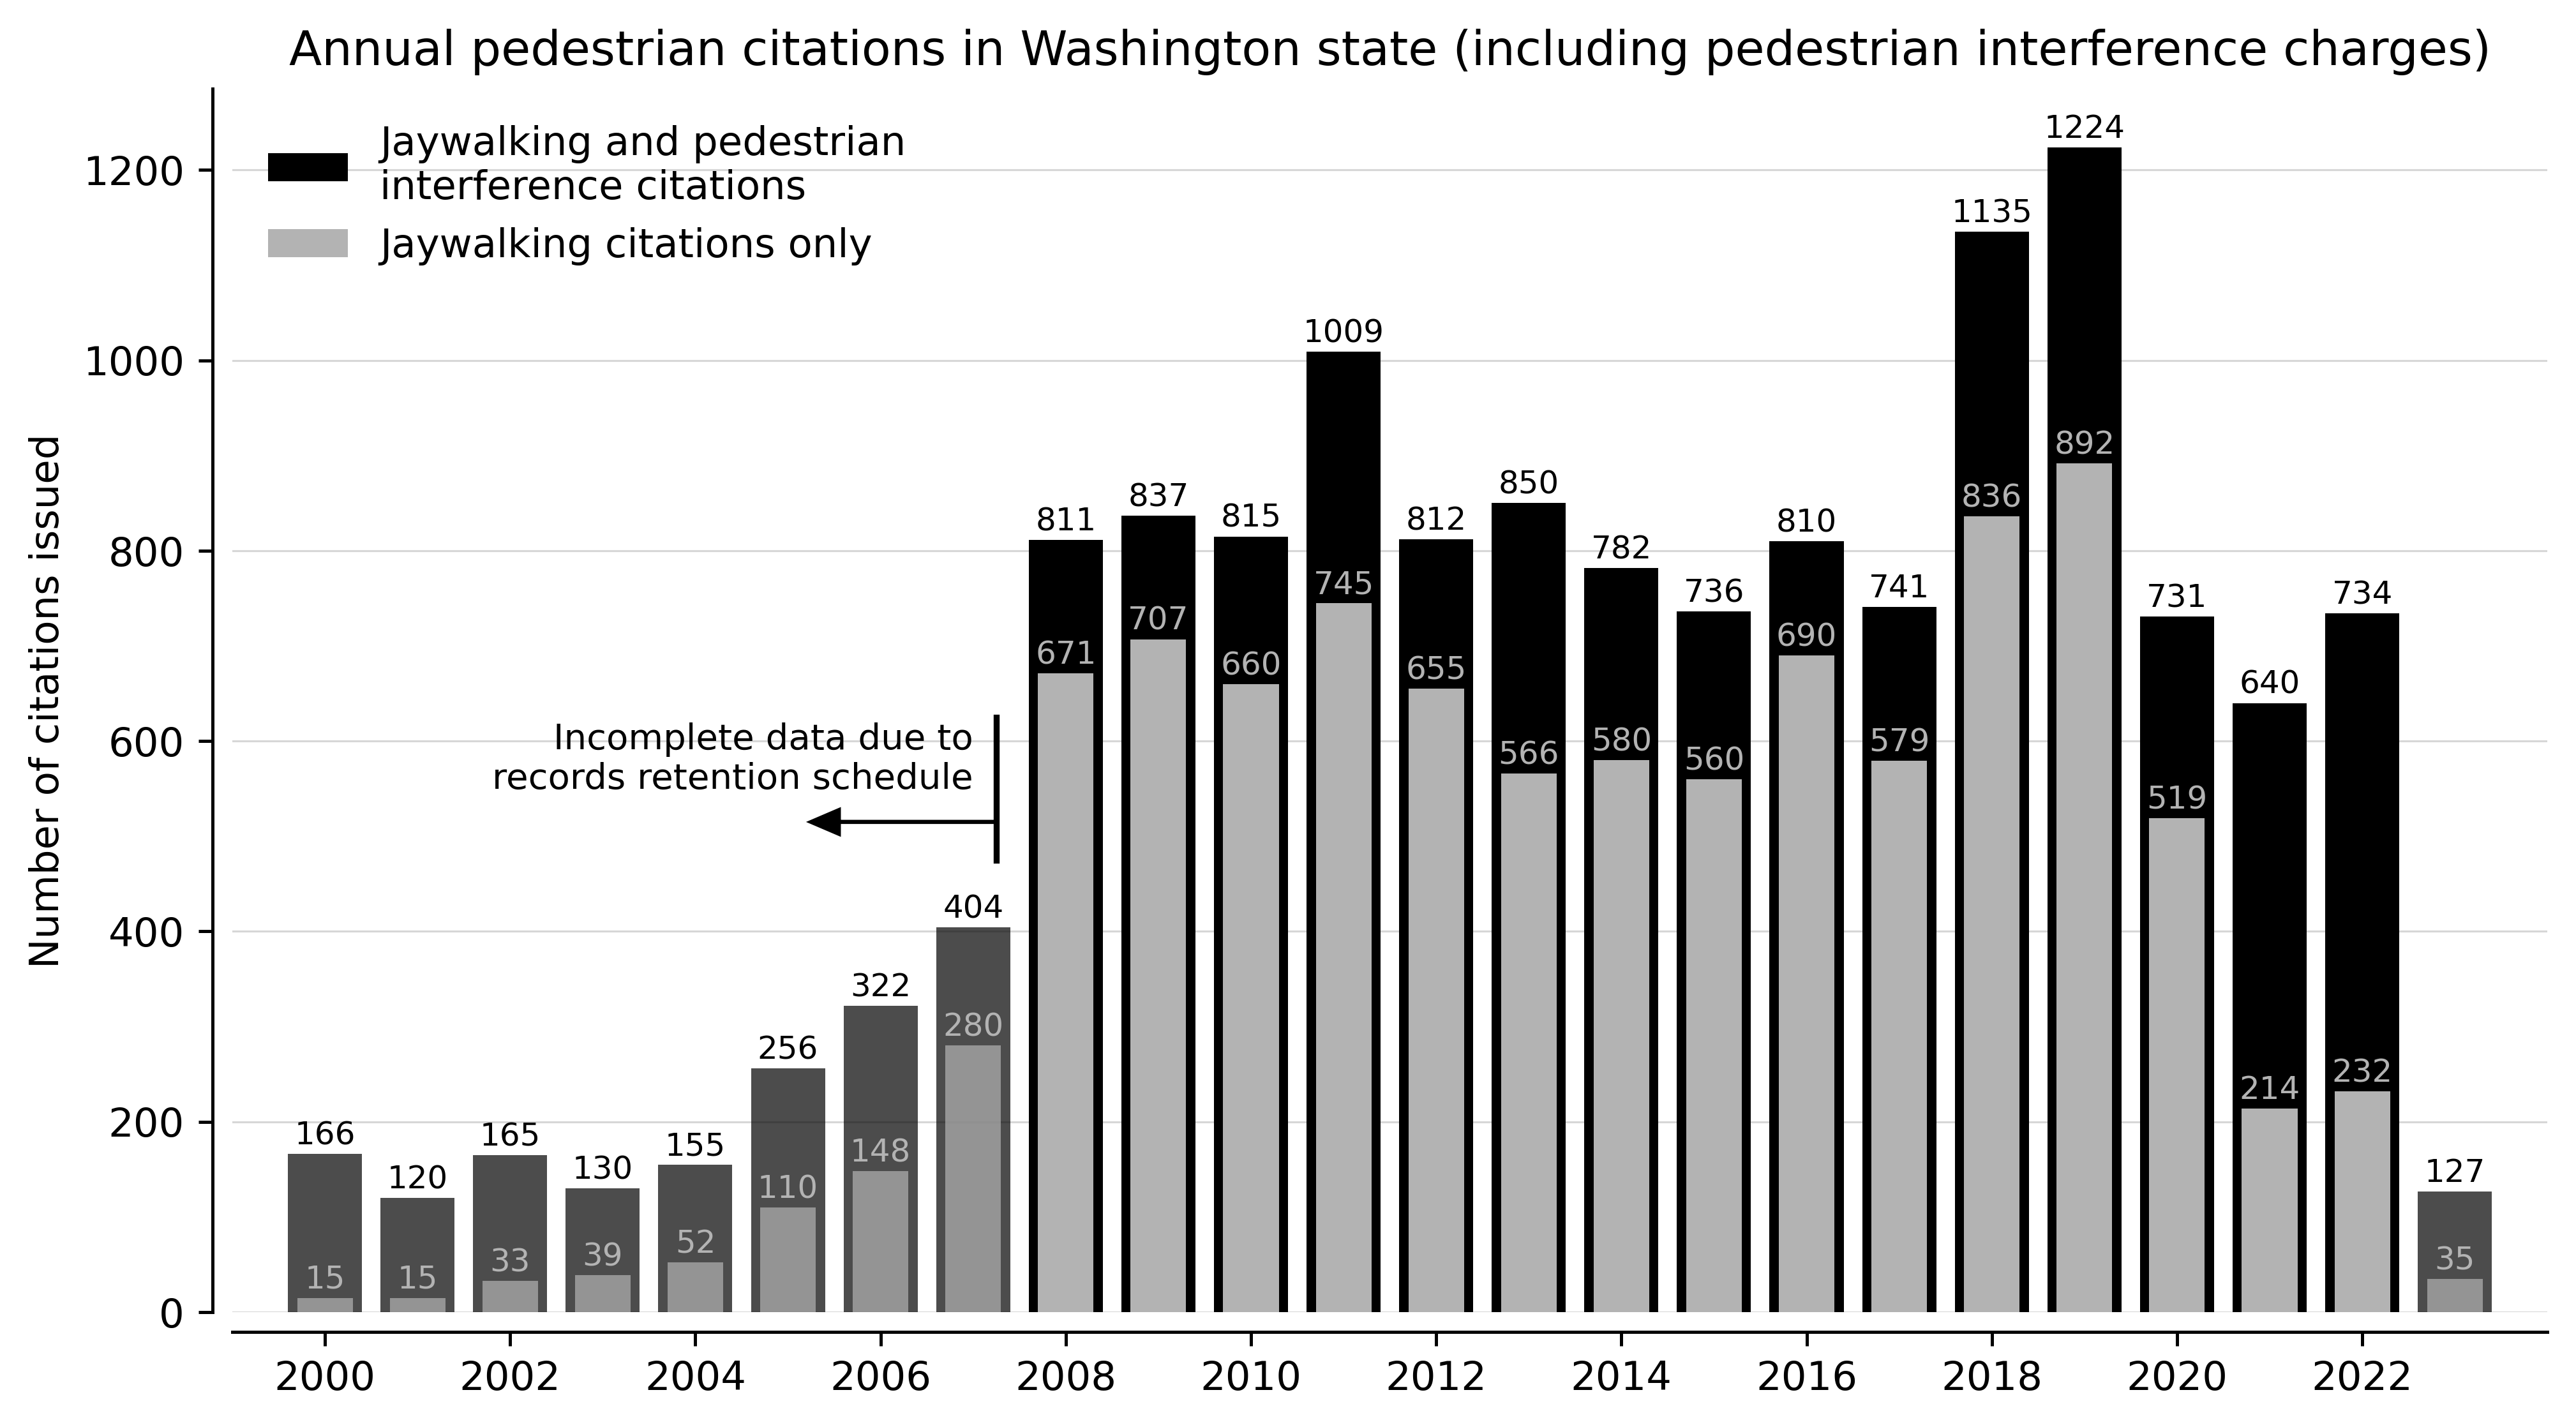

In [ ]:
# Volume of citations over time (by year) in WA state
time_series = aoc_extracted['Violation Date'].dt.year.value_counts().sort_index()
jay_mask = aoc_extracted['Jaywalking (roadway violations only)']
time_series_jay = aoc_extracted[jay_mask]['Violation Date'].dt.year.value_counts().sort_index()
time_series_int = aoc_extracted[~jay_mask]['Violation Date'].dt.year.value_counts().sort_index()

plt.figure(figsize=(9,5),facecolor='w',dpi=450)
plt.grid(axis='y',lw=0.5,alpha=0.5,zorder=1)

plt.bar(time_series.loc[2008:2022].index,time_series.loc[2008:2022].values,color='k',
        zorder=2,label='Jaywalking and pedestrian\ninterference citations')
for i, count in enumerate(time_series.loc[2008:2022]):
    plt.text(time_series.loc[2008:2022].index[i],count+10,str(count),c='k',
             size=8,fontweight='regular',horizontalalignment='center')

plt.bar(time_series_jay.loc[2008:2022].index,time_series_jay.loc[2008:2022].values,
        width=0.6,color='0.7',zorder=2,label='Jaywalking citations only')
for i, count in enumerate(time_series_jay.loc[2008:2022]):
    plt.text(time_series_jay.loc[2008:2022].index[i],count+10,str(count),c='0.7',
             size=8,fontweight='regular',horizontalalignment='center')

plt.bar(time_series.loc[:2007].index,time_series.loc[:2007].values,
        color='k',alpha=0.7,zorder=2)
for i, count in enumerate(time_series.loc[:2007]):
    plt.text(time_series.loc[:2007].index[i],count+10,str(count),c='k',
             size=8,fontweight='regular',horizontalalignment='center')

plt.bar(time_series_jay.loc[:2007].index,time_series_jay.loc[:2007].values,
        width=0.6,color='0.7',alpha=0.7,zorder=2)
for i, count in enumerate(time_series_jay.loc[:2007]):
    plt.text(time_series_jay.loc[:2007].index[i],count+10,str(count),c='0.7',
             size=8,fontweight='regular',horizontalalignment='center')

plt.bar(time_series.loc[2023:].index,time_series.loc[2023:].values,
        color='k',alpha=0.7,zorder=2)
for i, count in enumerate(time_series.loc[2023:]):
    plt.text(time_series.loc[2023:].index[i],count+10,str(count),c='k',
             size=8,fontweight='regular',horizontalalignment='center')

plt.bar(time_series_jay.loc[2023:].index,time_series_jay.loc[2023:].values,
        width=0.6,color='0.7',alpha=0.7,zorder=2)
for i, count in enumerate(time_series_jay.loc[2023:]):
    plt.text(time_series_jay.loc[2023:].index[i],count+10,str(count),c='0.7',
             size=8,fontweight='regular',horizontalalignment='center')

plt.xticks(np.arange(2000,2024,2))
plt.xlim([1999,2024])
plt.text(2007,550,'Incomplete data due to\nrecords retention schedule',c='k',
         fontsize=9,horizontalalignment='right')
plt.plot([2007.25,2007.25],[475,625],c='k')
plt.arrow(2007.25,515,-2,0,length_includes_head=True,head_width=25,head_length=0.3,
          edgecolor='k',facecolor='k')
plt.legend(frameon=False)
plt.ylabel('Number of citations issued')
plt.title('Annual pedestrian citations in Washington state (including pedestrian interference charges)')
plt.tight_layout()
drop_spines()
plt.savefig(current_results_dir + 'WA AOC time series.pdf',bbox_inches='tight')

In [ ]:
# Calculate fraction of all citations issued under RCWs vs. municipal codes
frac_RCW = 100 * (aoc_extracted[jay_mask]['Authority'].value_counts()['RCW'] / len(aoc_extracted[jay_mask]))
print('{0:.2f}% of all jaywalking citations have been issued under RCWs, rather than municipal codes'.format(frac_RCW))
frac_RCW_int = 100 * (aoc_extracted[~jay_mask]['Authority'].value_counts()['RCW'] / len(aoc_extracted[jay_mask]))
print('{0:.2f}% of all [ambiguous potential] pedestrian interference citations have been issued under RCWs, rather than municipal codes'.format(frac_RCW_int))

90.49% of all jaywalking citations have been issued under RCWs, rather than municipal codes
0.22% of all [ambiguous potential] pedestrian interference citations have been issued under RCWs, rather than municipal codes


In [ ]:
aoc_jay = aoc_extracted[aoc_extracted['Jaywalking (roadway violations only)']]
print('Fraction of all jaywalking citations issued by PDs:',100*aoc_jay['LEA'].str.contains('PD').sum()/len(aoc_jay))
print('Fraction of all jaywalking citations issued by Sheriffs:',100*aoc_jay['LEA'].str.contains('Sheriff').sum()/len(aoc_jay))

Fraction of all jaywalking citations issued by PDs: 80.44340486118173
Fraction of all jaywalking citations issued by Sheriffs: 11.35970710871555


In [ ]:
wsp = aoc_extracted[np.logical_and(aoc_extracted['LEA'] == 'Washington State Patrol',
                                   aoc_extracted['Jaywalking (roadway violations only)'])]
print('Total jaywalking citations issued by WA State Patrol:',len(wsp))
print('Fraction of all jaywalking citations issued by WA State Patrol:',100*aoc_jay['LEA'].str.contains('Washington State Patrol').sum()/len(aoc_jay))
print('WA State Patrol share (column 1) of total jaywalking citations (column 2):')
pd.DataFrame(data=[wsp['County'].value_counts() / aoc_jay['County'].value_counts(),
                   aoc_jay['County'].value_counts()]).transpose()

Total jaywalking citations issued by WA State Patrol: 802
Fraction of all jaywalking citations issued by WA State Patrol: 8.156208685040172
WA State Patrol share (column 1) of total jaywalking citations (column 2):


County  County
Adams         0.666667     6.0
Asotin             NaN     2.0
Benton        0.094891   137.0
Chelan        0.140000    50.0
Clallam       0.400000    20.0
Clark         0.098086   418.0
Columbia           NaN     1.0
Cowlitz       0.066667   120.0
Douglas       0.120000    25.0
Franklin      0.020305   197.0
Grant         0.130435    23.0
Grays Harbor  0.036697   109.0
Island        0.083333    12.0
Jefferson     0.333333     3.0
King          0.031198  3590.0
Kitsap        0.398406   251.0
Kittitas      1.000000     9.0
Klickitat     0.333333     3.0
Lewis         0.537736   106.0
Lincoln       0.666667     3.0
Mason         0.225000    40.0
Okanogan      0.461538    13.0
Pacific            NaN     5.0
Pierce        0.079334  1021.0
Skagit        0.654545    55.0
Snohomish     0.081340  1672.0
Spokane       0.058581  1212.0
Stevens       0.500000     2.0
Thurston      0.180147   272.0
Unknown            NaN     6.0
Wahkiakum          NaN     1.0
Walla Walla        NaN     6.0
Whatcom       0.102151   186.0
Whitman            NaN     4.0
Yakima        0.063241   253.0

Note: Caveat of this data is that it excludes pedestrian interference charges for which there
is ambiguity over whether pedestrian was interfering with roadway or sidewalk traffic.


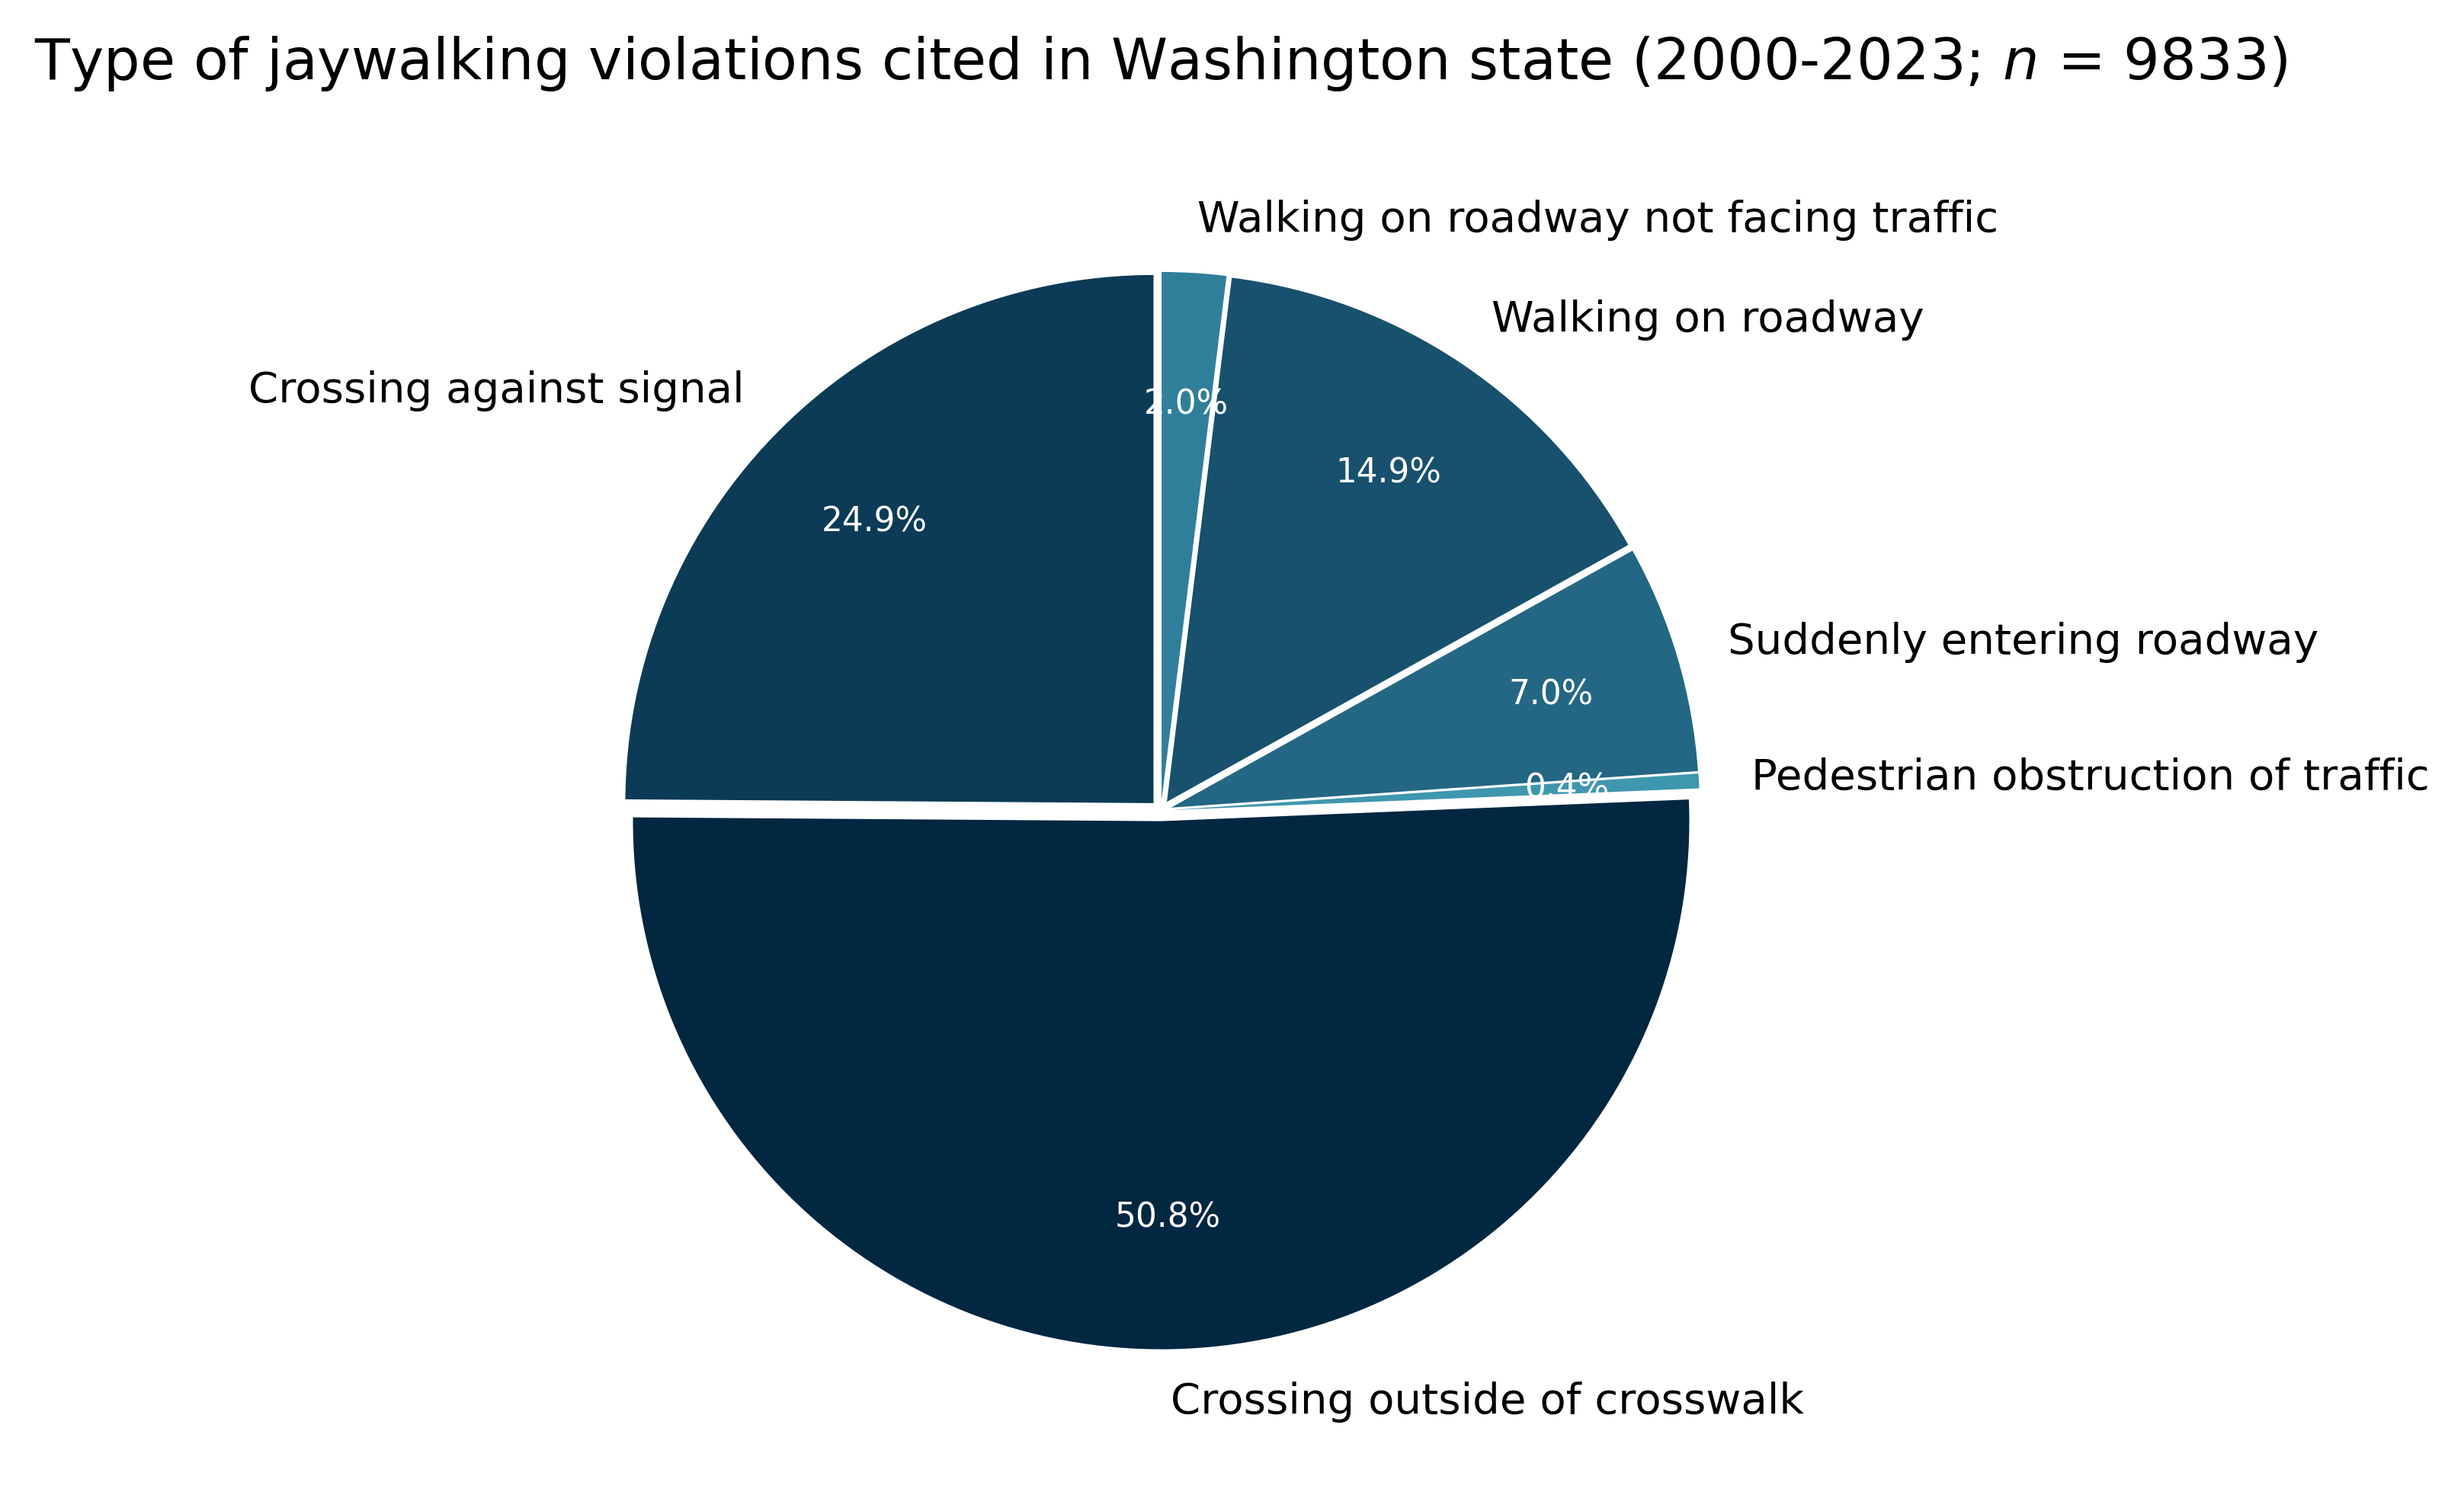

In [ ]:
# Types of jaywalking violations cited in WA state
jay_mask = aoc_extracted['Jaywalking (roadway violations only)']
categories = aoc_extracted[jay_mask]['Violation Category'].value_counts().sort_index()

def autopct(percent): return ('%.1f%%' % percent) if percent >= 0.5 else ('%.1f%%' % percent)
colors = np.flip(np.array(['#022741','#0b3b57','#17516d','#236784','#307f9a','#3e97af']))
colors = colors[[4,5,0,2,3,1]]
plt.figure(figsize=(10,5),facecolor='w',dpi=450)
wedges, labels, autopct_out = plt.pie(categories.values,labels=categories.index,
                                      explode=np.tile(0.02,len(categories)),
                                      labeldistance=1.10,autopct=autopct,
                                      pctdistance=0.75,colors=colors,
                                      startangle=90)
for lab in labels: lab.set_fontsize(9)
for pct in autopct_out: pct.set_fontsize(7); pct.set_color('w')
plt.title('Type of jaywalking violations cited in Washington state ({0}-{1}; $n$ = {2})'\
          .format(aoc_extracted[jay_mask]['Violation Date'].dt.year.min(),
                  aoc_extracted[jay_mask]['Violation Date'].dt.year.max(),
                  categories.sum()),pad=15);
plt.savefig(current_results_dir + 'WA AOC jaywalking categories.pdf',bbox_inches='tight')
print('Note: Caveat of this data is that it excludes pedestrian interference charges for which there\nis ambiguity over whether pedestrian was interfering with roadway or sidewalk traffic.')

In [ ]:
# Overall gender distribution of jaywalking stops and citations
jay_mask = aoc_extracted['Jaywalking (roadway violations only)']
print('Gender distribution of jaywalking citations:')
display(aoc_extracted[jay_mask]['Gender Code'].value_counts(normalize=True))

print('\nGender distribution of jaywalking stops:')
display(contacts[mask_stop]['Subject - gender/sex'].value_counts(normalize=True))
print('\nFraction of police stop records with gender recorded:',
      1-contacts[mask_stop]['Subject - gender/sex'].value_counts(normalize=True,dropna=False)[np.NaN])

Gender distribution of jaywalking citations:


M    0.795586
F    0.199837
U    0.004576
Name: Gender Code, dtype: float64


Gender distribution of jaywalking stops:


Male      0.8125
Female    0.1875
Name: Subject - gender/sex, dtype: float64


Fraction of police stop records with gender recorded: 0.5338276181649675


## Racial disparity and geographic analyses

Note: Caveat of this data is that it excludes pedestrian interference charges for which there
is ambiguity over whether pedestrian was interfering with roadway or sidewalk traffic.


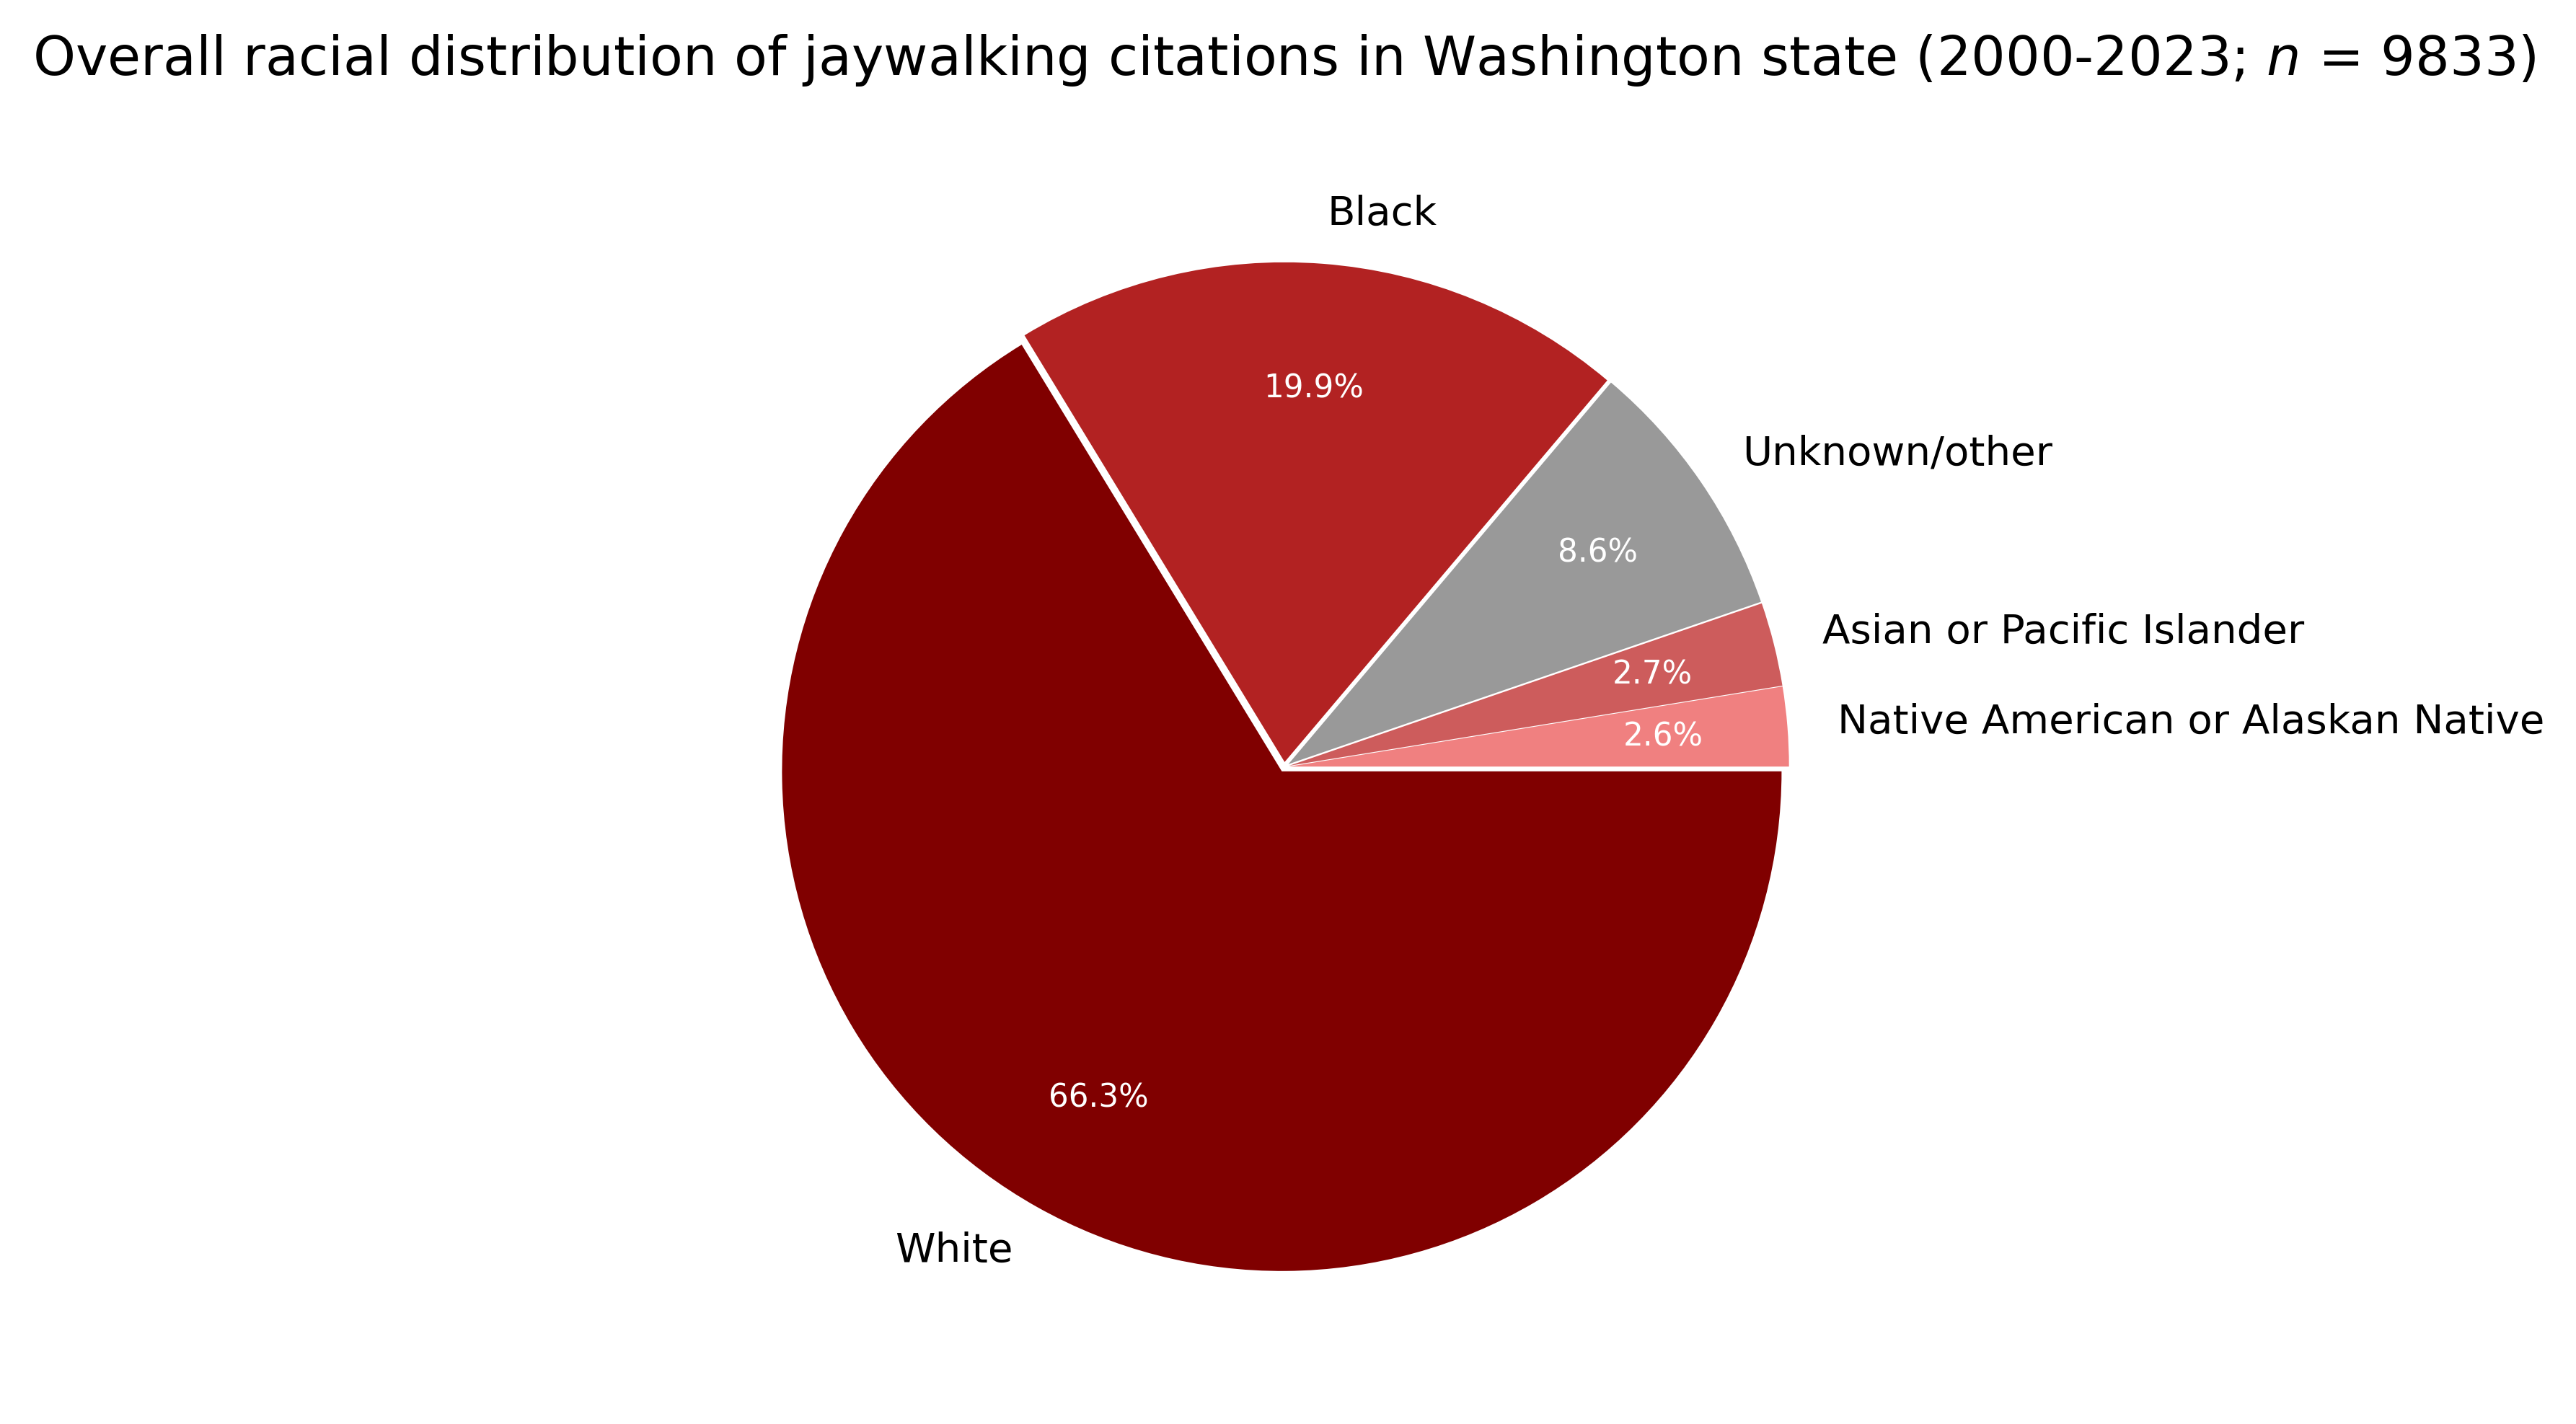

In [ ]:
# Overall racial distribution of jaywalking citations issued in WA state

jay_mask = aoc_extracted['Jaywalking (roadway violations only)']
race_overall = aoc_extracted[jay_mask]['Race Code'].value_counts().sort_values()
race_overall.rename(index={'A':'Asian or Pacific Islander',
                           'B':'Black','W':'White','U':'Unknown/other',
                           'I':'Native American or Alaskan Native'},inplace=True)

def autopct(percent): return ('%.1f%%' % percent)
colors = ['lightcoral','indianred','0.6','firebrick','maroon']
plt.figure(figsize=(10,5),facecolor='w',dpi=450)
wedges, labels, autopct_out = plt.pie(race_overall.values,labels=race_overall.index,
                                      explode=np.tile(0.01,len(race_overall)),
                                      labeldistance=1.10,autopct=autopct,
                                      pctdistance=0.75,colors=colors,
                                      startangle=0)
for lab in labels: lab.set_fontsize(9)
for pct in autopct_out: pct.set_fontsize(7); pct.set_color('w')
plt.title('Overall racial distribution of jaywalking citations in Washington state ({0}-{1}; $n$ = {2})'\
          .format(aoc_extracted[jay_mask]['Violation Date'].dt.year.min(),
                  aoc_extracted[jay_mask]['Violation Date'].dt.year.max(),
                  categories.sum()),pad=15);
plt.savefig(current_results_dir + 'WA AOC jaywalking overall racial distribution.pdf',bbox_inches='tight')
print('Note: Caveat of this data is that it excludes pedestrian interference charges for which there\nis ambiguity over whether pedestrian was interfering with roadway or sidewalk traffic.')

In [ ]:
# Test for differences when using a broader inclusion criteria for racial distribution of police stops
# (Include all contact records, including those from agencies that only provided citation data)
mask_demo_avail = mask_stop & \
  ~contacts['Subject - reported race'].isnull() & \
  ~contacts['White'].isnull()
print('Number of stop records that would be used if race statistic were\nnot limited to strictly representative stop records:',mask_demo_avail.sum())

# Compare racial distribution with broader inclusion criteria
race_stops = contacts.loc[mask_demo_avail,'Subject - reported race'].value_counts(normalize=True).sort_values()
race_stops.rename(index={'Asian':'Asian or Pacific Islander',
                          'Black':'Black','White':'White','Unknown':'Unknown/other',
                          'Native American/Alaskan Native':'Native American or Alaskan Native'},inplace=True)
print('\nOverall racial distribution of jaywalking POLICE STOPS with broader inclusion criteria:')
display(race_stops)

# ... vs. expected distribution from composited Census data
race_stops_expected = \
  contacts.loc[mask_demo_avail,['White','Black','Asian or Pacific Islander',
                                'Native American or Alaskan Native','Other']]\
                                .mean(axis=0).rename(index={'Other':'Unknown/other'})
print('\nExpected distribution from composited Census data:')
display(race_stops_expected)

Number of stop records that would be used if race statistic were
not limited to strictly representative stop records: 372

Overall racial distribution of jaywalking POLICE STOPS with broader inclusion criteria:


Asian or Pacific Islander            0.010753
Native American or Alaskan Native    0.024194
Unknown/other                        0.026882
Black                                0.255376
White                                0.682796
Name: Subject - reported race, dtype: float64


Expected distribution from composited Census data:


White                                0.672634
Black                                0.075546
Asian or Pacific Islander            0.133022
Native American or Alaskan Native    0.021562
Unknown/other                        0.097237
dtype: float64

In [ ]:
# Compare overall racial distribution of jaywalking POLICE STOPS
mask_demo_avail = mask_stop & \
  ~contacts['Subject - reported race'].isnull() & \
  ~contacts['White'].isnull() & \
  sufficient_mask('Sufficient for analysis - stop race')

contacts.loc[mask_demo_avail,
             'Included in analysis: race'] = True  # Flag for final tabulation

race_stops = contacts.loc[mask_demo_avail,'Subject - reported race'].value_counts(normalize=True).sort_values()
race_stops.rename(index={'Asian':'Asian or Pacific Islander',
                           'Black':'Black','White':'White','Unknown':'Unknown/other',
                           'Native American/Alaskan Native':'Native American or Alaskan Native'},inplace=True)
print('Number of stop records used in race statistic:',mask_demo_avail.sum())
print('Overall racial distribution of jaywalking POLICE STOPS')
display(race_stops)

# ... vs. expected distribution from composited Census data
race_stops_expected = \
  contacts.loc[mask_demo_avail,['White','Black','Asian or Pacific Islander',
                                'Native American or Alaskan Native','Other']]\
                                .mean(axis=0).rename(index={'Other':'Unknown/other'})
print('\nExpected distribution from composited Census data')
display(race_stops_expected)

# Compare overall racial distribution of jaywalking CITATIONS issued in WA state
jay_mask = aoc_extracted['Jaywalking (roadway violations only)']
race_citations = aoc_extracted.loc[jay_mask,'Race Code'].value_counts(normalize=True).sort_values()
race_citations.rename(index={'A':'Asian or Pacific Islander',
                             'B':'Black','W':'White','U':'Unknown/other',
                             'I':'Native American or Alaskan Native'},inplace=True)
print('\nOverall racial distribution of jaywalking CITATIONS in WA')
display(race_citations)

# ... vs. expected distribution from composited Census data
race_citations_expected = \
  aoc_extracted.loc[jay_mask,['White','Black','Asian or Pacific Islander',
                              'Native American or Alaskan Native','Other']]\
                              .mean(axis=0).rename(index={'Other':'Unknown/other'})
print('\nExpected distribution from composited Census data')
display(race_citations_expected)

# Compare overall ethnicity distribution of jaywalking CITATIONS issued in WA state
eth_citations = aoc_extracted.loc[jay_mask,'Ethnicity Code'].value_counts(normalize=True).sort_values()
eth_citations.rename(index={'H':'Hispanic/Latino',
                            'N':'Non-Hispanic/Latino',
                            'U':'Unknown/other'},inplace=True)
print('\nOverall ethnicity distribution of jaywalking CITATIONS in WA (within all categories, not just White)')
display(eth_citations)

# ... vs. expected ethnicity distribution from composited Census data
eth_citations_expected = \
  aoc_extracted.loc[jay_mask,['White (Non-Hispanic/Latino)','White (Hispanic/Latino)']].mean(axis=0)
print('\nExpected distribution from composited Census data (within White category only)')
display(eth_citations_expected)

Number of stop records used in race statistic: 211
Overall racial distribution of jaywalking POLICE STOPS


Asian or Pacific Islander            0.004739
Native American or Alaskan Native    0.009479
Unknown/other                        0.014218
Black                                0.270142
White                                0.701422
Name: Subject - reported race, dtype: float64


Expected distribution from composited Census data


White                                0.716664
Black                                0.058365
Asian or Pacific Islander            0.125251
Native American or Alaskan Native    0.021431
Unknown/other                        0.078289
dtype: float64


Overall racial distribution of jaywalking CITATIONS in WA


Native American or Alaskan Native    0.025628
Asian or Pacific Islander            0.027052
Unknown/other                        0.085630
Black                                0.198820
White                                0.662870
Name: Race Code, dtype: float64


Expected distribution from composited Census data


White                                0.664587
Black                                0.075219
Asian or Pacific Islander            0.140952
Native American or Alaskan Native    0.022918
Unknown/other                        0.096324
dtype: float64


Overall ethnicity distribution of jaywalking CITATIONS in WA (within all categories, not just White)


R                      0.000102
Hispanic/Latino        0.051968
Non-Hispanic/Latino    0.052883
Unknown/other          0.895047
Name: Ethnicity Code, dtype: float64


Expected distribution from composited Census data (within White category only)


White (Non-Hispanic/Latino)    0.611013
White (Hispanic/Latino)        0.053574
dtype: float64

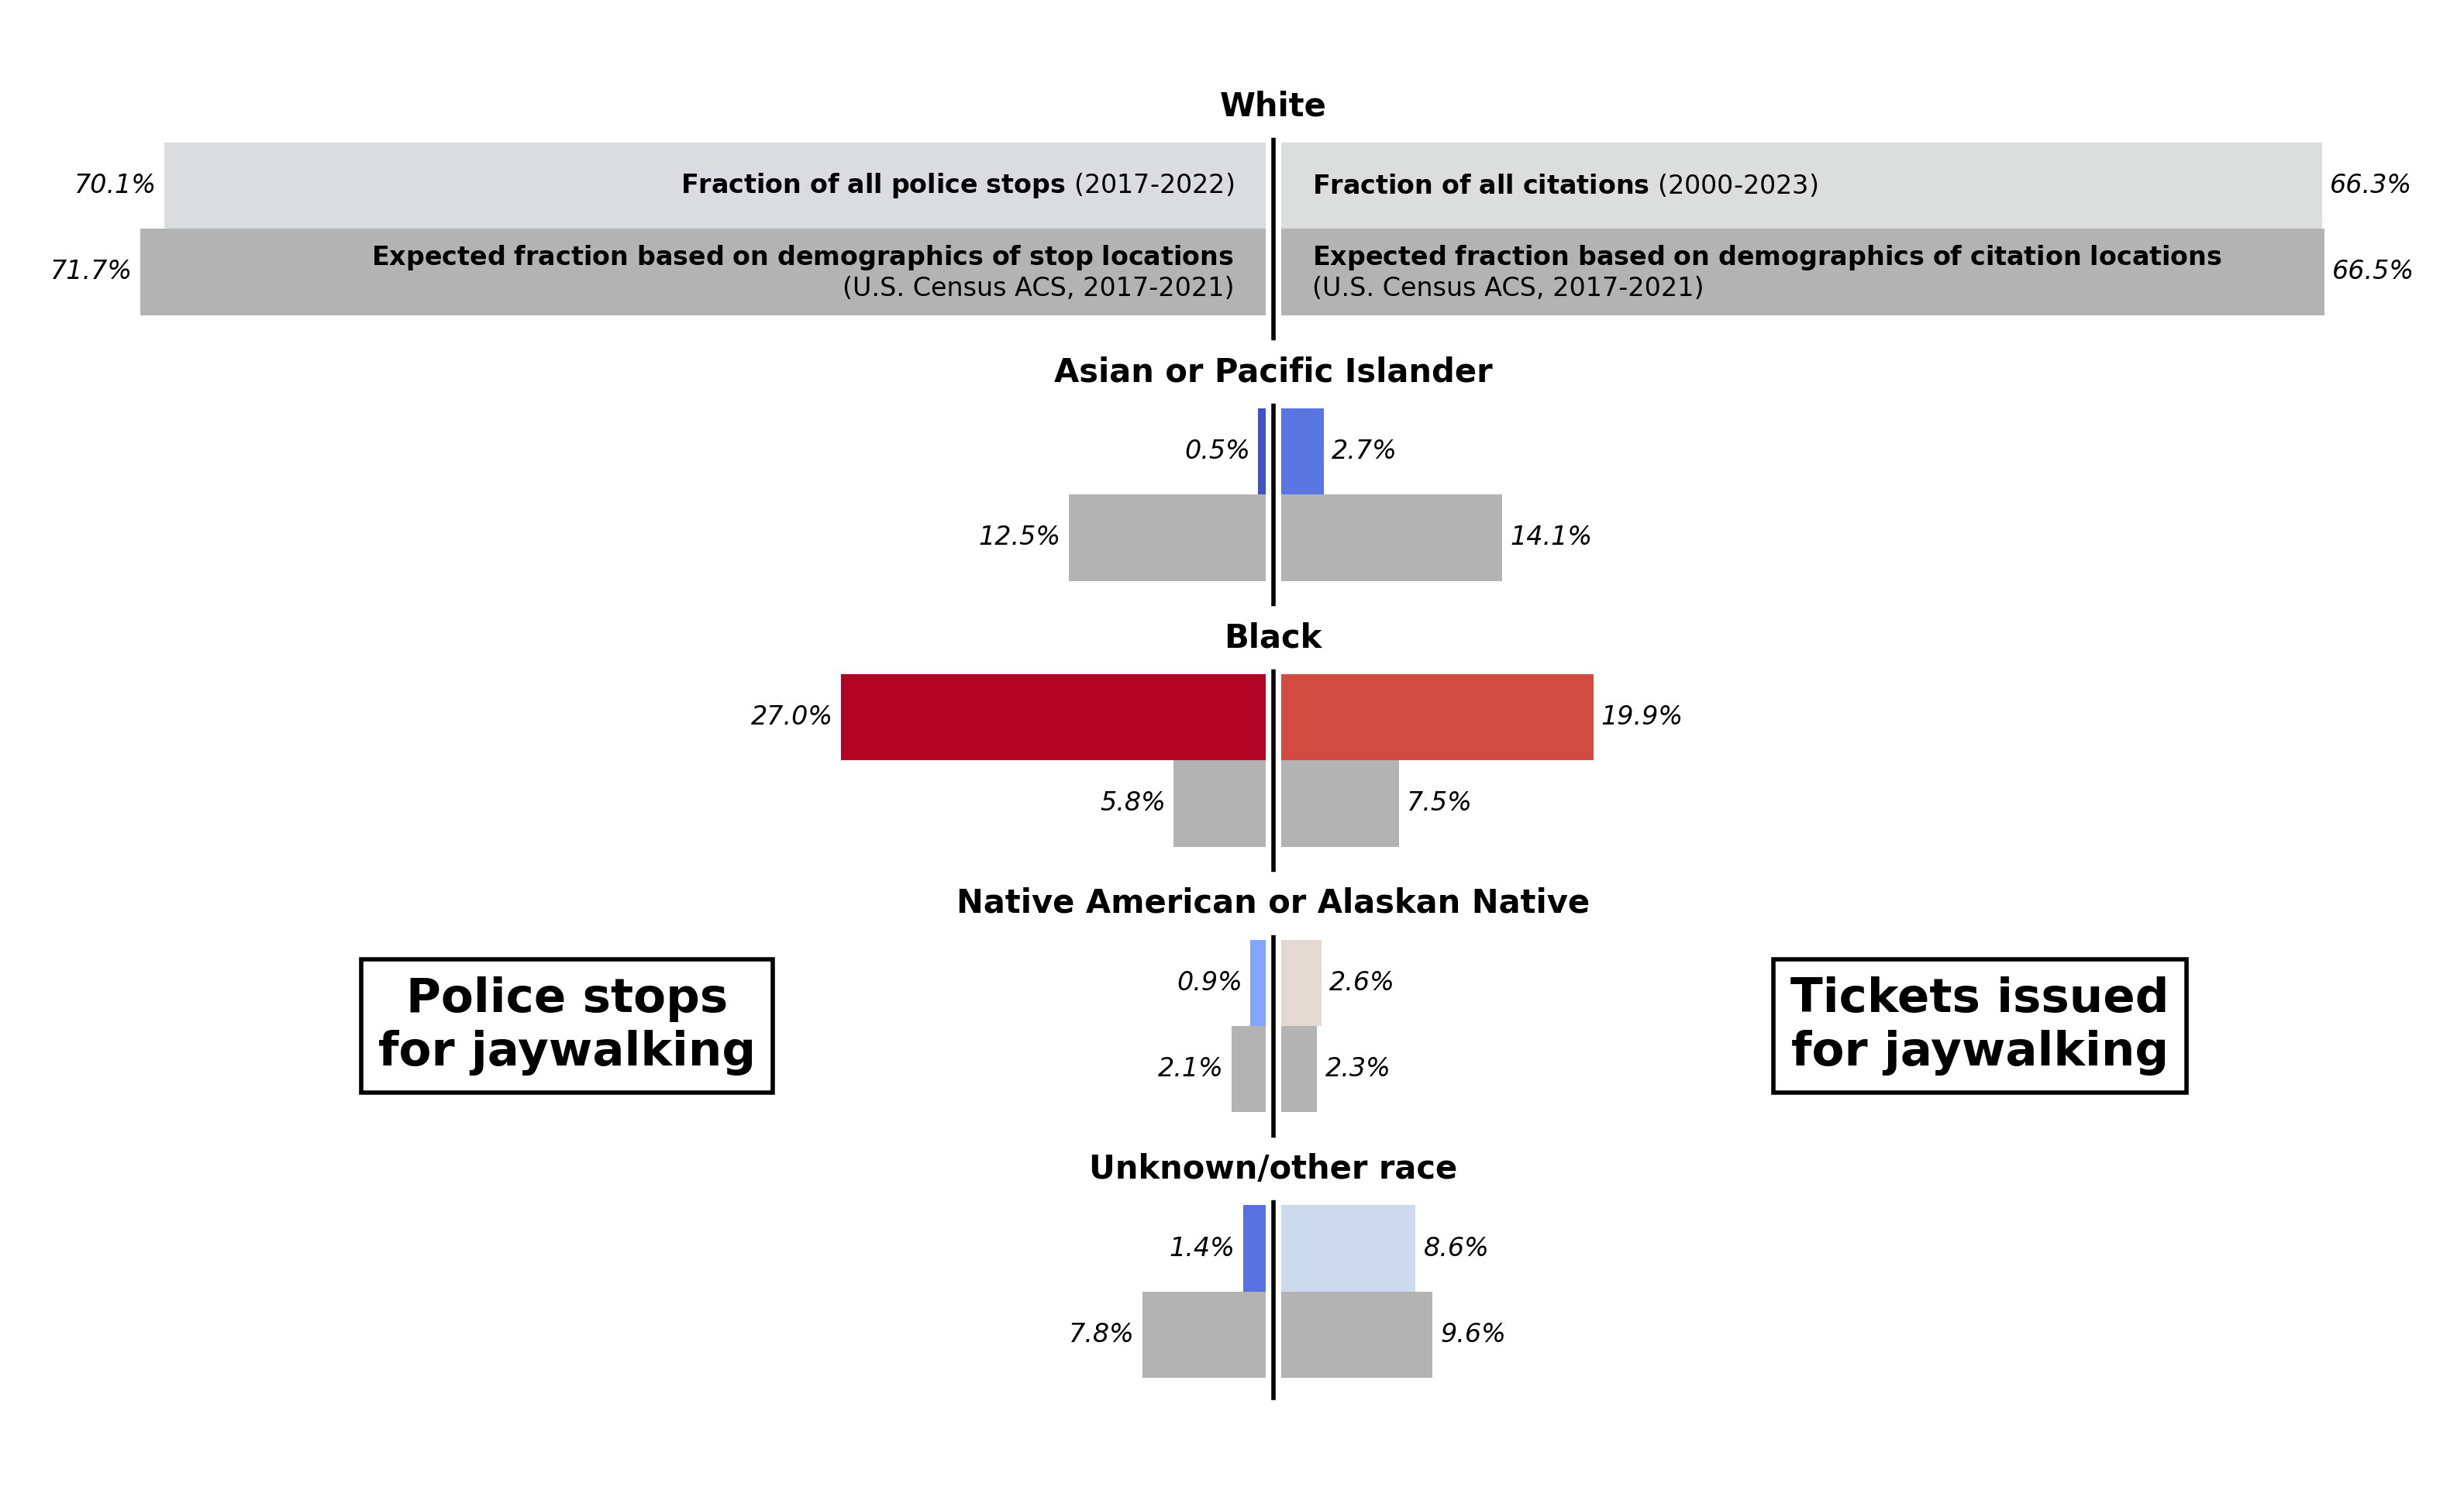

In [ ]:
plt.figure(figsize=(10,6),dpi=400,facecolor='w')

label_order = ['Unknown/other','Native American or Alaskan Native','Black',
               'Asian or Pacific Islander','White']
norm = mcolors.TwoSlopeNorm(vcenter=1.0,vmin=0.0,vmax=3.0)
cmap = plt.get_cmap('coolwarm')

for idx, label in enumerate(label_order):
  plt.barh(idx,race_citations[label],height=0.325,left=0.005,
           color=cmap(norm(race_citations[label]/race_citations_expected[label])),align='edge')
  plt.barh(idx,race_citations_expected[label],height=-0.325,left=0.005,
           color='0.7',align='edge')
  plt.barh(idx,-1*race_stops[label],height=0.325,left=-0.005,
           color=cmap(norm(race_stops[label]/race_stops_expected[label])),align='edge')
  plt.barh(idx,-1*race_stops_expected[label],height=-0.325,left=-0.005,
           color='0.7',align='edge')
  plt.text(race_citations[label]+0.01,idx+0.162,
           '{0:.1f}%'.format(100*race_citations[label]),
           size=6,ha='left',va='center',style='italic')
  plt.text(race_citations_expected[label]+0.01,idx-0.162,
           '{0:.1f}%'.format(100*race_citations_expected[label]),
           size=6,ha='left',va='center',style='italic')
  plt.text(-1*race_stops[label]-0.01,idx+0.162,
           '{0:.1f}%'.format(100*race_stops[label]),
           size=6,ha='right',va='center',style='italic')
  plt.text(-1*race_stops_expected[label]-0.01,idx-0.162,
           '{0:.1f}%'.format(100*race_stops_expected[label]),
           size=6,ha='right',va='center',style='italic')
  if label == 'Unknown/other': label_mod = 'Unknown/other race'
  else:                        label_mod = label
  plt.text(0,idx+0.4,label_mod,c='k',backgroundcolor='w',size=7.5,
           weight='bold',ha='center',va='bottom')

plt.plot([0,0],[-0.4,len(label_order)-0.5],c='k',ls='-',lw=1.0)
plt.text(0.025,4+0.325/2,r'$\bf{Fraction~of~all~citations}$ (2000-2023)',
         size=6,ha='left',va='center')
plt.text(-0.025,4+0.325/2,r'$\bf{Fraction~of~all~police~stops}$ (2017-2022)',
         size=6,ha='right',va='center')
plt.text(0.025,4-0.325/2,r'$\bf{Expected~fraction~based~on~demographics~of~citation~locations}$' + '\n(U.S. Census ACS, 2017-2021)',
         size=6,ha='left',va='center')
plt.text(-0.025,4-0.325/2,r'$\bf{Expected~fraction~based~on~demographics~of~stop~locations}$' + '\n(U.S. Census ACS, 2017-2021)',
         size=6,ha='right',va='center')
plt.text(0.45,1.0,'Tickets issued\nfor jaywalking',size=11,weight='bold',
         ha='center',va='center',bbox={'facecolor':'w','linewidth':1})
plt.text(-0.45,1.0,'Police stops\nfor jaywalking',size=11,weight='bold',
         ha='center',va='center',bbox={'facecolor':'w','linewidth':1})

plt.xticks([]); plt.yticks([])
plt.gca().spines['top'].set_visible(False); plt.gca().spines['bottom'].set_visible(False)
plt.gca().spines['left'].set_visible(False); plt.gca().spines['right'].set_visible(False)
plt.savefig(current_results_dir + 'Citation and police stop statewide racial demographics.pdf',bbox_inches='tight')

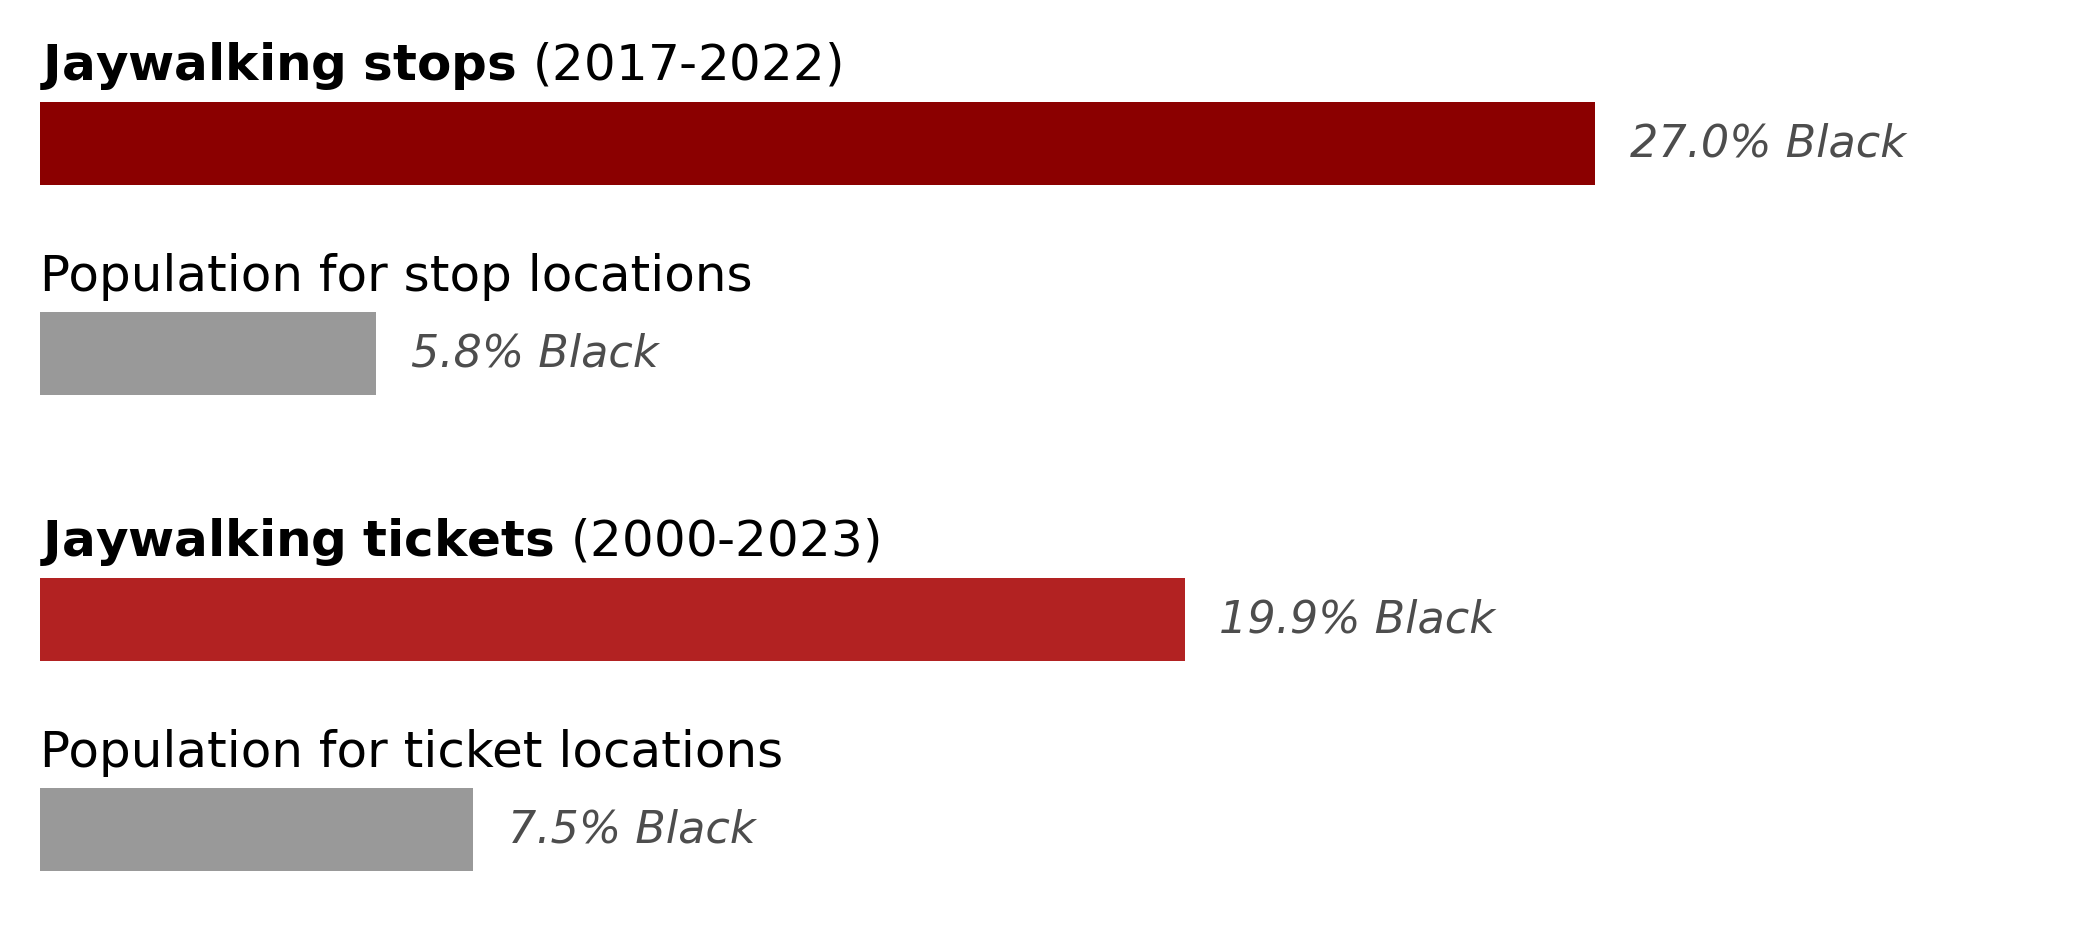

In [ ]:
poster_format = False   # if True, size for report; if False, size for poster

if poster_format:
  pf = 0
  figsize = (5.8,3.65)
else:
  pf = -2
  figsize = (6.5,2.75)
plt.figure(figsize=figsize,dpi=400,facecolor='w')
delta_y = 0.38
delta_y_bar = 0.14
bar_h = 0.15
plt.text(0,0,r'$\bf{Jaywalking~stops}$ (2017-2022)',size=11+pf,ha='left',va='center')
plt.barh(0-delta_y_bar,race_stops['Black'],height=bar_h,align='center',color='darkred',zorder=1)
plt.text(race_stops['Black']+0.006,0-delta_y_bar,'{0:.1f}% Black'.format(100*race_stops['Black']),
         size=10+pf,ha='left',va='center',style='italic',color='0.3')
plt.text(0,0-delta_y,r'Population for stop locations',size=11+pf,ha='left',va='center')
plt.barh(0-delta_y-delta_y_bar,race_stops_expected['Black'],height=bar_h,align='center',color='0.6',zorder=1)
plt.text(race_stops_expected['Black']+0.006,0-delta_y-delta_y_bar,'{0:.1f}% Black'.format(100*race_stops_expected['Black']),
         size=10+pf,ha='left',va='center',style='italic',color='0.3')
plt.text(0,-0.1-2*delta_y,r'$\bf{Jaywalking~tickets}$ (2000-2023)',size=11+pf,ha='left',va='center')
plt.barh(-0.1-2*delta_y-delta_y_bar,race_citations['Black'],height=bar_h,align='center',color='firebrick',zorder=1)
plt.text(race_citations['Black']+0.006,-0.1-2*delta_y-delta_y_bar,'{0:.1f}% Black'.format(100*race_citations['Black']),
         size=10+pf,ha='left',va='center',style='italic',color='0.3')
plt.text(0,-0.1-3*delta_y,r'Population for ticket locations',size=11+pf,ha='left',va='center')
plt.barh(-0.1-3*delta_y-delta_y_bar,race_citations_expected['Black'],height=bar_h,align='center',color='0.6',zorder=1)
plt.text(race_citations_expected['Black']+0.006,-0.1-3*delta_y-delta_y_bar,'{0:.1f}% Black'.format(100*race_citations_expected['Black']),
         size=10+pf,ha='left',va='center',style='italic',color='0.3')
plt.xlim([0,0.35])

plt.xticks([]); plt.yticks([])
plt.gca().spines['top'].set_visible(False); plt.gca().spines['bottom'].set_visible(False)
plt.gca().spines['left'].set_visible(False); plt.gca().spines['right'].set_visible(False)
plt.savefig(current_results_dir + 'Citation and police stop statewide racial demographics - Black inset.pdf',bbox_inches='tight')

In [ ]:
# Compare overall racial distribution by county
county_race_totals = aoc_extracted[jay_mask].pivot_table(index=['County'],columns='Race Code',aggfunc='size',fill_value=0)
county_totals = county_race_totals.sum(axis=1)
county_race_percents = county_race_totals.divide(county_totals,axis=0)
county_mask_insig = (county_totals <= 25) ### NOTE: set significance threshold of >25 citations per county
county_race_percents.loc[county_mask_insig] = np.NaN
county_race_percents.rename(columns={'A':'Asian or Pacific Islander',
                                     'B':'Black','W':'White','U':'Unknown/other',
                                     'I':'Native American or Alaskan Native'},inplace=True)

# ... vs. expected distribution from composited Census data
county_race_percents_expected = \
  aoc_extracted.loc[jay_mask,['White','Black','Asian or Pacific Islander',
                              'Native American or Alaskan Native','Other','County']].groupby('County').mean()
county_race_percents_expected.rename(columns={'Other':'Unknown/other'},inplace=True)

# Calculate disparities
county_disparities = county_race_percents / county_race_percents_expected
county_disparities['Total citations'] = county_totals
display(county_disparities)

Asian or Pacific Islander     Black  \
County                                              
Adams                               NaN       NaN   
Asotin                              NaN       NaN   
Benton                         0.000000  2.553191   
Chelan                         2.570694  1.383126   
Clallam                             NaN       NaN   
Clark                          0.241612  2.482441   
Columbia                            NaN       NaN   
Cowlitz                        1.843561  0.674309   
Douglas                             NaN       NaN   
Franklin                       0.726744  3.562341   
Grant                               NaN       NaN   
Grays Harbor                   0.359712  2.097535   
Island                              NaN       NaN   
Jefferson                           NaN       NaN   
King                           0.193263  2.912236   
Kitsap                         0.245369  1.916215   
Kittitas                            NaN       NaN   
Klickitat                           NaN       NaN   
Lewis                          1.919386  1.179245   
Lincoln                             NaN       NaN   
Mason                          0.000000  1.481481   
Okanogan                            NaN       NaN   
Pacific                             NaN       NaN   
Pierce                         0.211453  2.627064   
Skagit                         0.000000  0.000000   
Snohomish                      0.112035  1.927000   
Spokane                        0.153100  2.868844   
Stevens                             NaN       NaN   
Thurston                       0.227169  1.487674   
Unknown                             NaN       NaN   
Wahkiakum                           NaN       NaN   
Walla Walla                         NaN       NaN   
Whatcom                        0.139831  2.004008   
Whitman                             NaN       NaN   
Yakima                         0.000000  3.239041   

              Native American or Alaskan Native  Unknown/other     White  \
County                                                                     
Adams                                       NaN            NaN       NaN   
Asotin                                      NaN            NaN       NaN   
Benton                                 0.777001       1.004150  1.023173   
Chelan                                 0.000000       0.999929  0.996738   
Clallam                                     NaN            NaN       NaN   
Clark                                  0.115128       0.817045  1.043112   
Columbia                                    NaN            NaN       NaN   
Cowlitz                                0.000000       1.154235  1.015509   
Douglas                                     NaN            NaN       NaN   
Franklin                               0.000000       0.878099  0.950610   
Grant                                       NaN            NaN       NaN   
Grays Harbor                           2.039681       0.473754  0.995858   
Island                                      NaN            NaN       NaN   
Jefferson                                   NaN            NaN       NaN   
King                                   0.739752       1.125085  0.957899   
Kitsap                                 0.000000       0.514374  1.112664   
Kittitas                                    NaN            NaN       NaN   
Klickitat                                   NaN            NaN       NaN   
Lewis                                  0.000000       0.720807  1.034308   
Lincoln                                     NaN            NaN       NaN   
Mason                                  0.000000       0.000000  1.289256   
Okanogan                                    NaN            NaN       NaN   
Pacific                                     NaN            NaN       NaN   
Pierce                                 0.996049       0.360193  0.912516   
Skagit                                 2.025658       0.708634  1.085187   


In [ ]:
# Compare overall racial distribution by city/town
city_race_totals = aoc_extracted[np.logical_and(jay_mask,~aoc_extracted['Jurisdiction'].str.contains('County'))]\
  .pivot_table(index=['Jurisdiction'],columns='Race Code',aggfunc='size',fill_value=0)
city_totals = city_race_totals.sum(axis=1)
city_race_percents = city_race_totals.divide(city_totals,axis=0)
city_mask_insig = (city_totals <= 10) ### NOTE: set significance threshold of >10 citations per city/town
city_race_percents.loc[city_mask_insig] = np.NaN
city_race_percents.rename(columns={'A':'Asian or Pacific Islander',
                                   'B':'Black','W':'White','U':'Unknown/other',
                                   'I':'Native American or Alaskan Native'},inplace=True)

# ... vs. expected distribution from composited Census data
city_race_percents_expected = \
  aoc_extracted.loc[np.logical_and(jay_mask,~aoc_extracted['Jurisdiction'].str.contains('County')),
   ['White','Black','Asian or Pacific Islander',
    'Native American or Alaskan Native','Other','Jurisdiction']].groupby('Jurisdiction').mean()
city_race_percents_expected.rename(columns={'Other':'Unknown/other'},inplace=True)

# Calculate Black citation disparities
city_disparities = city_race_percents / city_race_percents_expected
city_disparities['Total citations'] = city_totals
display(city_disparities['Black'].dropna())

Jurisdiction
Aberdeen             1.774098
Auburn               1.785714
Bellevue             6.031883
Bellingham           1.976285
Bonney Lake          3.289474
Bremerton            2.175633
Burien               1.838235
Centralia            1.307190
Covington            5.050505
Des Moines           5.429293
East Wenatchee       0.000000
Edmonds              7.562008
Everett              2.058460
Federal Way          1.834932
Fife                 1.332001
Kenmore              2.629849
Kennewick            1.785714
Kent                 2.413567
Kirkland             9.615385
Lacey                1.498501
Lake Forest Park     1.923077
Lakewood             1.569366
Longview             0.420875
Lynnwood             1.407044
Marysville           1.128472
Milton              13.257576
Monroe               0.000000
Moses Lake           0.000000
North Bend           0.000000
Olympia              1.502890
Pasco                3.645833
Port Orchard         1.538462
Puyallup             1.2882

In [ ]:
# Load county shapefile; extract Washington counties
geo_county = geopandas.read_file(county_shapefile_path)
geo_county = geo_county.loc[geo_county['STATEFP'] == '53',['NAME','geometry']].set_index('NAME')

# Merge county shapefiles with tabulation of citation disparities by county
geo_county = geo_county.merge(county_disparities[['Black','Total citations']],left_index=True,right_index=True,how='outer')
geo_county = geo_county.drop('Unknown',axis=0)

# Calculate centroids of county geometries
centroids = geo_county['geometry'].to_crs('+proj=cea').centroid.to_crs(geo_county['geometry'].crs)
geo_county['points'] = centroids

# Modifications to prep for colormap / plotting
geo_county_valid = geo_county[~geo_county['Black'].isnull()]
geo_county.loc[geo_county['Black'].isnull(),'Black'] = 1.0
geo_county_count_valid = geo_county.copy() # PREVIOUSLY: geo_county[geo_county['Total citations'] >= 0]
geo_county.loc[geo_county['Total citations'].isnull(),'Total citations'] = 0.0

In [ ]:
# Tabulate # jaywalking citations issued by town/city, excluding citations for which town/city is unknown
place_counts = aoc_extracted.loc[np.logical_and(jay_mask,~aoc_extracted['Jurisdiction'].str.contains('County')),
                                 'Jurisdiction'].value_counts().rename('Total citations')

# Tabulate total population of towns/cities
place_pop = aoc_extracted.loc[np.logical_and(jay_mask,~aoc_extracted['Jurisdiction'].str.contains('County')),
  ['Total Population','Jurisdiction']].groupby('Jurisdiction').mean()

# Calculate citation rate (total over 2000-2023) per 1000 residents
place_citation_rate = \
    1000 * place_counts.divide(pd.Series(index=place_pop.index,data=place_pop['Total Population']),
                               axis='index').sort_values().drop('Unknown')
display(place_citation_rate[-30:])

# Load place (city/town/unincorporated area) shapefile for Washington
geo_place = geopandas.read_file(place_shapefile_path)
geo_place = geo_place[['NAME','geometry']].set_index('NAME')

# Merge place shapefiles with tabulation of all jaywalking-related records by place
geo_place = geo_place.merge(place_counts,left_index=True,right_index=True,how='inner')

# Calculate centroids of place geometries
centroids = geo_place['geometry'].to_crs('+proj=cea').centroid.to_crs(geo_place['geometry'].crs)
geo_place['geometry'] = centroids

Jurisdiction
Kenmore        1.655629
Brewster       1.717475
Bellingham     1.778121
Redmond        1.884544
Lakewood       2.000889
Des Moines     2.022617
Puyallup       2.124345
Shoreline      2.164465
Yakima         2.202231
Longview       2.344041
Kent           2.350063
Shelton        2.430016
Algona         2.445735
Centralia      2.501668
Pasco          2.513155
Tacoma         2.553697
Milton         2.587931
Edmonds        2.674675
Bremerton      2.953051
Everett        3.142034
Olympia        3.169717
Monroe         3.823130
Spokane        4.022879
Renton         4.083067
Marysville     4.116815
Lynnwood       5.256106
Federal Way    5.270964
Aberdeen       5.284408
Fife           7.728402
Tukwila        7.797633
dtype: float64

<ipython-input-36-c277289ccd32>:29: UserWarning: FixedFormatter should only be used together with FixedLocator
  plt.gca().set_yticklabels([label + 'x' for label in yticklabels])


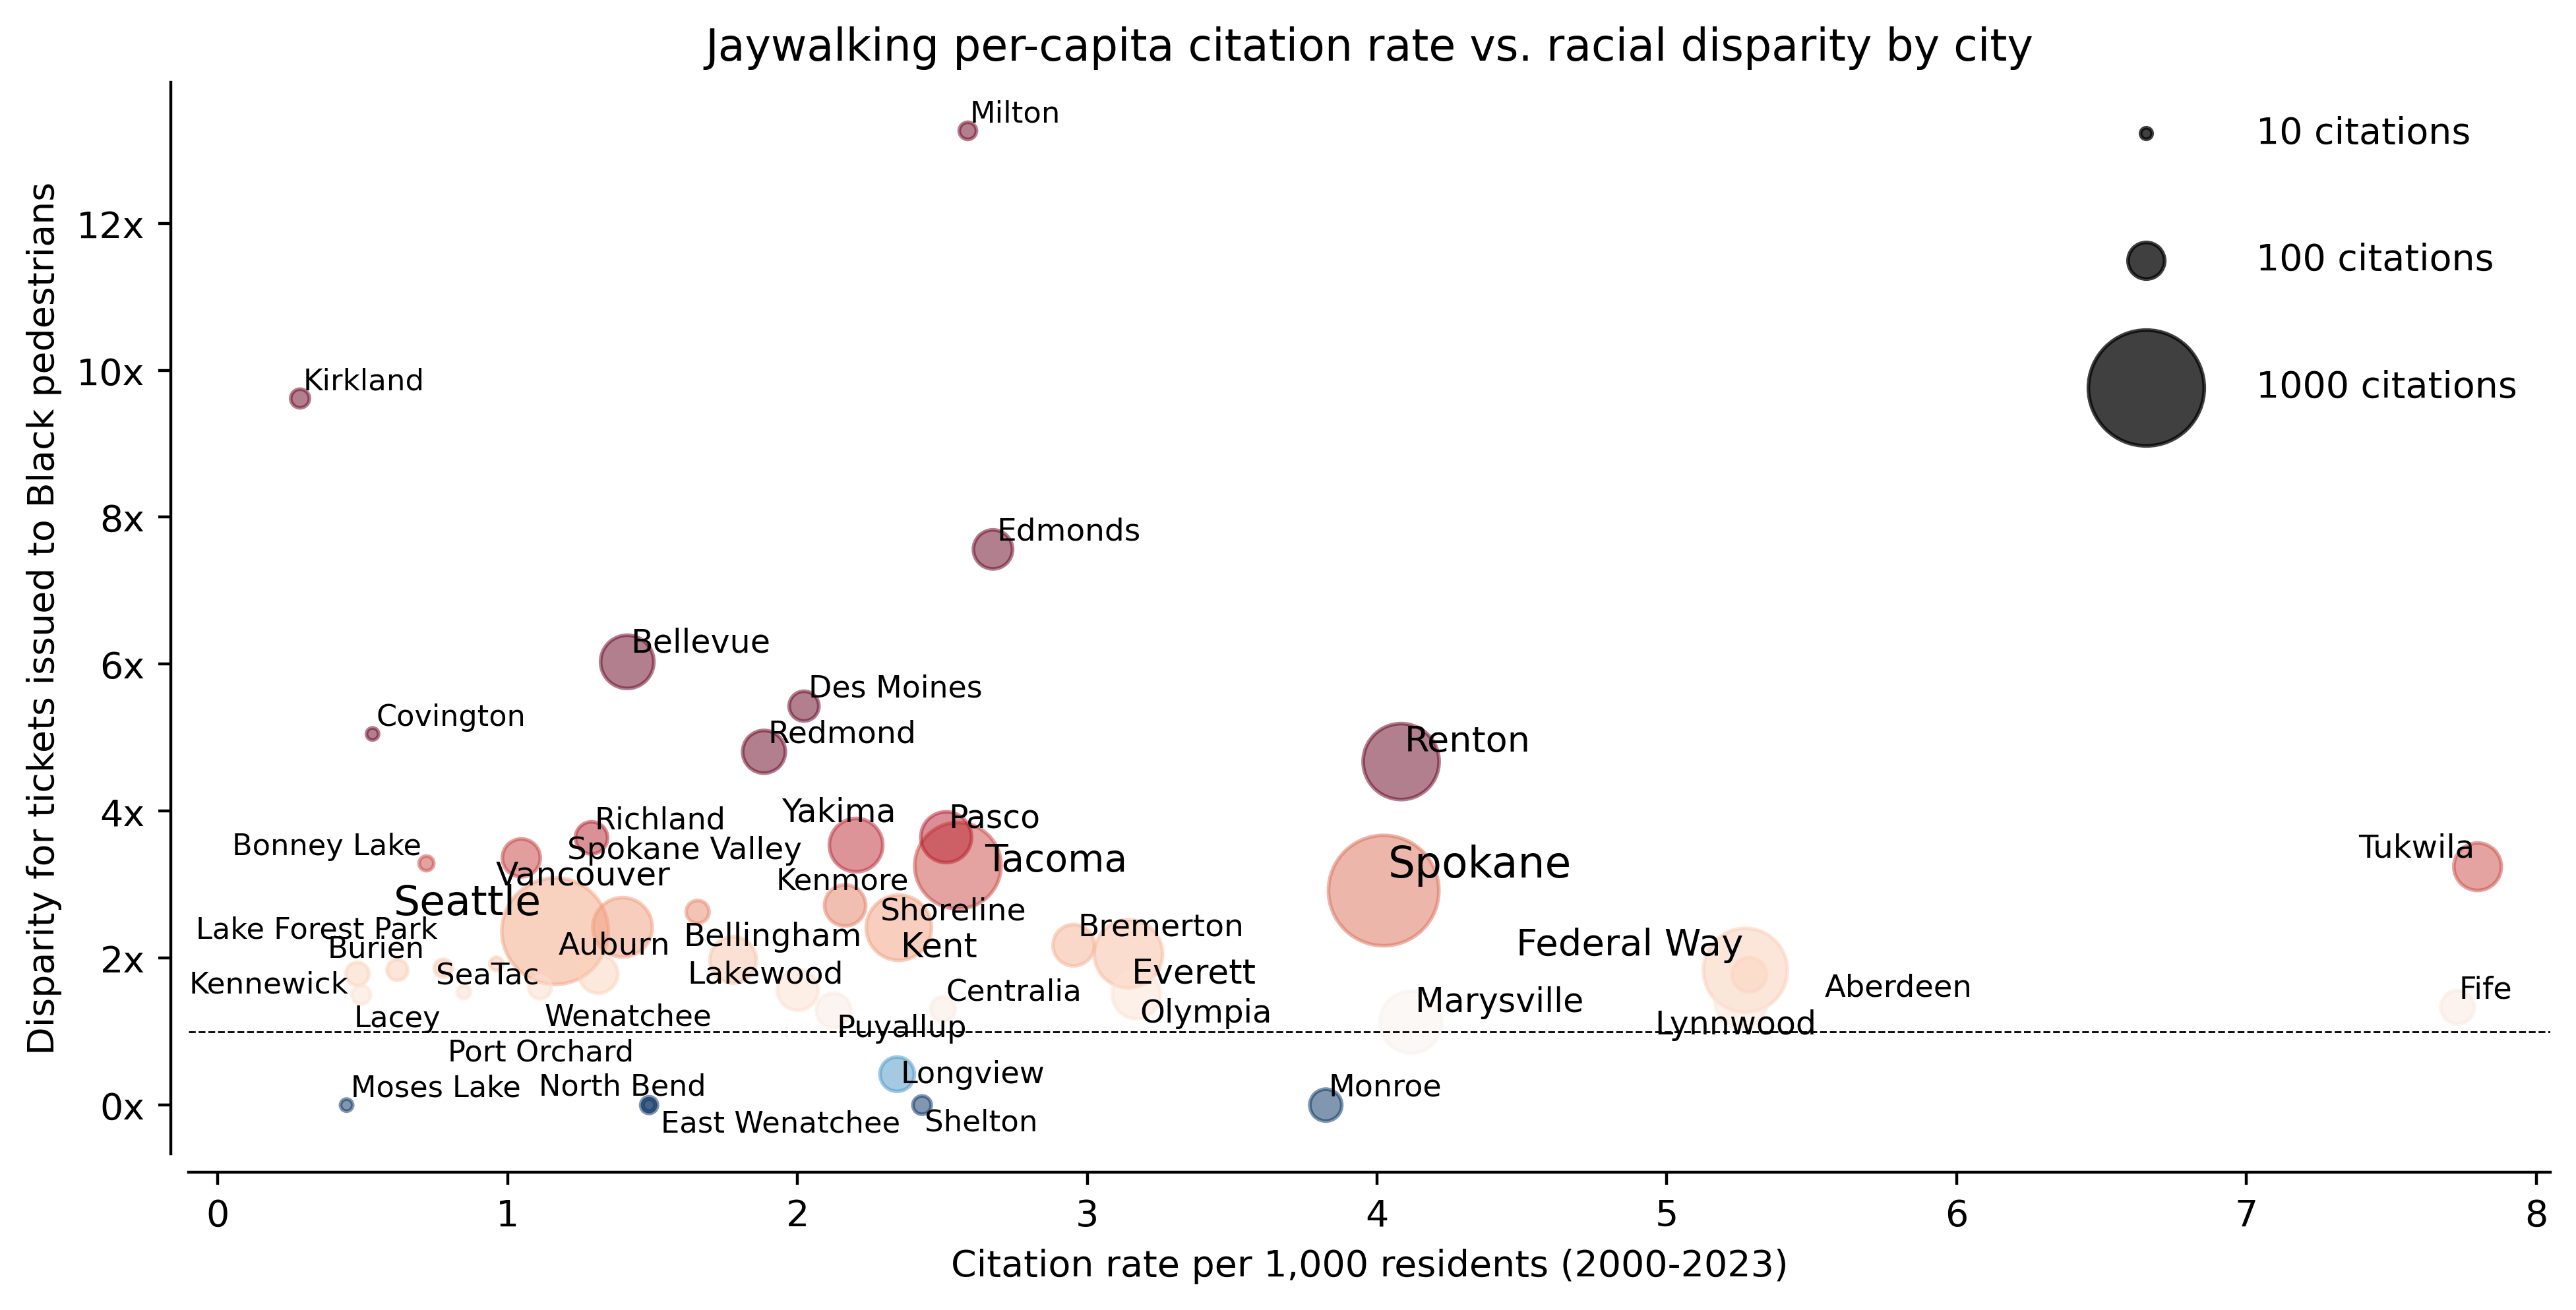

In [ ]:
# Plot jaywalking citation rate vs. Black citation disparity by city/town
rate_disparity = pd.merge(place_citation_rate.rename('Citation rate'),
                          city_disparities['Black'].dropna().rename('Black disparity'),
                          left_index=True,right_index=True)
volume_rate_disparity = pd.merge(place_counts,rate_disparity,
                                 left_index=True,right_index=True)

plt.figure(figsize=(10,5),facecolor='w',dpi=400)
plt.scatter(volume_rate_disparity['Citation rate'],
            volume_rate_disparity['Black disparity'],
            s=volume_rate_disparity['Total citations'],
            c=volume_rate_disparity['Black disparity'],
            alpha=0.5,cmap='RdBu_r',
            norm=mcolors.TwoSlopeNorm(vcenter=1.0,vmin=0.0,
                                      vmax=volume_rate_disparity['Black disparity'].max()/3))
plt.scatter(np.NaN,np.NaN,s=10,c='k',alpha=0.75,label='10 citations')
plt.scatter(np.NaN,np.NaN,s=100,c='k',alpha=0.75,label='100 citations')
plt.scatter(np.NaN,np.NaN,s=1000,c='k',alpha=0.75,label='1000 citations')
plt.plot([-0.1,volume_rate_disparity['Citation rate'].max()+0.25],
         [1.0,1.0],c='k',ls='--',lw=0.5)
plt.xlim([-0.1,volume_rate_disparity['Citation rate'].max()+0.25])
texts = []
for label in volume_rate_disparity.index:
  texts.append(plt.text(volume_rate_disparity.loc[label,'Citation rate'],
                        volume_rate_disparity.loc[label,'Black disparity'],label,
                        fontsize=8+volume_rate_disparity.loc[label,'Total citations']/250))
plt.legend(frameon=False,loc='upper right',labelspacing=2.5,handletextpad=2)
yticklabels = [item.get_text() for item in plt.gca().get_yticklabels()]
plt.gca().set_yticklabels([label + 'x' for label in yticklabels])
plt.ylabel('Disparity for tickets issued to Black pedestrians')
plt.xlabel('Citation rate per 1,000 residents (2000-2023)')
plt.title('Jaywalking per-capita citation rate vs. racial disparity by city')
plt.tight_layout()
drop_spines()
adjust_text(texts)
plt.savefig(current_results_dir + 'Citation rate vs. racial disparity by city.pdf',bbox_inches='tight')

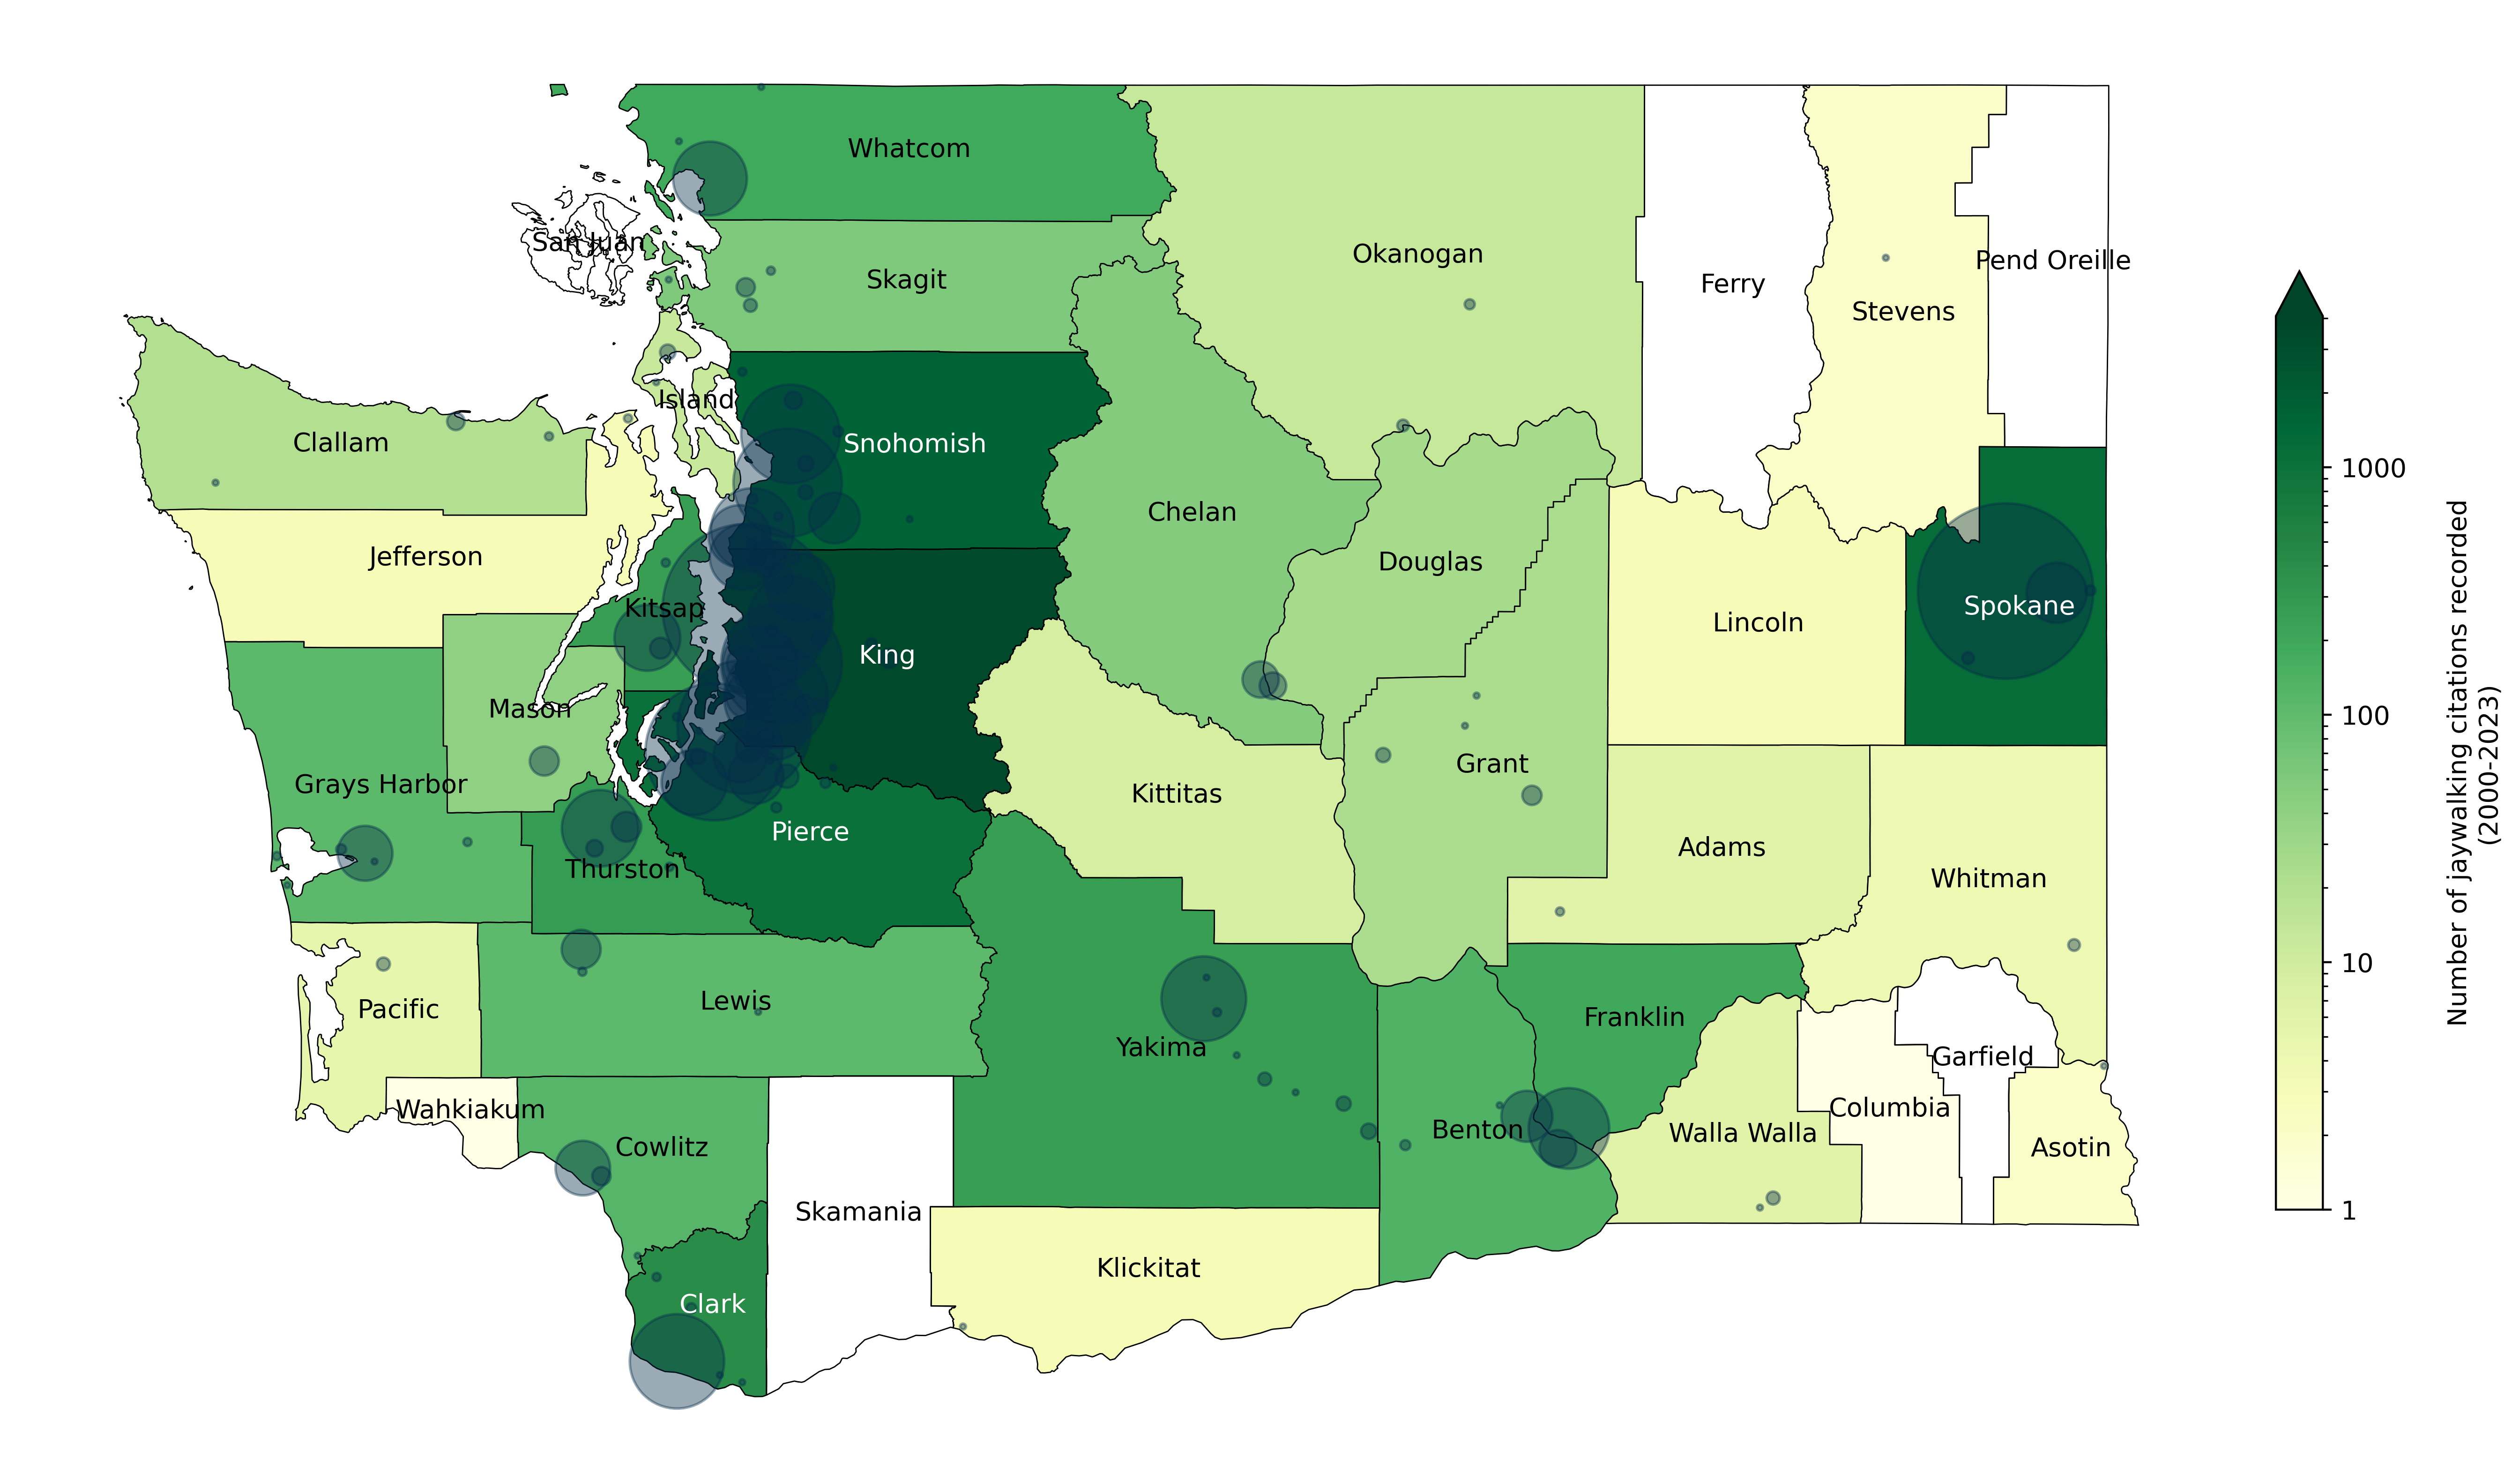

In [ ]:
# State map of jaywalking citation volumes by county and city
plt.figure(figsize=(25,10),facecolor='w',dpi=400)
chlor = geo_county.plot(kind='geo',column='Total citations',ax=plt.gca(),cmap='YlGn',
                        norm=mcolors.LogNorm(vmin=1,vmax=geo_county['Total citations'].max()+500),
                        edgecolor='k',linewidth=0.5,legend=True,
                        legend_kwds={'shrink':0.65,'format':'%.0f','pad':0.01,'extend':'max',
                                     'label':'\nNumber of jaywalking citations recorded\n(2000-2023)'})
texts = []
for x, y, label, num in zip(geo_county_count_valid['points'].x,geo_county_count_valid['points'].y,
                            geo_county_count_valid['points'].index,geo_county_count_valid['Total citations']):
  if num >= 400: c = 'w'
  else:          c = 'k'
  texts.append(plt.gca().annotate(label,xy=(x,y),xytext=(2.5,-2),color=c,
                                  horizontalalignment='center',
                                  textcoords="offset points"))
geo_place['Count_scaled'] = geo_place['Total citations'] * 5
chlor_place = geo_place.plot(kind='geo',markersize='Count_scaled',
                             color='#052d49',alpha=0.4,ax=plt.gca())
plt.axis('off')
# adjust_text(texts)
plt.savefig(current_results_dir + 'Map - jaywalking citation volume by county and city.pdf',bbox_inches='tight')

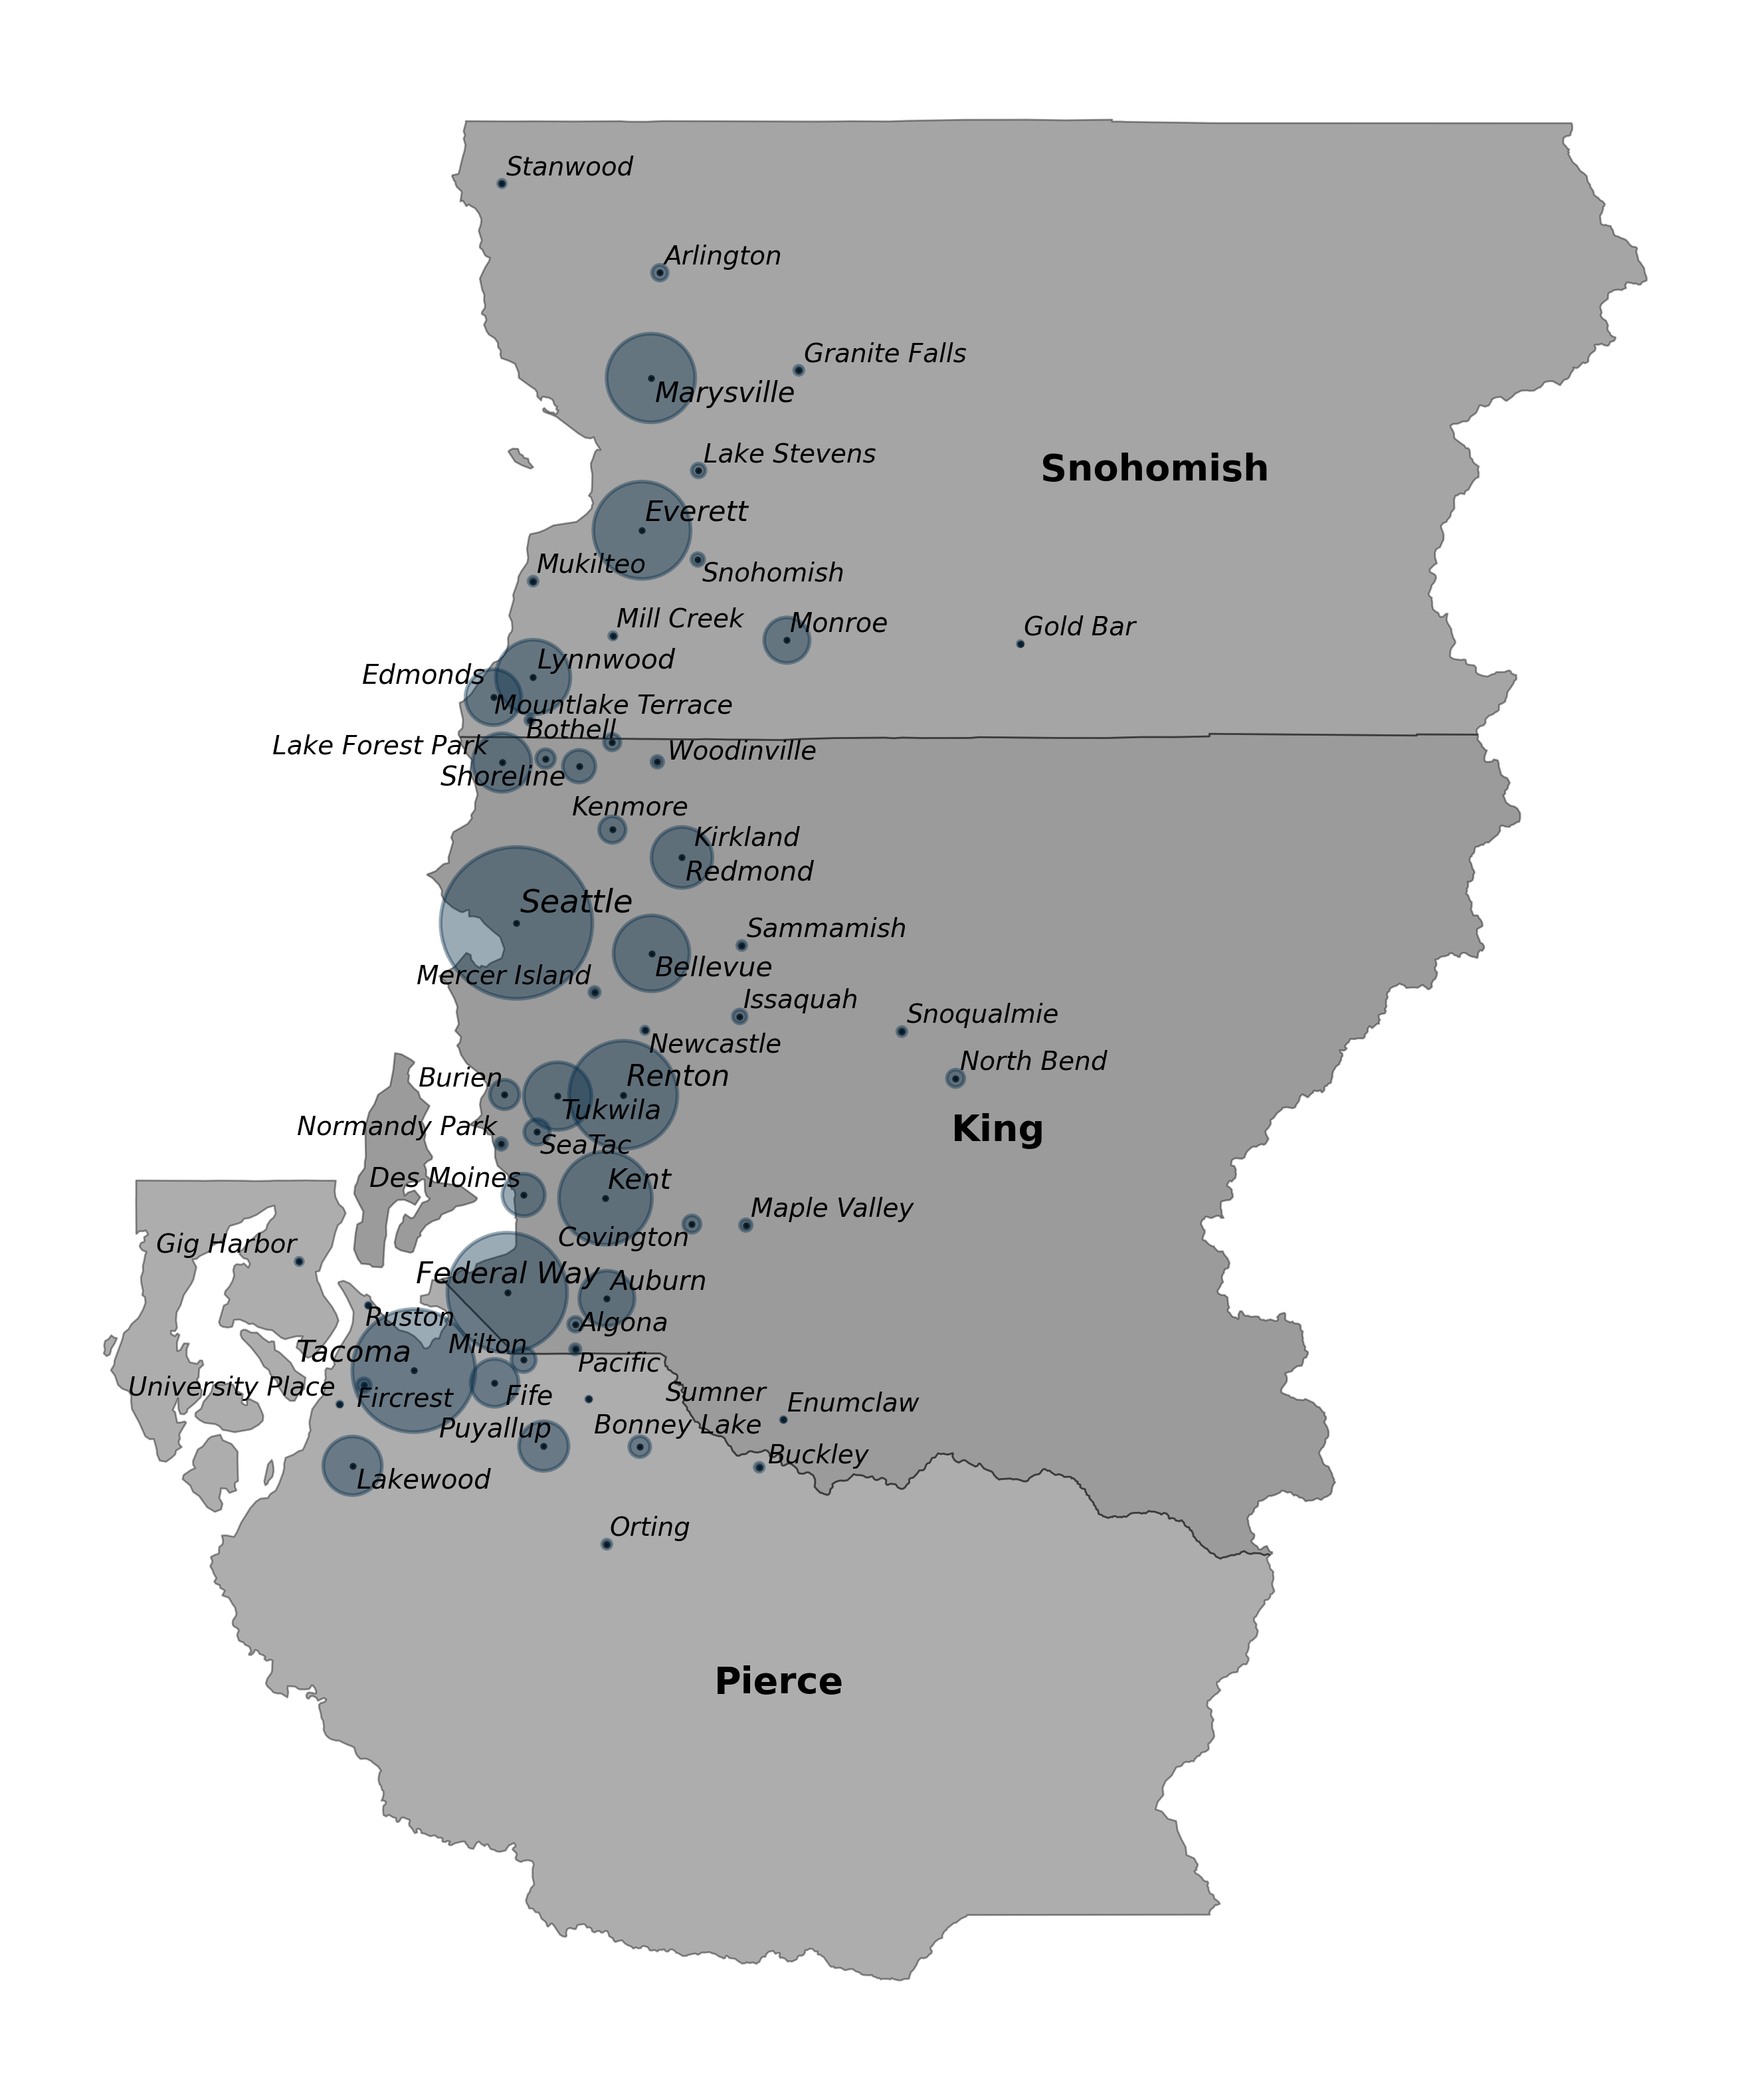

In [ ]:
# Inset map: volume of jaywalking citations in Pierce, King, and Snohomish counties

# Tabulate number of jaywalking citations issued by town/city, excluding citations for which town/city is unknown
place_counts_inset = \
  aoc_extracted.loc[np.logical_and.reduce((jay_mask,~aoc_extracted['Jurisdiction'].str.contains('County'),
                                           np.logical_or.reduce((aoc_extracted['County'] == 'Pierce',
                                                                 aoc_extracted['County'] == 'King',
                                                                 aoc_extracted['County'] == 'Snohomish')))),
                    'Jurisdiction'].value_counts().rename('Total citations')

# Load place (city/town/unincorporated area) shapefile for Washington
geo_place_inset = geopandas.read_file(place_shapefile_path)
geo_place_inset = geo_place_inset[['NAME','geometry']].set_index('NAME')

# Merge place shapefiles with tabulation of all jaywalking-related records by place
geo_place_inset = geo_place_inset.merge(place_counts_inset,left_index=True,right_index=True,how='inner')

# Calculate centroids of place geometries
centroids = geo_place_inset['geometry'].to_crs('+proj=cea').centroid.to_crs(geo_place_inset['geometry'].crs)
geo_place_inset['geometry'] = centroids

# Inset map of jaywalking citation volumes by county and city
plt.figure(figsize=(15,10),facecolor='w',dpi=400)
geo_inset = geo_county.loc[['Pierce','King','Snohomish']]
chlor = geo_inset.plot(kind='geo',column='Total citations',ax=plt.gca(),cmap='Greys',
                       norm=mcolors.LogNorm(vmin=1,vmax=geo_inset['Total citations'].max()+500),
                       edgecolor='k',linewidth=0.5,legend=False,alpha=0.4)
texts = []
for x, y, label in zip(geo_inset['points'].x,geo_inset['points'].y,
                       geo_inset['points'].index):
  texts.append(plt.gca().annotate(label,xy=(x,y),xytext=(5,-20),weight='bold',
                                  horizontalalignment='center',
                                  textcoords="offset points",fontsize=10))
geo_place_inset['Count_scaled'] = geo_place_inset['Total citations'] * 2
center_place = geo_place_inset.plot(kind='geo',markersize=0.75,
                                    color='k',alpha=0.8,ax=plt.gca())
chlor_place = geo_place_inset.plot(kind='geo',markersize='Count_scaled',
                                   color='#052d49',alpha=0.4,ax=plt.gca())
for x, y, label in zip(geo_place_inset['geometry'].x,geo_place_inset['geometry'].y,
                       geo_place_inset['geometry'].index):
  text = plt.gca().annotate(label,xy=(x,y),xytext=(0.2,0.2),horizontalalignment='left',
                            textcoords="offset points",
                            fontsize=7+geo_place_inset.loc[label,'Total citations']/500,
                            fontstyle='italic')
  texts.append(text)
plt.axis('off')
adjust_text(texts)
plt.savefig(current_results_dir + 'Map - jaywalking citation volume inset.pdf',bbox_inches='tight')

In [ ]:
# Tabulate # jaywalking citations issued by town/city, excluding citations for which town/city is unknown
place_counts = aoc_extracted.loc[np.logical_and(jay_mask,~aoc_extracted['Jurisdiction'].str.contains('County')),
                                 'Jurisdiction'].value_counts().rename('Total citations')

# Load place (city/town/unincorporated area) shapefile for Washington
geo_place = geopandas.read_file(place_shapefile_path)
geo_place = geo_place[['NAME','geometry']].set_index('NAME')

# Merge place shapefiles with tabulation of all jaywalking-related records by place
geo_place = geo_place.merge(place_counts,left_index=True,right_index=True,how='inner')

# Calculate centroids of place geometries
centroids = geo_place['geometry'].to_crs('+proj=cea').centroid.to_crs(geo_place['geometry'].crs)
geo_place['geometry'] = centroids

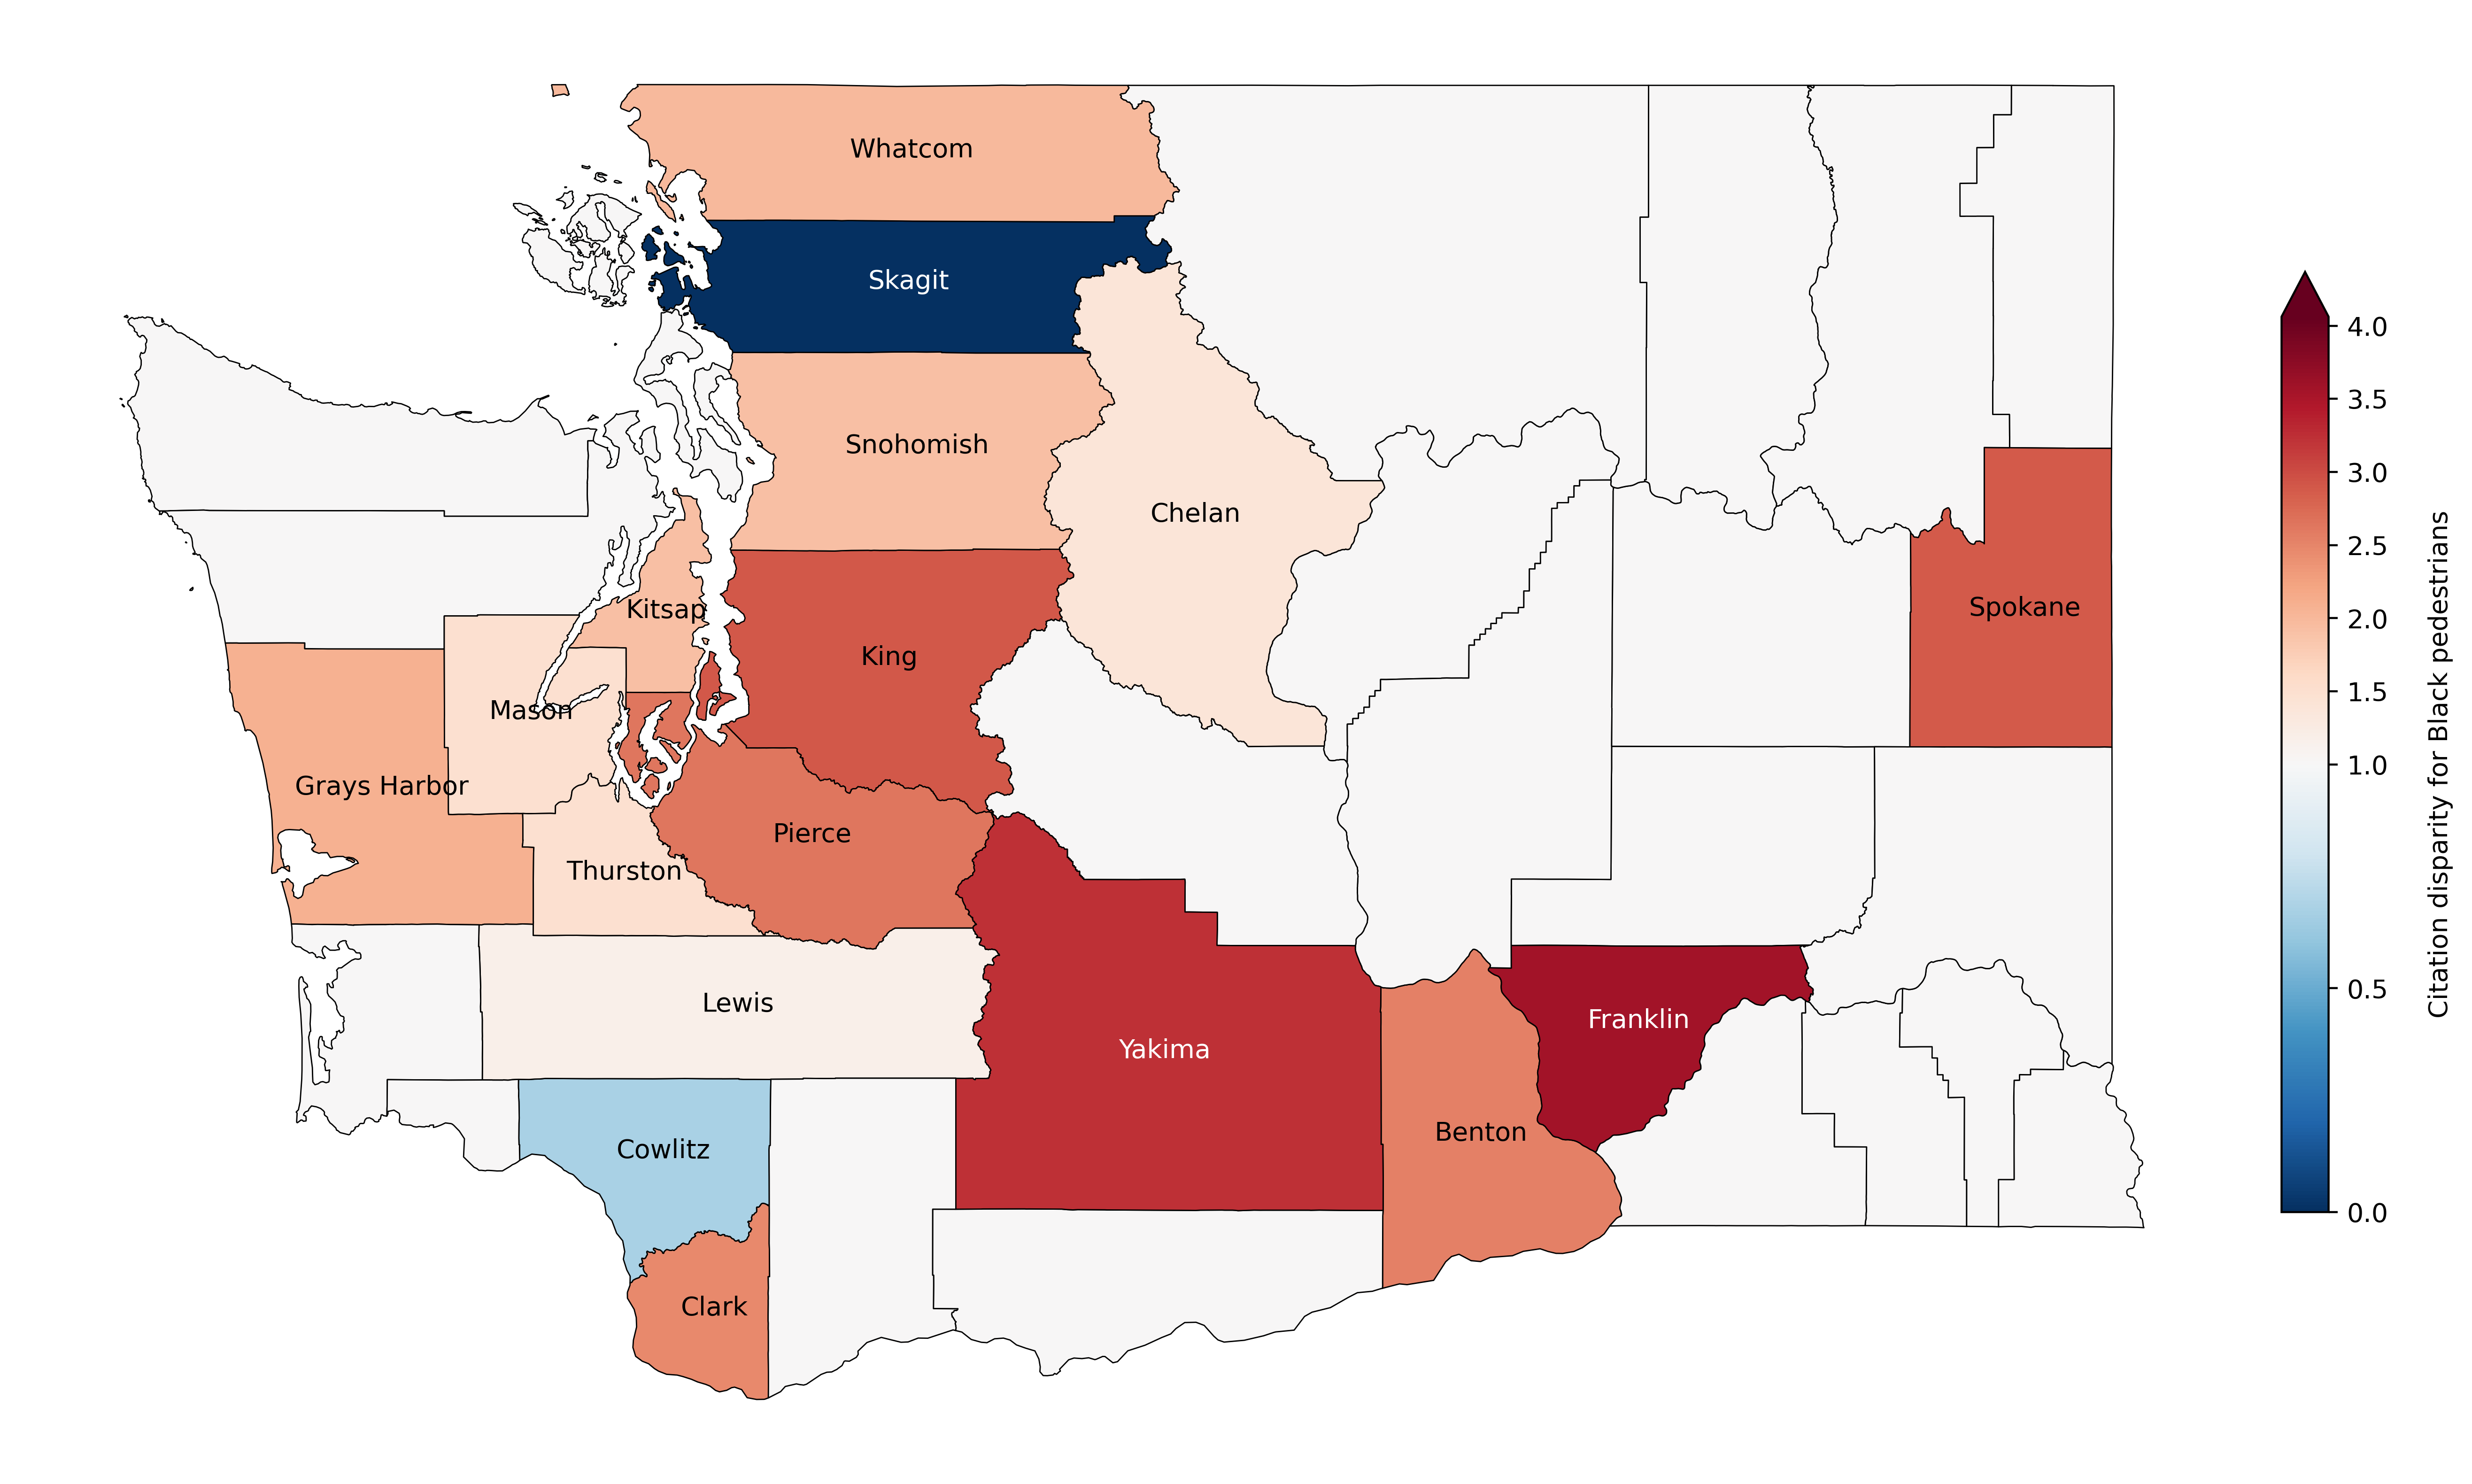

In [ ]:
# State map of jaywalking citation disparities by county
plt.figure(figsize=(25,10),facecolor='w',dpi=400)
chlor = geo_county.plot(kind='geo',column='Black',ax=plt.gca(),cmap='RdBu_r',
                        norm=mcolors.TwoSlopeNorm(vcenter=1.0,vmin=0.0,vmax=geo_county['Black'].max()+0.5),
                        edgecolor='k',linewidth=0.5,legend=True,
                        legend_kwds={'shrink':0.65,'pad':0.01,'extend':'max',
                                     'label':'\nCitation disparity for Black pedestrians'})
for x, y, label, num in zip(geo_county_valid['points'].x,geo_county_valid['points'].y,
                            geo_county_valid['points'].index,geo_county_valid['Black']):
  if num < 0.5 or num > 3: c = 'w'
  else:                    c = 'k'
  plt.gca().annotate(label,xy=(x,y),xytext=(2.5,-2),color=c,
                     horizontalalignment='center',textcoords="offset points")
# geo_place['Count_scaled'] = geo_place['Count'] * 15
# chlor_place = geo_place.plot(kind='geo',markersize='Count_scaled',
#                              color='navy',alpha=0.4,ax=plt.gca())
plt.axis('off')
plt.savefig(current_results_dir + 'Map - jaywalking citation disparities by county.pdf',bbox_inches='tight')

## Analyze manually tabulated police stop records

In [230]:
# Load county shapefile; extract Washington counties
geo_county = geopandas.read_file(county_shapefile_path)
geo_county = geo_county.loc[geo_county['STATEFP'] == '53',['NAME','geometry']].set_index('NAME')

# Merge county shapefiles with tabulation of all jaywalking-related records by county
county_counts = contacts[mask_stop | mask_prot]['Contact location - county'].value_counts().rename('Count')
geo_county = geo_county.merge(county_counts,left_index=True,right_index=True,how='outer').fillna(0)

# Calculate centroids of county geometries
centroids = geo_county['geometry'].to_crs('+proj=cea').centroid.to_crs(geo_county['geometry'].crs)
geo_county['points'] = centroids

# Load place (city/town/unincorporated area) shapefile for Washington
geo_place = geopandas.read_file(place_shapefile_path)
geo_place = geo_place[['NAME','geometry']].set_index('NAME')

# Merge place shapefiles with tabulation of all jaywalking-related records by place
place_counts = contacts[mask_stop | mask_prot]['Contact location - city'].value_counts().rename('Count')
geo_place = geo_place.merge(place_counts,left_index=True,right_index=True,how='inner')

# Calculate centroids of place geometries
centroids = geo_place['geometry'].to_crs('+proj=cea').centroid.to_crs(geo_place['geometry'].crs)
geo_place['geometry'] = centroids

In [231]:
# Total number of jaywalking stop records
print('Total jaywalking stop records analyzed:',mask_stop.sum())

Total jaywalking stop records analyzed: 1079


In [232]:
# Fraction of all jaywalking-related records with narrative present
narrative = (contacts[mask_stop]['Police narrative present in record #1'] | contacts[mask_stop]['Police narrative present in record #2'])
narrative_counts = pd.concat([narrative.value_counts(),narrative.value_counts(normalize=True)],axis=1)
display(narrative_counts)
# narrative.value_counts().plot.pie();

0         1
False  725  0.671918
True   354  0.328082

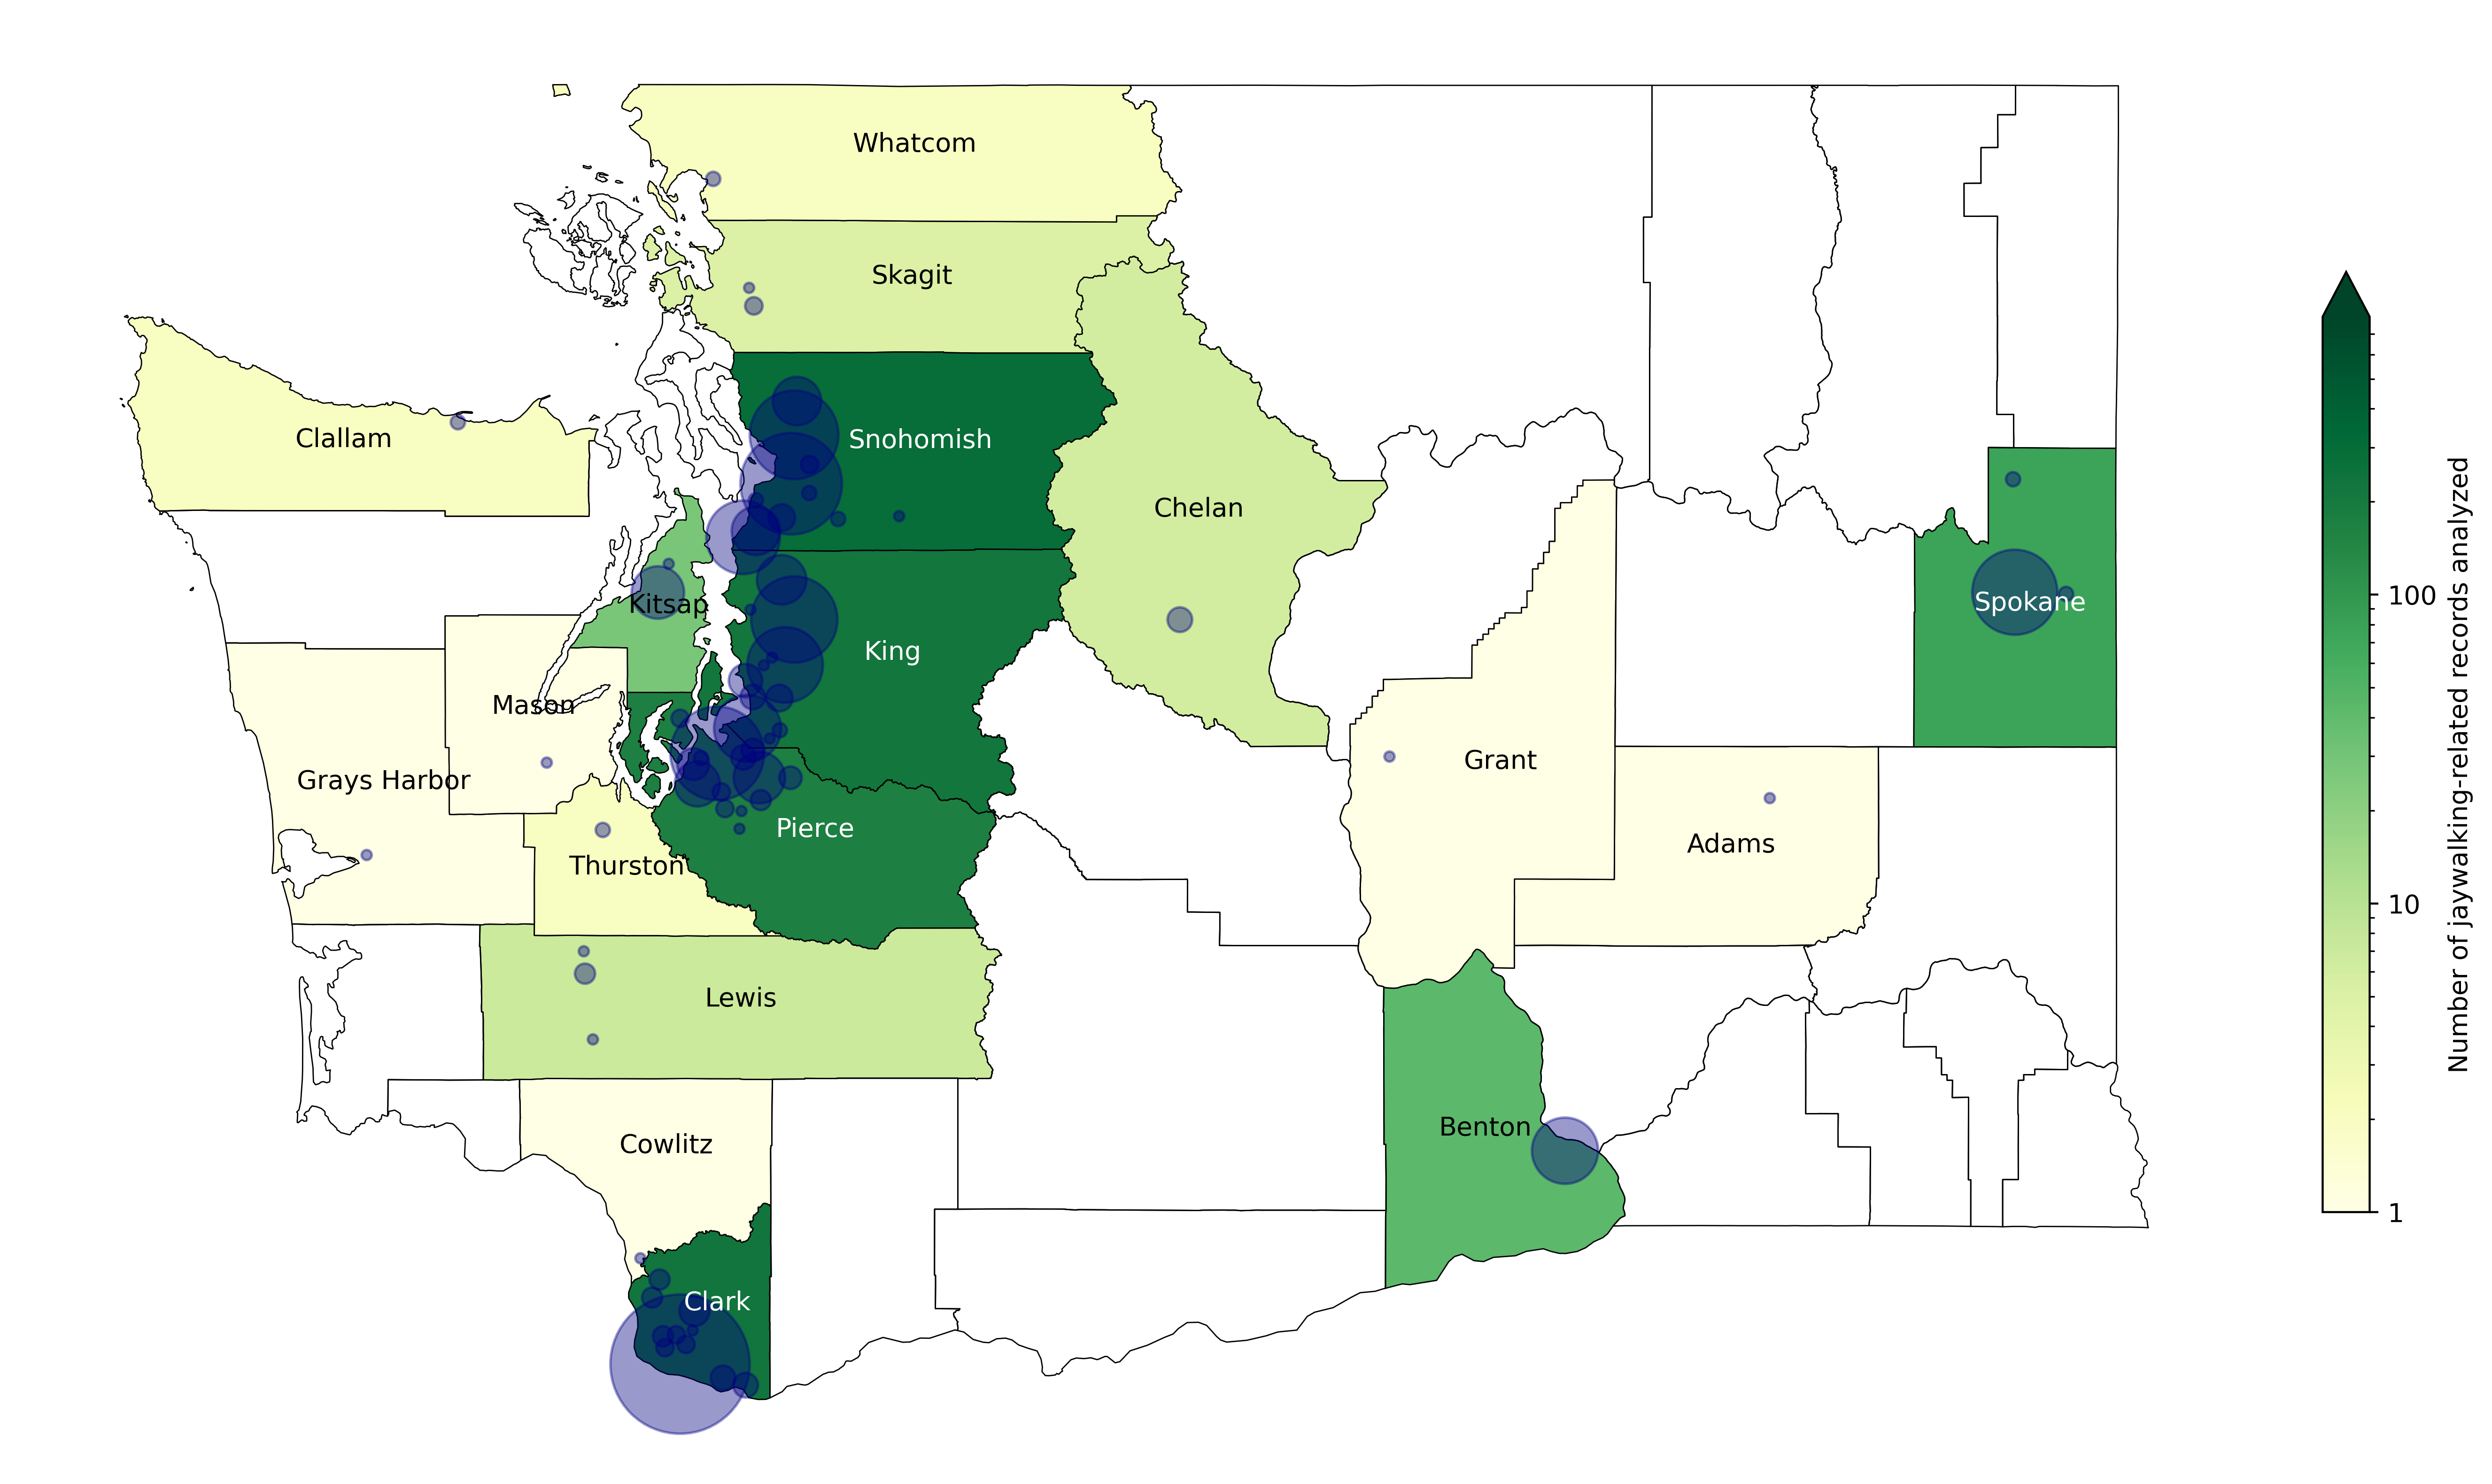

In [ ]:
# State map of jaywalking-related records
plt.figure(figsize=(25,10),facecolor='w',dpi=400)
geo_county.loc[geo_county['Count'].isnull(),'Count'] = 0.0
chlor = geo_county.plot(kind='geo',column='Count',ax=plt.gca(),cmap='YlGn',
                        norm=mcolors.LogNorm(vmin=1,vmax=geo_county['Count'].max()+500),
                        edgecolor='k',linewidth=0.5,legend=True,
                        legend_kwds={'shrink':0.65,'format':'%.0f','pad':0.02,'extend':'max',
                                     'label':'Number of jaywalking-related records analyzed'})
geo_county_valid = geo_county[geo_county['Count'] >= 1.0]
for x, y, label, num in zip(geo_county_valid['points'].x,geo_county_valid['points'].y,
                            geo_county_valid['points'].index,geo_county_valid['Count']):
  if num >= 75: c = 'w'
  else:         c = 'k'
  plt.gca().annotate(label,xy=(x, y),xytext=(3,0),color=c,
                     horizontalalignment='center',textcoords="offset points")
geo_place['Count_scaled'] = geo_place['Count'] * 15
chlor_place = geo_place.plot(kind='geo',markersize='Count_scaled',
                             color='navy',alpha=0.4,ax=plt.gca())
plt.axis('off')
plt.savefig(current_results_dir + 'Map - jaywalking police stop records reviewed.pdf',bbox_inches='tight')

Stop outcome  Stop outcome
Warning                                         546      0.646154
Unknown (either\nwarning or citation)           201      0.237870
Citation                                         55      0.065089
Arrest                                           35      0.041420
Citation and arrest                               8      0.009467


Total number of records sufficiently representative to assess stop outcomes: 845


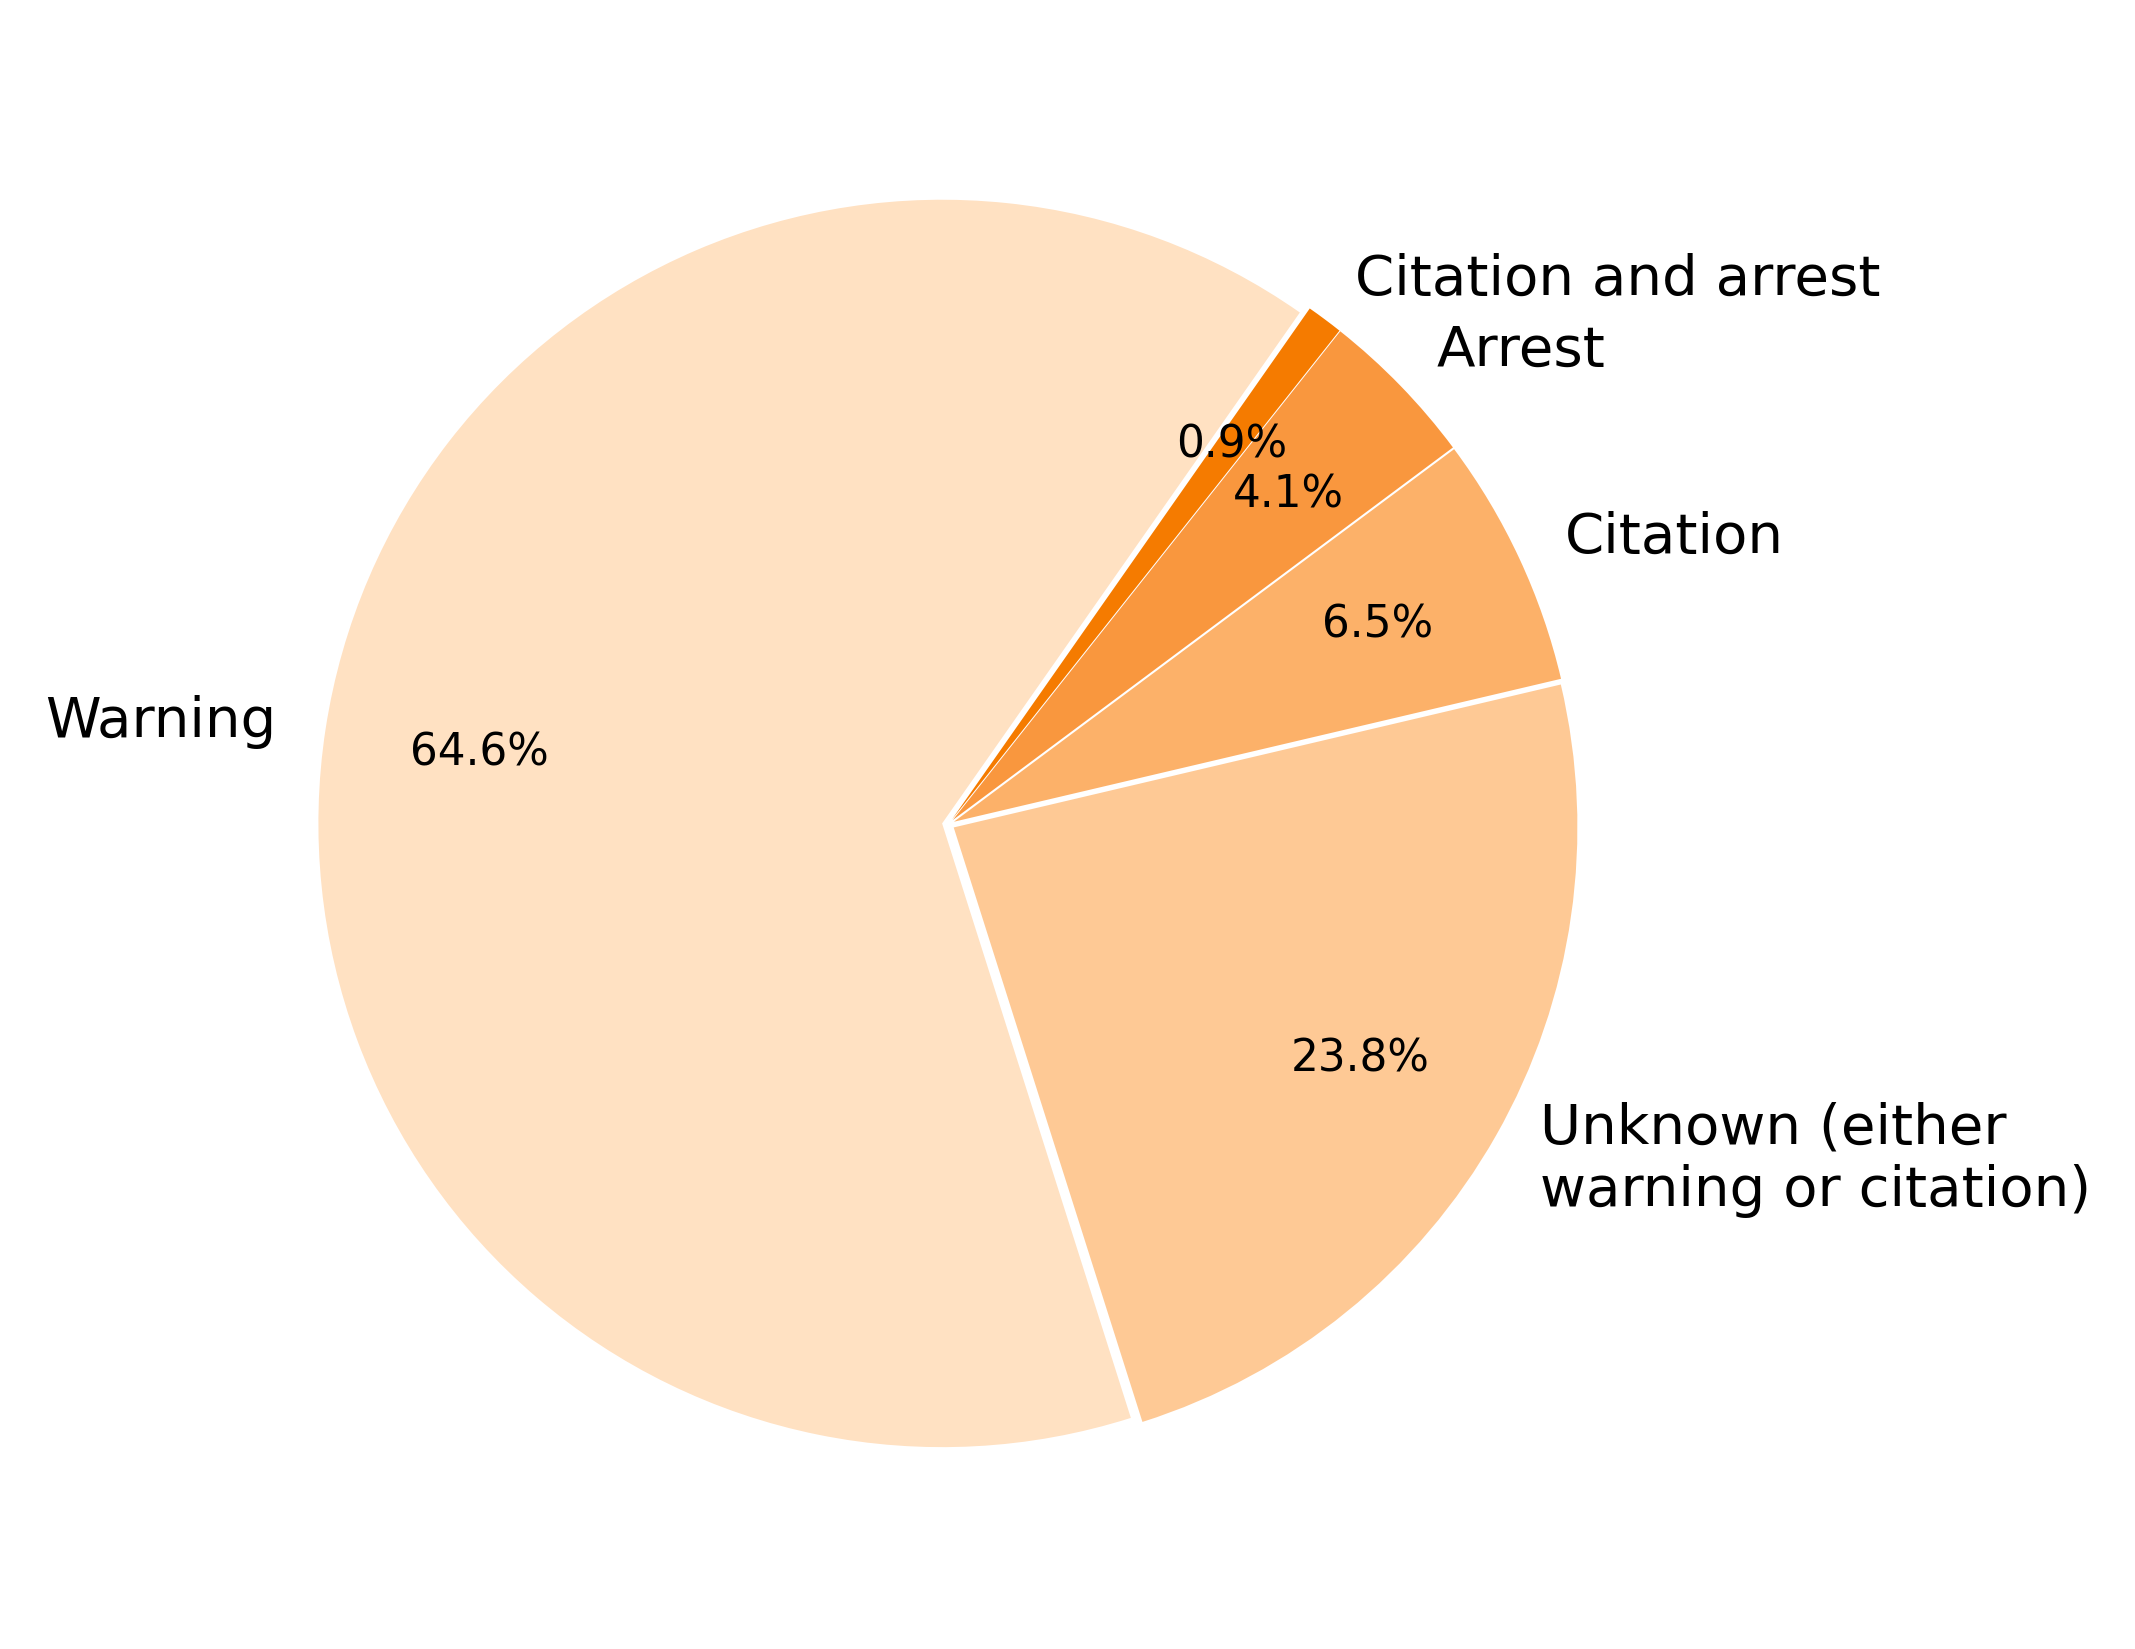

In [233]:
# Jaywalking stop outcomes (primarily based on dispatch logs)
mask_outcome = sufficient_mask('Sufficient for analysis - stop outcome')
outcome = contacts[mask_stop & mask_outcome]['Stop outcome']
contacts.loc[mask_stop & mask_outcome,
             'Included in analysis: outcomes'] = True  # Flag for final tabulation
outcome = outcome.fillna('Unknown (either\nwarning or citation)')
outcome_counts = outcome.value_counts()
outcome_chart = pd.concat([outcome_counts,outcome.value_counts(normalize=True)],axis=1)
display(outcome_chart)
print('\nTotal number of records sufficiently representative to assess stop outcomes:',
      outcome_chart.iloc[:,0].sum())

def autopct(percent): return ('%.1f%%' % percent)
plt.figure(figsize=(9,4.5),facecolor='w',dpi=450)
colors = np.flip(['#f57b00','#f9973e','#fcb169','#fec995','#ffe1c2'])
wedges, labels, autopct_out = plt.pie(outcome_counts.values,labels=outcome_counts.index,
                                      explode=np.tile(0.01,len(outcome_counts)),
                                      labeldistance=1.08,autopct=autopct,
                                      pctdistance=0.75,colors=colors,
                                      startangle=55)
for lab in labels: lab.set_fontsize(9)
for pct in autopct_out: pct.set_fontsize(7); pct.set_color('k')
# plt.title('Jaywalking police stop outcomes (2017-2022)',pad=15);
plt.savefig(current_results_dir + 'Stop outcomes.pdf',bbox_inches='tight')

In [234]:
# Frequency of juvenile subjects of police stops
mask_youth = mask_stop & ((contacts['Subject - juvenile'] == True) | (contacts['Subject - juvenile based on age'] == True))
print('Total number of youth/juveniles in jaywalking stop records:',mask_youth.sum())

Total number of youth/juveniles in jaywalking stop records: 51


Frequency of homeless subject of police stop, out of citations/arrests with home address listed, based on those addresses and narrative evidence):


0         1
False  105  0.586592
True    74  0.413408

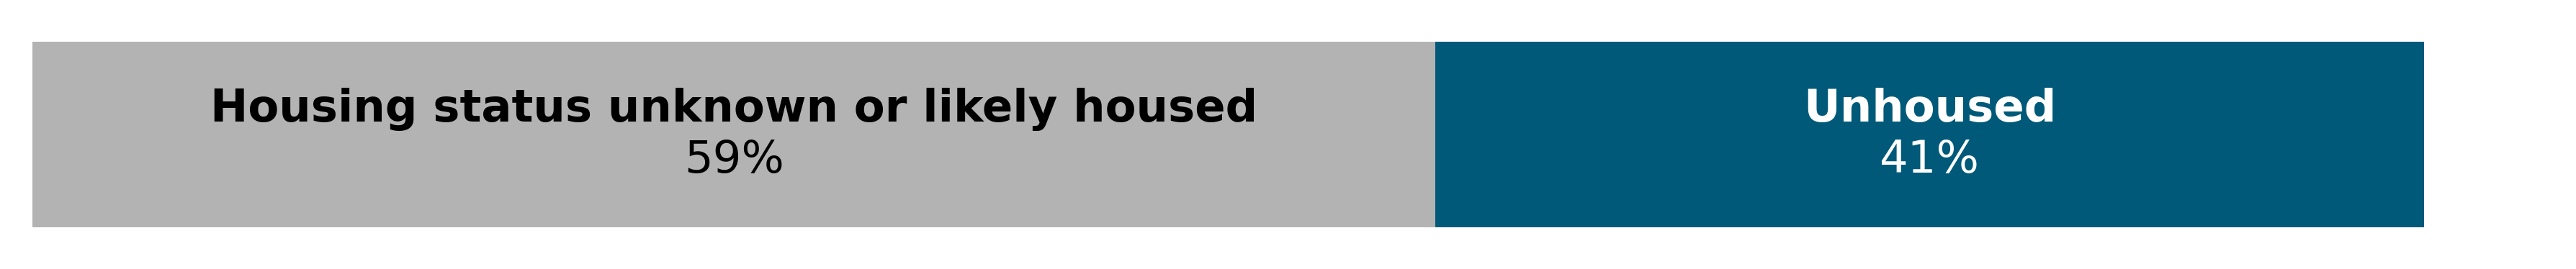

In [235]:
# Frequency of homeless subjects of police stops
print('Frequency of homeless subject of police stop, out of citations/arrests with home address listed, based on those addresses and narrative evidence):')
mask_citation_arrest = (contacts[mask_stop]['Stop outcome'] == 'Citation') | \
                       (contacts[mask_stop]['Stop outcome'] == 'Arrest') | \
                       (contacts[mask_stop]['Stop outcome'] == 'Citation and arrest')
homeless_based_on_address = contacts[mask_stop]['Subject - home address (indicates homelessness)']
homeless_based_on_all_evidence = contacts[mask_stop]['Concurrent situation - homelessness'].fillna(False)
mask_address_checked = ~np.isnan(homeless_based_on_address) & mask_citation_arrest
contacts.loc[mask_address_checked.index[mask_address_checked == True],
             'Included in analysis: homelessness'] = True  # Flag for final tabulation
homeless = homeless_based_on_address[mask_address_checked].astype(bool) | homeless_based_on_all_evidence[mask_address_checked].astype(bool)
homeless_counts = homeless.value_counts()
homeless_counts_norm = homeless.value_counts(normalize=True)
display(pd.concat([homeless_counts,homeless_counts_norm],axis=1).sort_index())

def autopct(percent): return ('%.1f%%' % percent)
plt.figure(figsize=(10,0.82),facecolor='w',dpi=450)
colors = ['#005978','0.7']
plt.barh(1,homeless_counts.loc[False],left=0,
         color='0.7')
plt.barh(1,homeless_counts.loc[True],left=homeless_counts.loc[False],
         color='#005978')
plt.text(homeless_counts.loc[False]/2,1.11,'Housing status unknown or likely housed',
         ha='center',va='center',color='k',weight='bold')
plt.text(homeless_counts.loc[False] + homeless_counts.loc[True]/2,1.11,'Unhoused',
         ha='center',va='center',color='w',weight='bold')
plt.text(homeless_counts.loc[False]/2,0.89,'{0:.0f}%'.format(100*homeless_counts_norm[False]),
         ha='center',va='center',color='k')
plt.text(homeless_counts.loc[False] + homeless_counts.loc[True]/2,0.89,'{0:.0f}%'.format(100*homeless_counts_norm[True]),
         ha='center',va='center',color='w')
plt.axis('off')
# plt.title('Frequency of homeless subjects of police stops (2017-2022)',pad=15);
plt.savefig(current_results_dir + 'Homeless frequency.pdf',bbox_inches='tight')

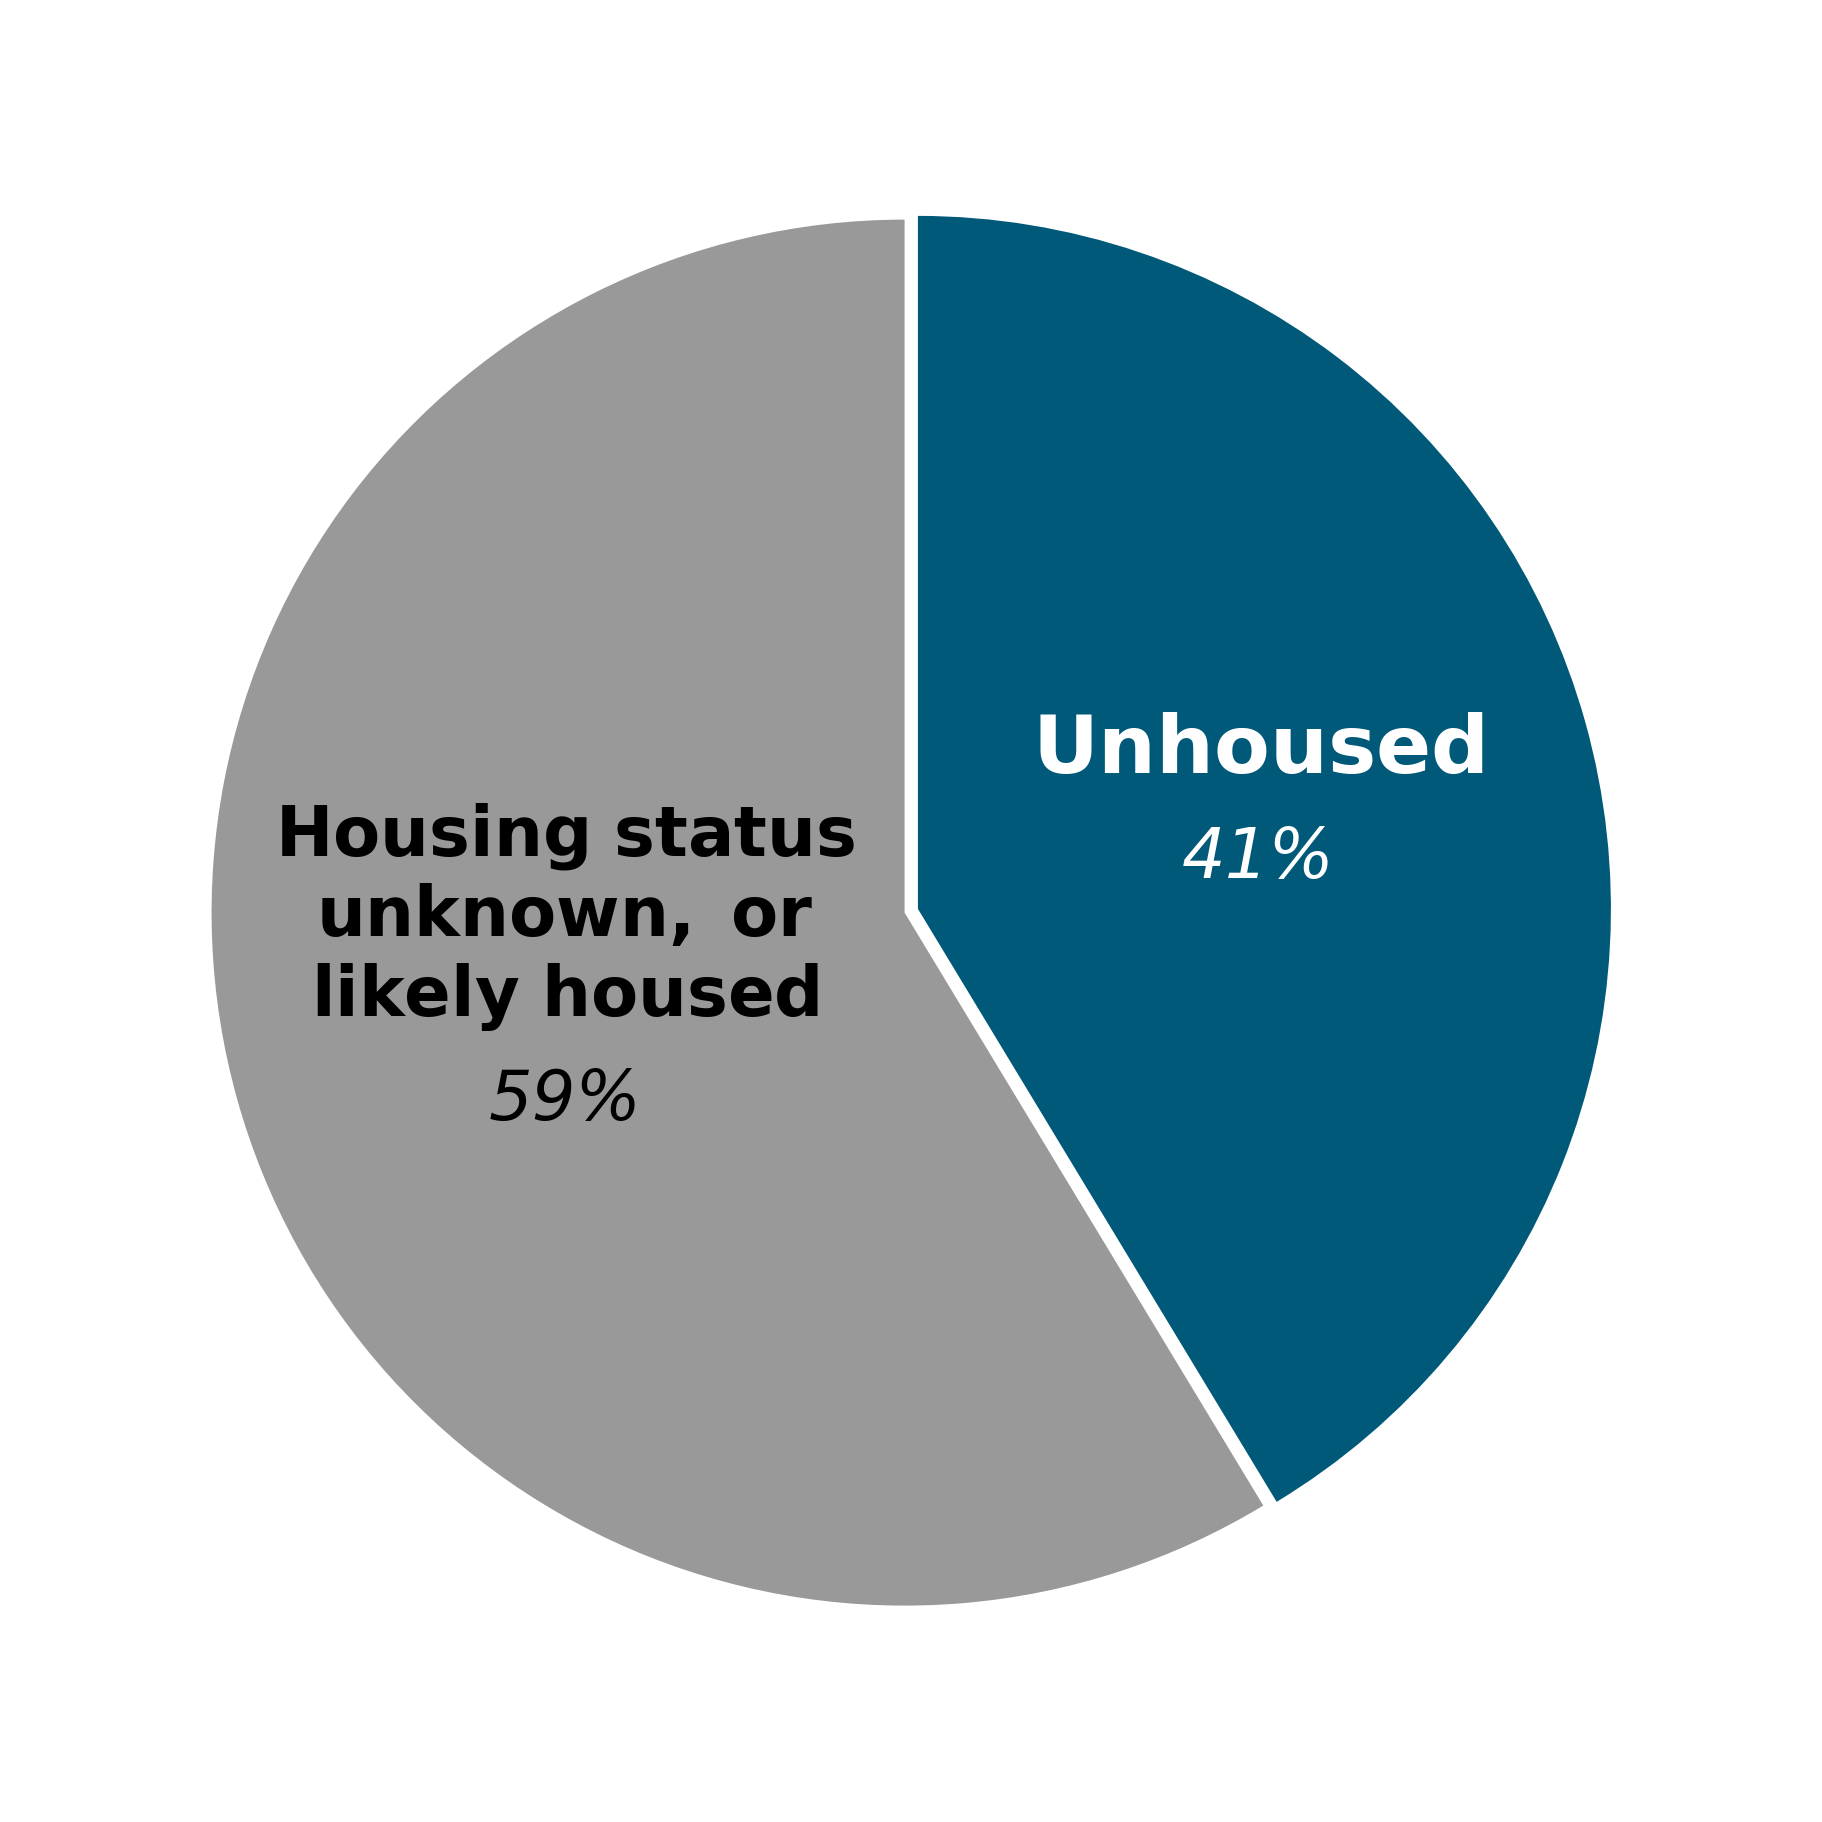

In [ ]:
# Pie chart version showing frequency of homeless subjects
def autopct(percent): return ('%.0f%%' % percent)
plt.figure(figsize=(10,5),facecolor='w',dpi=450)
colors = np.flip(['#005978','0.6'])
wedges, labels = plt.pie(homeless_counts.values,
                         explode=np.tile(0.01,len(homeless_counts)),
                         colors=colors,startangle=90)
plt.text(0.70,0.57,r'$\bf{Unhoused}$',
         size=13,color='white',ha='center',va='bottom',transform=plt.gca().transAxes)
plt.text(0.70,0.57-0.02,'{0:.0f}%'.format(100*homeless_counts_norm[True]),style='italic',
         size=11,color='white',ha='center',va='top',transform=plt.gca().transAxes)
plt.text(0.30,0.43,r'$\bf{Housing~status}$' + '\n' + r'$\bf{unknown,~or}$' + '\n' + r'$\bf{likely~housed}$',
         size=11,color='black',ha='center',va='bottom',transform=plt.gca().transAxes)
plt.text(0.30,0.43-0.02,'{0:.0f}%'.format(100*homeless_counts_norm[False]),style='italic',
         size=11,color='black',ha='center',va='top',transform=plt.gca().transAxes)
# plt.title('Jaywalking stops',y=0.93,fontsize=11)
plt.savefig(current_results_dir + 'Homeless frequency - pie.pdf',bbox_inches='tight')

Number of records used: 261
Mean round-trip distance (feet): 1413.27969348659
Median round-trip distance (feet): 904.0


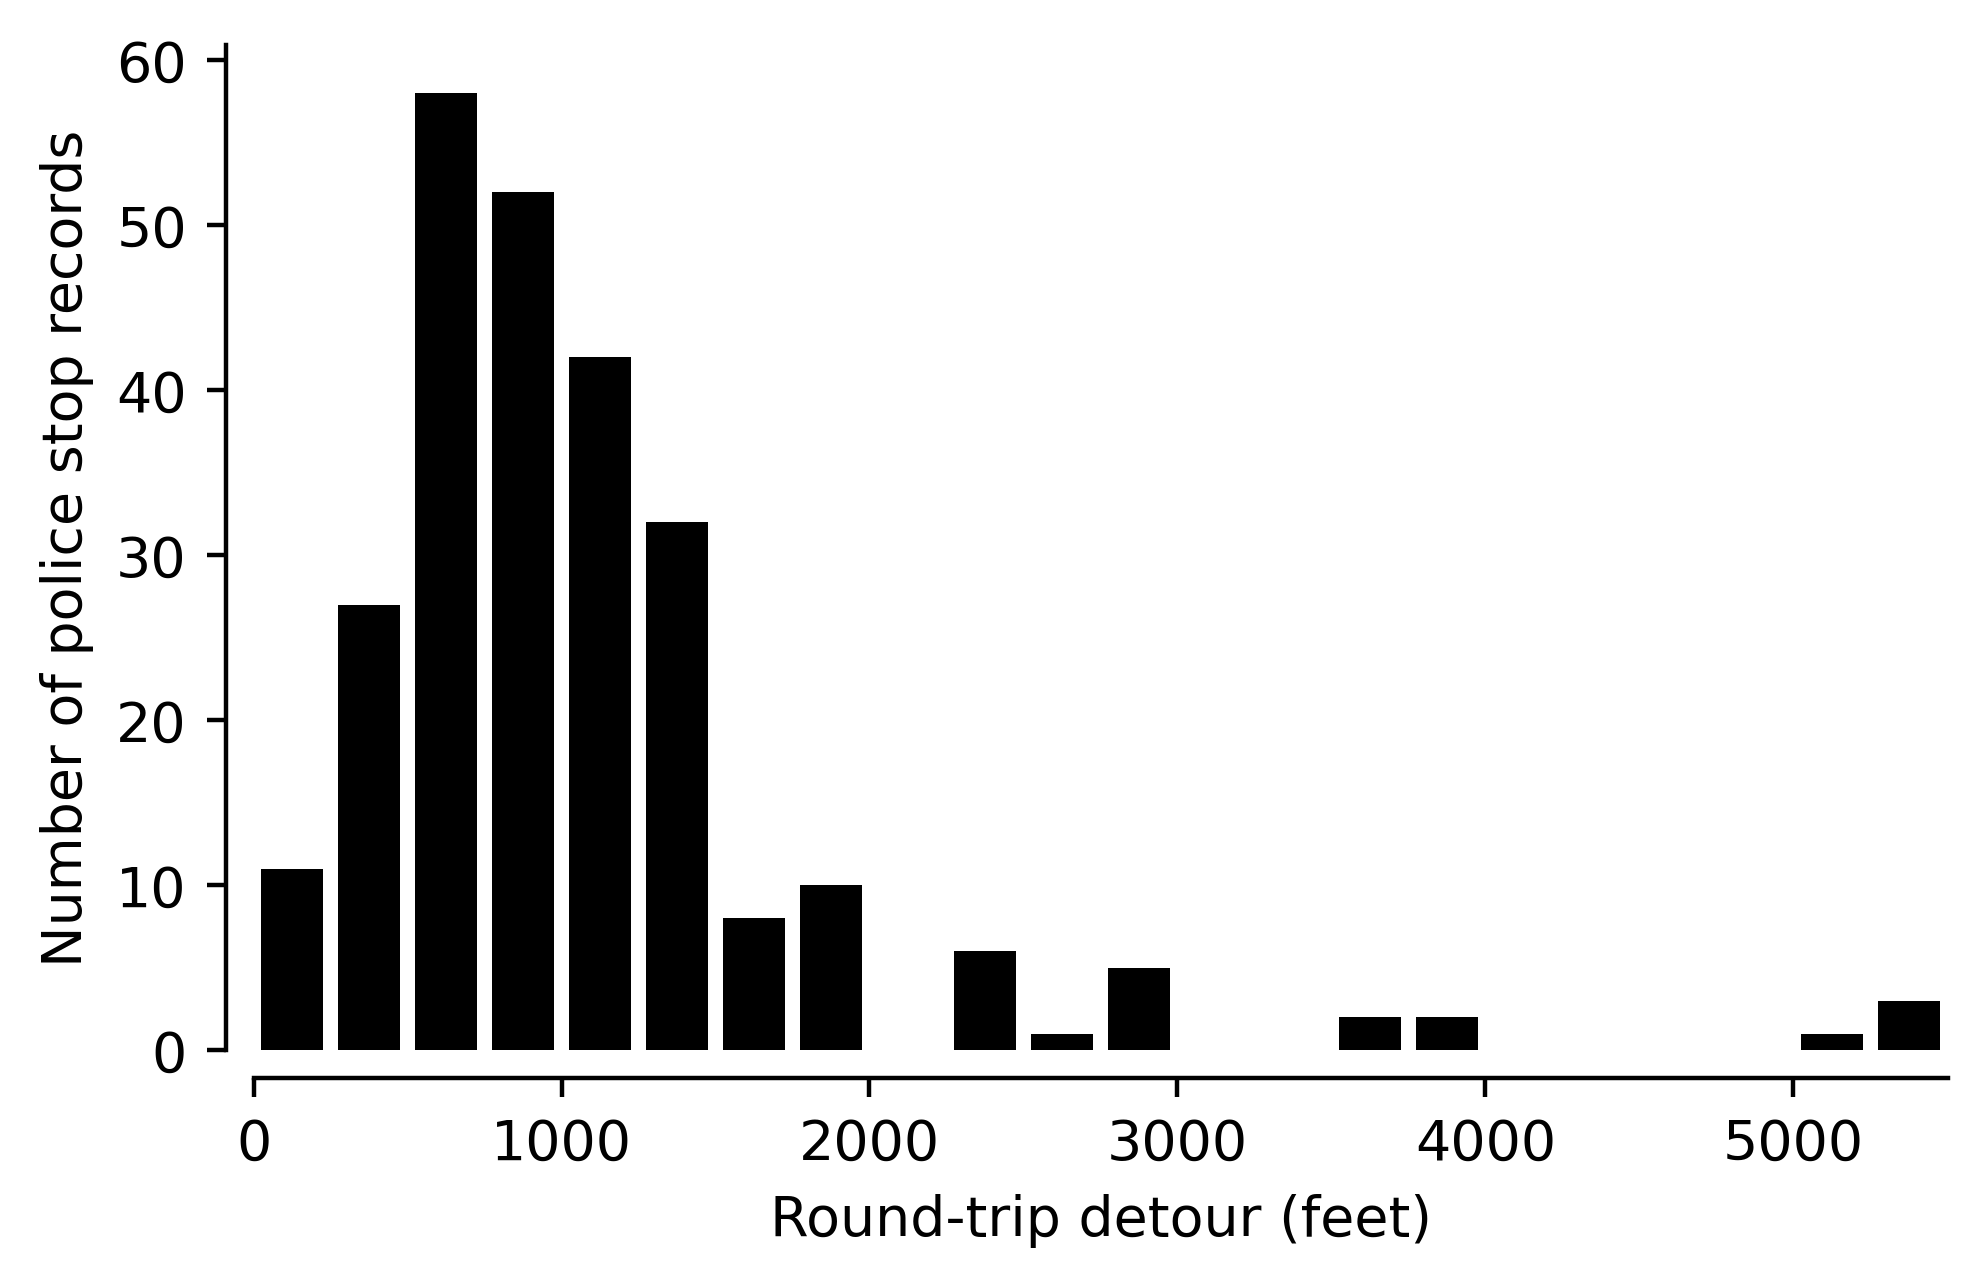

In [310]:
# Distance to nearest crosswalk or signalized intersection for mid-block crossing violations
mask_distance_sufficient = sufficient_mask('Sufficient for analysis - distance from crosswalk')
distance = 2 * contacts[mask_distance_sufficient & mask_stop]['Violation location - distance from nearest marked crosswalk (feet)']
contacts.loc[mask_distance_sufficient & mask_stop & ~pd.isna(contacts['Violation location - distance from nearest marked crosswalk (feet)']),
             'Included in analysis: distance'] = True  # Flag for final tabulation

plt.figure(figsize=(5,3.25),facecolor='w',dpi=400)
distance.plot.hist(bins=np.arange(0,5501,250),rwidth=0.8,color='k')
plt.xlim([0,5501])
plt.xlabel('Round-trip detour (feet)')
plt.ylabel('Number of police stop records')
plt.tight_layout()
drop_spines()
plt.savefig(current_results_dir + 'Distance to nearest crosswalk.pdf',bbox_inches='tight')

print('Number of records used:',len(distance.dropna()))
print('Mean round-trip distance (feet):',distance.mean())
print('Median round-trip distance (feet):',distance.median())

Violation location - total width of road in number of lanes  \
2.0                                                 30             
3.0                                                 76             
4.0                                                 61             
5.0                                                311             
6.0                                                 86             
7.0                                                138             
8.0                                                 23             
9.0                                                  4             

     Violation location - total width of road in number of lanes  
2.0                                           0.041152            
3.0                                           0.104252            
4.0                                           0.083676            
5.0                                           0.426612            
6.0                                           0.117970            
7.0                                           0.189300            
8.0                                           0.031550            
9.0                                           0.005487

Mean road width: 5.197530864197531
Median road width: 5.0
% with 5 lanes or more: 77.09190672153635


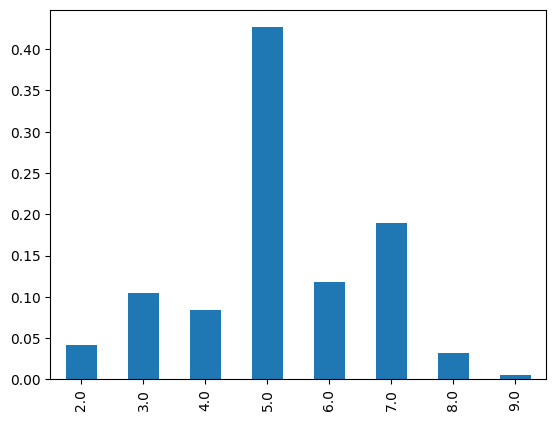

In [307]:
# Road width at crossing-related violation locations (midblock and against signal)
mask_road_width_sufficient = sufficient_mask('Sufficient for analysis - width of road')
road_width = contacts[mask_road_width_sufficient & mask_stop]['Violation location - total width of road in number of lanes']
contacts.loc[mask_road_width_sufficient & mask_stop & ~pd.isna(contacts['Violation location - total width of road in number of lanes']),
             'Included in analysis: width'] = True  # Flag for final tabulation

display(pd.concat([road_width.value_counts(),road_width.value_counts(normalize=True)],axis=1).sort_index())
road_width.value_counts(normalize=True).sort_index().plot.bar()

road_width_tab = road_width.value_counts(normalize=True).sort_index()
print('Mean road width:',road_width.mean())
print('Median road width:',road_width.median())
print('% with 5 lanes or more:',100 * road_width_tab[road_width_tab.index >= 5].sum())

In [303]:
# Sidewalks at walking-on-roadway violation locations
mask_sidewalks_sufficient = sufficient_mask('Sufficient for analysis - sidewalks')
mask_walking_on_roadway = (contacts['Type of jaywalking'] == 'Walking on roadway') | \
                          (contacts['Type of jaywalking'] == 'Walking on wrong side of roadway')
sidewalks = contacts[mask_sidewalks_sufficient & mask_walking_on_roadway & mask_stop]['Violation location - sidewalks']
contacts.loc[mask_sidewalks_sufficient & mask_walking_on_roadway & mask_stop,
             'Included in analysis: sidewalks'] = True  # Flag for final tabulation
display(pd.concat([sidewalks.value_counts(),sidewalks.value_counts(normalize=True)],axis=1).sort_index())

Violation location - sidewalks  Violation location - sidewalks
0.0                              21                           0.525
1.0                               3                           0.075
2.0                              16                           0.400

In [ ]:
# Most common road name fragments for jaywalking stops
all_street_parts = pd.concat([contacts['Violation location - address'].str.split().dropna().explode().str.title(),
                              contacts['Violation location - primary street'].str.split().dropna().explode().str.title(),
                              contacts['Violation location - cross street #1'].str.split().dropna().explode().str.title()])
all_street_parts.value_counts()[:25]

St           539
Ave          413
Ne           321
S            275
Blvd         162
Hwy          144
E            134
Way          131
W            130
99            92
Rd            90
Sw            84
Plain         84
Pacific       75
N             72
Se            71
4Th           67
Evergreen     50
State         33
Grand         30
Mill          29
Main          29
Fourth        29
Wa-308        27
3Rd           26
dtype: int64

In [295]:
# Frequency of warrant checks during jaywalking stops
mask_warrant_check_sufficient = sufficient_mask('Sufficient for analysis - warrant check frequency')
mask_warrant_check = mask_warrant_check_sufficient & mask_stop & ~pd.isna(contacts['Warrant check - conducted'])
contacts.loc[mask_warrant_check,
             'Included in analysis: warrant checks'] = True  # Flag for final tabulation
warrant_check = contacts[mask_warrant_check]['Warrant check - conducted'].dropna()
display(pd.concat([warrant_check.value_counts(),warrant_check.value_counts(normalize=True)],axis=1))

Warrant check - conducted  Warrant check - conducted
1.0                        445                   0.771231
0.0                        132                   0.228769

In [297]:
# Frequency of warrants identified from warrant checks
mask_warrant_identified_sufficient = sufficient_mask('Sufficient for analysis - warrant identified frequency')
mask_warrant_check = (contacts['Warrant check - conducted'] == True)
mask_warrant_identified = mask_warrant_check & mask_warrant_identified_sufficient & mask_stop
warrant_from_check = contacts[mask_warrant_identified]['Warrant check - warrant identified']
contacts.loc[mask_warrant_identified,
             'Included in analysis: warrant identified'] = True  # Flag for final tabulation
warrant_from_check_disp = warrant_from_check.fillna('Unknown (can assume False in most cases)')
display(pd.concat([warrant_from_check_disp.value_counts(),warrant_from_check_disp.value_counts(normalize=True)],axis=1))

Warrant check - warrant identified  \
0.0                                                                      290   
Unknown (can assume False in most cases)                                 122   
1.0                                                                       78   

                                          Warrant check - warrant identified  
0.0                                                                 0.591837  
Unknown (can assume False in most cases)                            0.248980  
1.0                                                                 0.159184

In [299]:
# Out of all warrants that were identified, what fraction led to an arrest?
# Note: this statistic should be regarded as approximate due to the multiple tiers of screening and small sample size
arrest_from_warrant = contacts[mask_warrant_identified]['Warrant check - warrant led to arrest']
contacts.loc[mask_warrant_identified & ~np.isnan(contacts['Warrant check - warrant led to arrest']),
             'Included in analysis: warrant led to arrest'] = True  # Flag for final tabulation
arrest_from_warrant = arrest_from_warrant.dropna()
display(pd.concat([arrest_from_warrant.value_counts(),arrest_from_warrant.value_counts(normalize=True)],axis=1))

Warrant check - warrant led to arrest  \
1.0                                     39   
0.0                                     35   

     Warrant check - warrant led to arrest  
1.0                               0.527027  
0.0                               0.472973

Warrant check - warrant led to arrest  \
1.0                                         61   
Unknown                                     27   
0.0                                          7   

         Warrant check - warrant led to arrest  
1.0                                   0.642105  
Unknown                               0.284211  
0.0                                   0.073684

<Axes: ylabel='Warrant check - warrant led to arrest'>

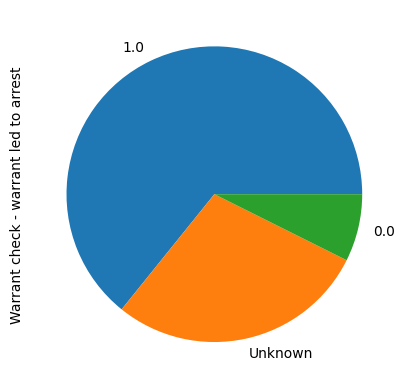

In [300]:
# Out of all arrests that occurred, what fraction resulted from open warrant? (versus, e.g., obstruction)
mask_warrant_arrest_sufficient = sufficient_mask('Sufficient for analysis - warrant led to arrest frequency')
mask_arrest = (contacts['Stop outcome'] == 'Arrest') | (contacts['Stop outcome'] == 'Citation and arrest')
arrest_from_warrant = contacts[mask_arrest & mask_warrant_arrest_sufficient & mask_stop]['Warrant check - warrant led to arrest']
arrest_from_warrant = arrest_from_warrant.fillna('Unknown')
display(pd.concat([arrest_from_warrant.value_counts(),arrest_from_warrant.value_counts(normalize=True)],axis=1))
arrest_from_warrant.value_counts().plot.pie()

In [ ]:
# Number of jaywalking stop records with arrest for drug possession or drug paraphernalia
contacts[mask_stop & ((contacts['Stop outcome'] == 'Arrest') | \
                      (contacts['Stop outcome'] == 'Citation and arrest'))]\
                       ['Concurrent situation - drugs or drug use discovered after contact'].value_counts()

1.0    19
Name: Concurrent situation - drugs or drug use discovered after contact, dtype: int64

In [ ]:
# Number of records
contacts[mask_stop]['Contact involved use of force and/or pursuit'].value_counts()

1.0    30
Name: Contact involved use of force and/or pursuit, dtype: int64

In [ ]:
# Frequency of drug or alcohol use noted before jaywalking stop
usage = contacts['Concurrent situation - drug or alcohol use noted before contact'].fillna(False).astype(bool)[mask_stop]
display(pd.concat([usage.value_counts(),usage.value_counts(normalize=True)],axis=1).sort_index())

Concurrent situation - drug or alcohol use noted before contact  \
False                                               1042                 
True                                                  37                 

       Concurrent situation - drug or alcohol use noted before contact  
False                                           0.965709                
True                                            0.034291

## Analyze Seattle PD citations for comparison to CAD statistics

In [ ]:
sea_mask = np.logical_and(aoc_extracted['LEA'] == 'Seattle PD',
                          aoc_extracted['Jaywalking (roadway violations only)'] == True)
print('Total jaywalking citations issued by Seattle PD from 2016-2022:',
      aoc_extracted[sea_mask]['Violation Date'].dt.year.value_counts().sort_index().loc[2016:2022].sum())

Total jaywalking citations issued by Seattle PD from 2016-2022: 729


## Miscellaneous additional analyses

In [ ]:
# Frequency of jaywalking stops originating from due care violation
# Note: if pursuing due care analysis, consider limiting to all records
#       (incl. CAD logs) with police narratives available (= TRUE)
mask_due_care = sufficient_mask('Sufficient for analysis - frequency of due care violation')
due_care = contacts[mask_stop & mask_due_care]['Due care violation']
due_care = due_care.fillna(False).astype(bool)
display(pd.concat([due_care.value_counts(),due_care.value_counts(normalize=True)],axis=1))
# due_care.value_counts().plot.pie()

Due care violation  Due care violation
False                 172            0.601399
True                  114            0.398601

<Axes: >

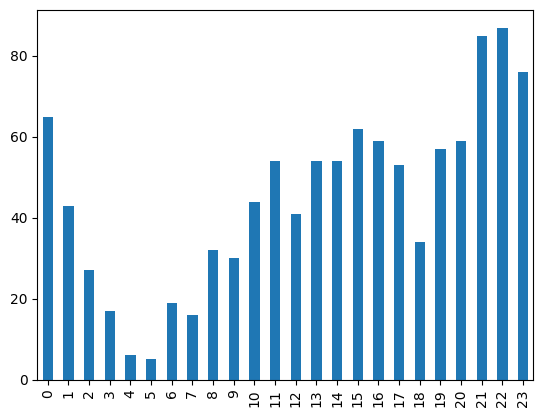

In [ ]:
# Contact times for jaywalking stops
hours = contacts[mask_stop]['Contact datetime'].dt.hour
hours.value_counts().sort_index().plot.bar()

Mean age: 35.912396070639275
Median age: 34.29033576697848


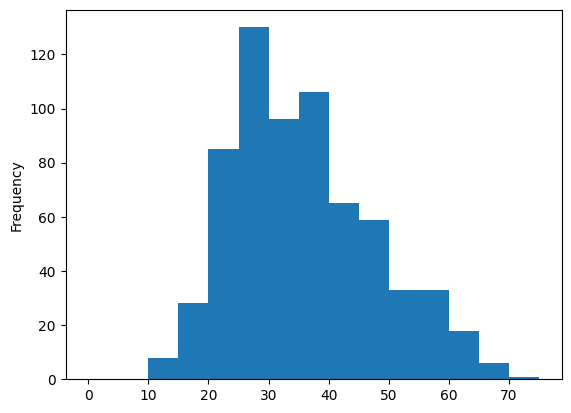

In [ ]:
# Age of jaywalking stop subjects
plt.figure()
ages = ((contacts[mask_stop]['Contact datetime'] - contacts[mask_stop]['Subject - birth date']) / timedelta(days=1)) / 365.25
age_available_already = ~np.isnan(contacts[mask_stop]['Subject - age'])
ages[age_available_already] = contacts[mask_stop]['Subject - age'][age_available_already]
ages.dropna().plot.hist(bins=np.arange(0,80,5))

print('Mean age:',ages.mean())
print('Median age:',ages.median())

In [ ]:
# Generate Renton jaywalking stop locations to export to BatchGeo map
contacts_renton = contacts[(contacts['Contact location - city'] == 'Renton') & mask_stop]
intersections = (contacts_renton['Violation location - primary street'] + ' and ' + \
                 contacts_renton['Violation location - cross street #1']).dropna()
addresses = contacts_renton['Violation location - address'].dropna()

print('Number of locations:',len(pd.concat([intersections,addresses])))
pd.concat([intersections,addresses]).to_excel(current_results_dir + 'renton_locations.xlsx')

Number of locations: 55


In [ ]:
# Generate Federal Way jaywalking stop locations to export to BatchGeo map
contacts_fedway = contacts[(contacts['Contact location - city'] == 'Federal Way') & mask_stop]
intersections = (contacts_fedway['Violation location - primary street'] + ' and ' + \
                 contacts_fedway['Violation location - cross street #1']).dropna()
addresses = contacts_fedway['Violation location - address'].dropna()

print('Number of locations:',len(pd.concat([intersections,addresses])))
pd.concat([intersections,addresses]).to_excel(current_results_dir + 'federal_way_locations.xlsx')

Number of locations: 44


## Generate table of police stop records

In [319]:
tab_con = contacts[mask_stop | mask_prot]
tab_met = meta[['Source','Installment ID','Search keywords']].copy()
tab_met['File/record tokens'] = [[] for row in range(len(tab_met))]
tab_met['Installment IDs'] = [[] for row in range(len(tab_met))]
tab_met['Record types'] = [[] for row in range(len(tab_met))]
tab_met['Datetimes'] = [[] for row in range(len(tab_met))]
tab_met['LEAs'] = [[] for row in range(len(tab_met))]
tab_met['Counties'] = [[] for row in range(len(tab_met))]
tab_met['Cities'] = [[] for row in range(len(tab_met))]
tab_met['Fig. 8'] = [[] for row in range(len(tab_met))]                # Outcomes of police stops
tab_met['Fig. 9, Fig. B4'] = [[] for row in range(len(tab_met))]       # Race of individuals stopped
tab_met['Fig. 12'] = [[] for row in range(len(tab_met))]               # Homeless status
tab_met['Fig. 13'] = [[] for row in range(len(tab_met))]               # Distance to nearest crossing
tab_met['Road width'] = [[] for row in range(len(tab_met))]            # Roadway width
tab_met['Sidewalks'] = [[] for row in range(len(tab_met))]             # Presence of sidewalks
tab_met['Warrant checks'] = [[] for row in range(len(tab_met))]        # Whether a warrant check occurred
tab_met['Warrant identified'] = [[] for row in range(len(tab_met))]    # Whether a warrant was identified
tab_met['Warrant arrest'] = [[] for row in range(len(tab_met))]        # Whether a warrant led to arrest

included_names = ['Fig. 8','Fig. 9, Fig. B4','Fig. 12','Fig. 13','Road width',
                  'Sidewalks','Warrant checks','Warrant identified','Warrant arrest']

In [320]:
# • Note #1: Some records may concern two or more jaywalking stops, and some
# jaywalking stops may be detailed in two or more records; thus, the total number of
# "records" tallied here will not necessarily equal the number of police stops analyzed.
# • Note #2: Protest-related police contacts resulting in jaywalking citations are
# included in this table and mentioned in the report, though they are not considered
# jaywalking stops.

def dedup_record_types(record_types):
  record_types = np.array(record_types)
  if 'Incident report + citation + CAD log' in record_types:
    record_types = np.append(record_types[record_types != 'Incident report + citation + CAD log'],
                            np.array(['Incident report','Citation','CAD log']))
  if 'Incident report + CAD log' in record_types:
    record_types = np.append(record_types[record_types != 'Incident report + CAD log'],
                            np.array(['Incident report','CAD log']))
  if 'Incident report + citation' in record_types:
    record_types = np.append(record_types[record_types != 'Incident report + citation'],
                            np.array(['Incident report','Citation']))
  if 'Citation + CAD log' in record_types:
    record_types = np.append(record_types[record_types != 'Citation + CAD log'],
                            np.array(['Citation','CAD log']))
    record_types = record_types[record_types != 'Citation spreadsheet']
    record_types = record_types[record_types != 'Miscellaneous arrest-related documents']
    record_types = record_types[record_types != 'Warrant/warrant settle slip']
    record_types = record_types[record_types != 'BWV/ICV footage']
    record_types = record_types[record_types != 'Image(s)']
  return np.unique(record_types)

rec_nums = [' #1',' #2']
for index, row in tab_con.iterrows():
  for n in rec_nums:
    source_name = row['Source' + n]
    if not pd.isna(source_name):  # Source is present
      install_id = str(row['Installment ID from source' + n])
      filename = row['Filename for record' + n]
      page_row = row['Page/row number for record' + n]

      # Create unique token for record using filename and page/row number, if applicable
      if pd.isna(page_row): file_token = filename
      else:                 file_token = filename + ' (' + str(int(page_row)) + ')'

      # Identify corresponding row of source in Meta sheet
      row_idx = tab_met.index[((tab_met['Source'] == source_name) & \
                               (tab_met['Installment ID'].str.contains(install_id)))].values[0]

      # Save fields into Meta sheet
      tab_met.loc[row_idx,'File/record tokens'].append(file_token)
      tab_met.loc[row_idx,'Installment IDs'].append(install_id)
      tab_met.loc[row_idx,'Record types'].append(row['Type of record' + n])
      tab_met.loc[row_idx,'Datetimes'].append(row['Contact datetime'])
      tab_met.loc[row_idx,'LEAs'].append(row['Primary law enforcement agency'])
      tab_met.loc[row_idx,'Counties'].append(row['Contact location - county'])
      tab_met.loc[row_idx,'Cities'].append(row['Contact location - city'])
      tab_met.loc[row_idx,'Fig. 8'].append(row['Included in analysis: outcomes'])
      tab_met.loc[row_idx,'Fig. 9, Fig. B4'].append(row['Included in analysis: race'])
      tab_met.loc[row_idx,'Fig. 12'].append(row['Included in analysis: homelessness'])
      tab_met.loc[row_idx,'Fig. 13'].append(row['Included in analysis: distance'])
      tab_met.loc[row_idx,'Road width'].append(row['Included in analysis: width'])
      tab_met.loc[row_idx,'Sidewalks'].append(row['Included in analysis: sidewalks'])
      tab_met.loc[row_idx,'Warrant checks'].append(row['Included in analysis: warrant checks'])
      tab_met.loc[row_idx,'Warrant identified'].append(row['Included in analysis: warrant identified'])
      tab_met.loc[row_idx,'Warrant arrest'].append(row['Included in analysis: warrant led to arrest'])
    else:                      # Source is not present (NaN)
      continue

tab_met['Number of documents'] = tab_met['File/record tokens'].apply(len)
tab_met = tab_met.loc[tab_met['Number of documents'] > 0]
tab_met['Start date'] = tab_met['Datetimes'].apply(min).dt.strftime('%m/%d/%Y').values
tab_met['End date'] = tab_met['Datetimes'].apply(max).dt.strftime('%m/%d/%Y').values
tab_met['Dates'] = tab_met['Start date'] + '-' + tab_met['End date']
tab_met.loc[tab_met['Start date'] == tab_met['End date'],'Dates'] = \
  tab_met['Start date'][tab_met['Start date'] == tab_met['End date']]
for row_idx, row in tab_met.iterrows():
  tab_met.loc[row_idx,'Installment IDs'] = ', '.join(np.unique(row['Installment IDs']))
  tab_met.loc[row_idx,'Record types'] = ', '.join(dedup_record_types(row['Record types']))
  tab_met.loc[row_idx,'Counties'] = ', '.join(np.unique(row['Counties']))
  tab_met.loc[row_idx,'LEAs'] = ', '.join(np.unique(row['LEAs']))
  tab_met.loc[row_idx,'Cities'] = ', '.join(np.unique(row['Cities']))
  for col_name in included_names:
    tab_met.loc[row_idx,col_name] = np.nansum(row[col_name]) / row['Number of documents']
tab_met.rename(columns={'Counties':'County'},inplace=True)
tab_met = tab_met[['Source','Search keywords','Record types','Number of documents',
                   'Dates','County','Cities','LEAs',*included_names]]

# Zero out cases where CAD logs were manually connected with citations from different source
tab_met.loc[tab_met['Record types'] == 'CAD log','Fig. 12'] = 0

tab_met = tab_met.set_index(['Source','Search keywords','Record types'])

tab_met.to_excel(current_results_dir + 'Records_table.xlsx')
display(tab_met)

<ipython-input-320-8344380ece8c>:68: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tab_met['Start date'] = tab_met['Datetimes'].apply(min).dt.strftime('%m/%d/%Y').values
<ipython-input-320-8344380ece8c>:69: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tab_met['End date'] = tab_met['Datetimes'].apply(max).dt.strftime('%m/%d/%Y').values
<ipython-input-320-8344380ece8c>:70: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = val

Number of documents  \
Source                                             Search keywords                                   Record types                                              
South Sound 911                                    "jaywalk"                                         CAD log                                             147   
                                                                                                     Incident report                                      25   
Valley Communications Center (ValleyCom)           "jaywalk"                                         CAD log                                              24   
                                                   "pedestrian"                                      CAD log                                              23   
Clark Regional Emergency Services Agency (CRESA)   "jaywalk", "jay walk"                             CAD log                                             227   
                                                   "obstruct", "interfer" + "traffic"                CAD log                                               5   
                                                   "pedestrian" + "cross", "pedestrian" + "signal"   CAD log                                               1   
Northeast King County Regional Public Safety Co... "jaywalk"                                         CAD log                                             104   
Snohomish County 911 (SNO911)                      "jaywalk"                                         CAD log                                             295   
Spokane PD                                         "PEDVIO"                                          CAD log, Citation, Incident report                   80   
Federal Way PD                                     "RCW 46.61"                                       Citation, Incident report                            36   
Kirkland PD                                        "jaywalk", "jay walk"                             CAD log, Citation, Incident report                   22   
Renton PD                                          "pedestrian" (in violation description)           CAD log, Citation, Incident report                   39   
Kennewick PD                                       "RCW 46.61", "KMC 10.08.020"                      Citation                                             24   
                                                   "jaywalk"                                         CAD log                                               6   
                                                   "crosswalk", "obstruct" + "traffic"               CAD log, Citation, Incident report                   23   
Washington State Patrol                            "RCW 46.61.230", "RCW 46.61.240", "RCW 46.61.250" Citation                                             80   

                                                                                                                                                         Dates  \
Source                                             Search keywords                                   Record types                                                
South Sound 911                                    "jaywalk"                                         CAD log                             02/16/2017-08/11/2022   
                                                                                                     Incident report                     02/13/2017-12/12/2020   
Valley Communications Center (ValleyCom)           "jaywalk"                                         CAD log                             10/22/2019-10/07/2022   
                                                   "pedestrian"                                      CAD log                             10/22/2019-09/28/2022   
Clark Regional Emergency Services Agency (CRESA)   "jaywalk", "jay walk"                             CAD log                